## TODO:
- get hours per day bar chart, total for a week with error bars of standard deviation
- get chart with application weekly usage over one year (time series)
- Source for title code: https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

#--For importing Files--
import glob
import os

#--For Meraki--
from meraki import meraki
import json
from ipaddress import ip_address
import re
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

# 1. 24-hour Daily Traffic Analytic Data (All Applications and Total Device Numbers)
- TODO:
-- Incorporate Date portion of file name to make funciton more universal in function make_df

#### File to push into make_df function

In [3]:
file1 = 'Data/traffic_analytics/daily_traffic_analytics_Apr5_Apr12/*.csv'

#### Function to make database from .csv files

In [4]:
def make_df(files):
    camp_lst = ['Moria', 'Nea', 'Vathi', 'Skaram', 'Kos', 'Veria']
    date_lst = ['04052019', '04062019', '04072019', '04082019', '04092019', '04102019', '04112019']
    
    globbed_files = glob.glob(files) #create a list of all csv files
    data = [] 
    for file in globbed_files:

        frame = pd.read_csv(file)
        frame['filename'] = os.path.basename(file)
#         frame['date'] = date
#         frame['Time'] = time    
        data.append(frame)
    
    app_usage = pd.concat(data, ignore_index=True)
    
    #--Add camp name-
    camp_list = list(app_usage['filename'].unique())
    s = '(' + '|'.join(camp_lst) + ')'
    app_usage['camp_name'] = app_usage['filename'].str.extract(s, expand=False)
    
    #--Add date--
    date_list = list(app_usage['filename'].unique())
    s = '(' + '|'.join(date_lst) + ')'
    app_usage['date'] = app_usage['filename'].str.extract(s, expand=False)
#     app_usage['date'] = app_usage['date'].astype(str).astype(int)
    
    app_usage['date'] = app_usage['date'].astype(str)
    
    return app_usage

#### Database that includes all daily .csv files from Cisco Meraki "Traffic analytics" pages - all 6 camps

In [5]:
#--Create dataframe with all data--
data = make_df(file1)

In [7]:
# data.Application.value_counts()

#### Clean database: standardizes Active time to hours, adds column Hours_per_client

In [6]:
#_______________________________________
### FINAL ### 
#---------------------------------------

#--Clean Active time, give consistent values in minutes--
data['ActiveTime_Minutes'] = 0

#--get increment--
data['active_time_increment'] = data['Active time'].str.replace('\d+', '') 
data['active_time_increment'] = data['active_time_increment'].str.replace('.', '')

### -- TODO: Fix line below, it only gets int, need to get both int and float numbers--
data['active_time_num'] = data['Active time'].str.extract('([\d\.]+)')

data['active_time_num'] = data['active_time_num'].astype(str).astype(float)

#--Loop through this list--
# unique_vals = list(data['active_time_increment'].unique())

#--to get to minutes--
hour = 60
day = 24*60
week = 7*day
month = 30.3*day
year = 365*day

#Source: https://stackoverflow.com/questions/33769860/pandas-apply-but-only-for-rows-where-a-condition-is-met
#Source: https://stackoverflow.com/questions/10715519/conditionally-fill-column-values-based-on-another-columns-value-in-pandas
minu = data[data['active_time_increment'].str.contains('minute')]
hr = data[data['active_time_increment'].str.contains('hour')] 
dy = data[data['active_time_increment'].str.contains('day')]
wk = data[data['active_time_increment'].str.contains('week')]
mon = data[data['active_time_increment'].str.contains('month')] 


# #--Add minutes for each row--
minu['ActiveTime_Minutes'] = minu['active_time_num']
hr['ActiveTime_Minutes'] = hour*hr['active_time_num']
dy['ActiveTime_Minutes'] = day*dy['active_time_num']
wk['ActiveTime_Minutes'] = week*wk['active_time_num']
mon['ActiveTime_Minutes'] = month*mon['active_time_num']

traffic = pd.concat([minu,hr,dy,wk,mon])


# # --Add hours column--
traffic['ActiveTime_hours'] = traffic['ActiveTime_Minutes'].div(60).round(2)

#--Add hours per client--
traffic['Hours_per_Client'] = traffic['ActiveTime_hours'].div(traffic['# clients']).round(2)

#--Change date to datetime--
traffic['date_time'] = traffic['date'].apply(pd.to_datetime, format='%m%d%Y')

In [93]:
# traffic['# clients'].sum()

In [ ]:
traffic

In [11]:
m = traffic[traffic.Application == 'Facebook']
m.ActiveTime_hours.sum() / m['# clients'].sum()

1.029467336683417

In [1]:
m

In [33]:
# traffic.dtypes

In [10]:
#--Make sure all of the rows of data made it to the dataframe--
len(hr) + len(dy) + len(wk) +len(mon) + len(minu)

4062

In [11]:
traffic[traffic.Application =='Facebook'].sum()

Application              FacebookFacebookFacebookFacebookFacebookFacebo...
Destination                                                              0
Protocol                        ------------------------------------------
Port                            ------------------------------------------
% Usage                                                              668.8
Usage                                                           1019743990
Sent                                                              57878446
Received                                                         961865544
Flows                                                              2864033
Active time              14 days45 days16 days34 days12 days59 days41 d...
# clients                                                            24875
filename                 Vathi_04082019_traffic_analytics_past24hrs.csv...
camp_name                VathiNeaKosVeriaVathiMoriaNeaMoriaNeaSkaramSka...
date                     

# Get totals/sums for each application

In [21]:
totals = traffic.groupby('Application').sum().reset_index()
tot = totals.sort_values(by='ActiveTime_hours', ascending=False)
top10appByHours = tot[0:10]
top10appByHours #--for all camps

#--Top 10 applications used by hour
top10Hourslst = ['Google HTTPS', 'Facebook', 'YouTube', 'Miscellaneous secure web', 'UDP', 'Google',
                'DNS', 'Instagram', 'Google advertising', 'iTunes']

In [22]:
top10usageHr_df = traffic[traffic.Application.isin(top10Hourslst)]

moria_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Moria']
kos_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Kos']
nea_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Nea']
skaram_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Skaram']
vathi_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Vathi']
veria_top10 = top10usageHr_df[top10usageHr_df['camp_name']=='Veria']

In [79]:
active_tocsv = top10usageHr_df[['Application', 'camp_name', 'ActiveTime_hours', 'date']]
active_tocsv.to_csv('Time Series Data for Top 10 Applications by Active Hours for a Week.csv')

In [2]:
time_app_usage(top10usageHr_df)
plt.title("Top Application Usage per Day in Hours - All Camps", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - All Camps')

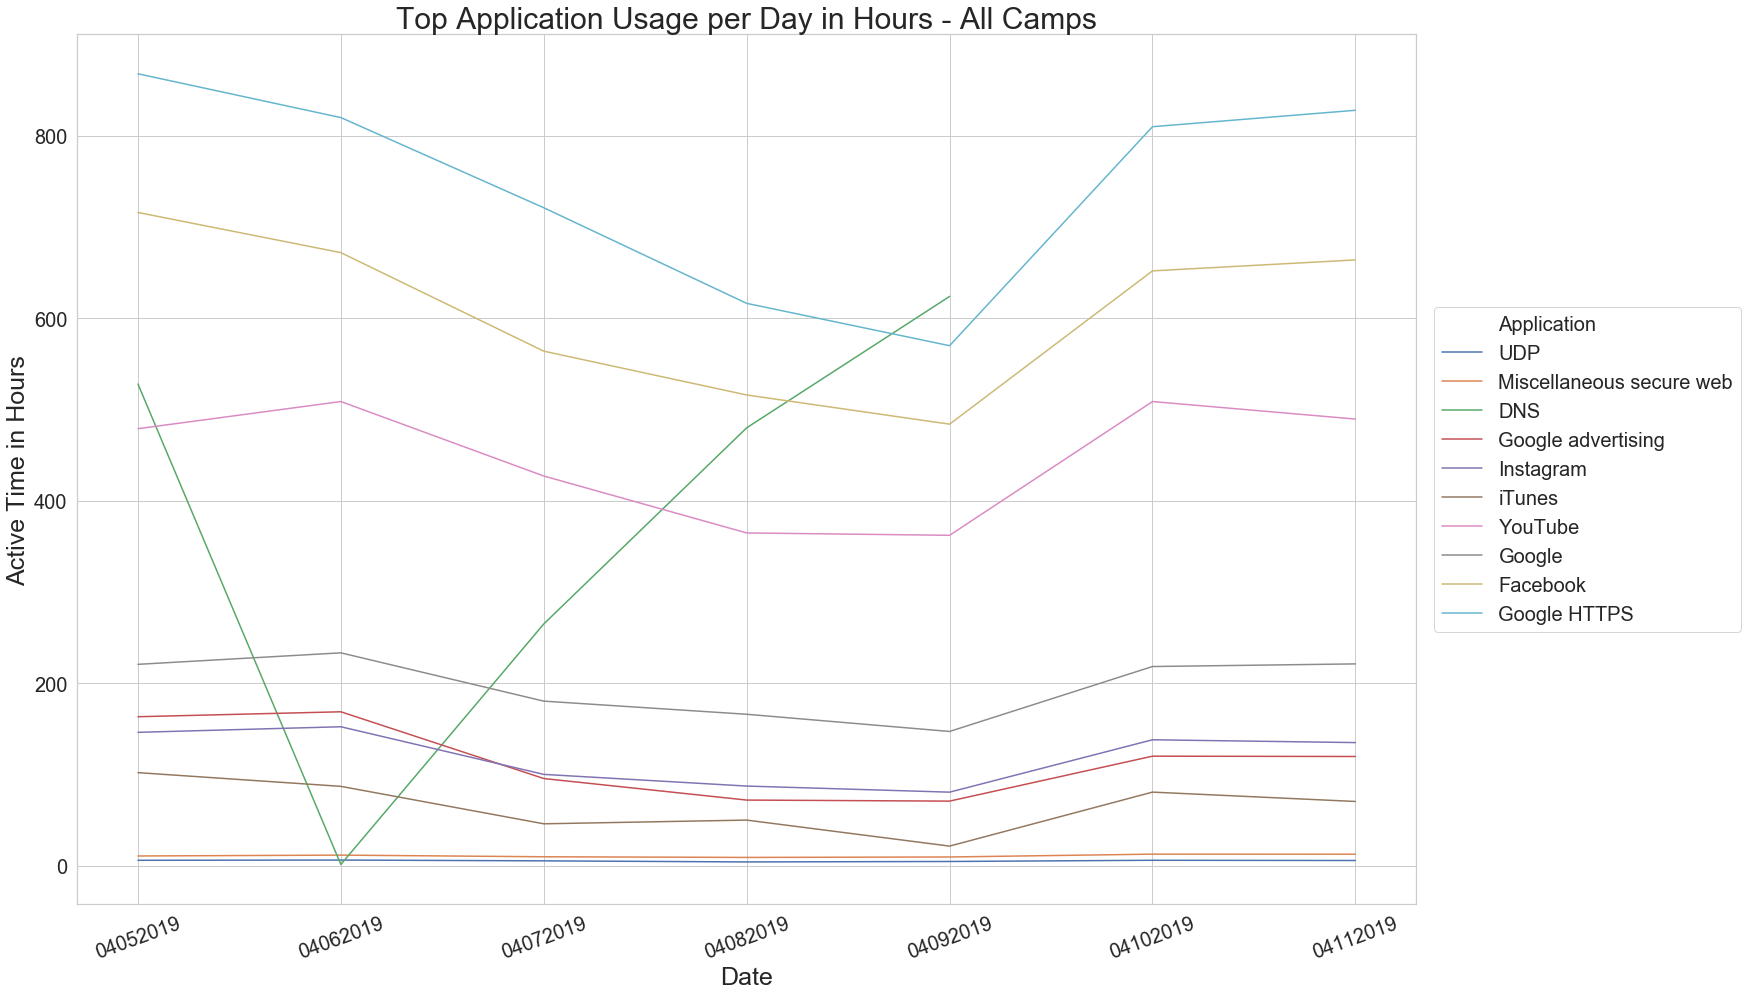

In [58]:
time_app_usage(top10usageHr_df)
plt.title("Top Application Usage per Day in Hours - All Camps", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - Kos')

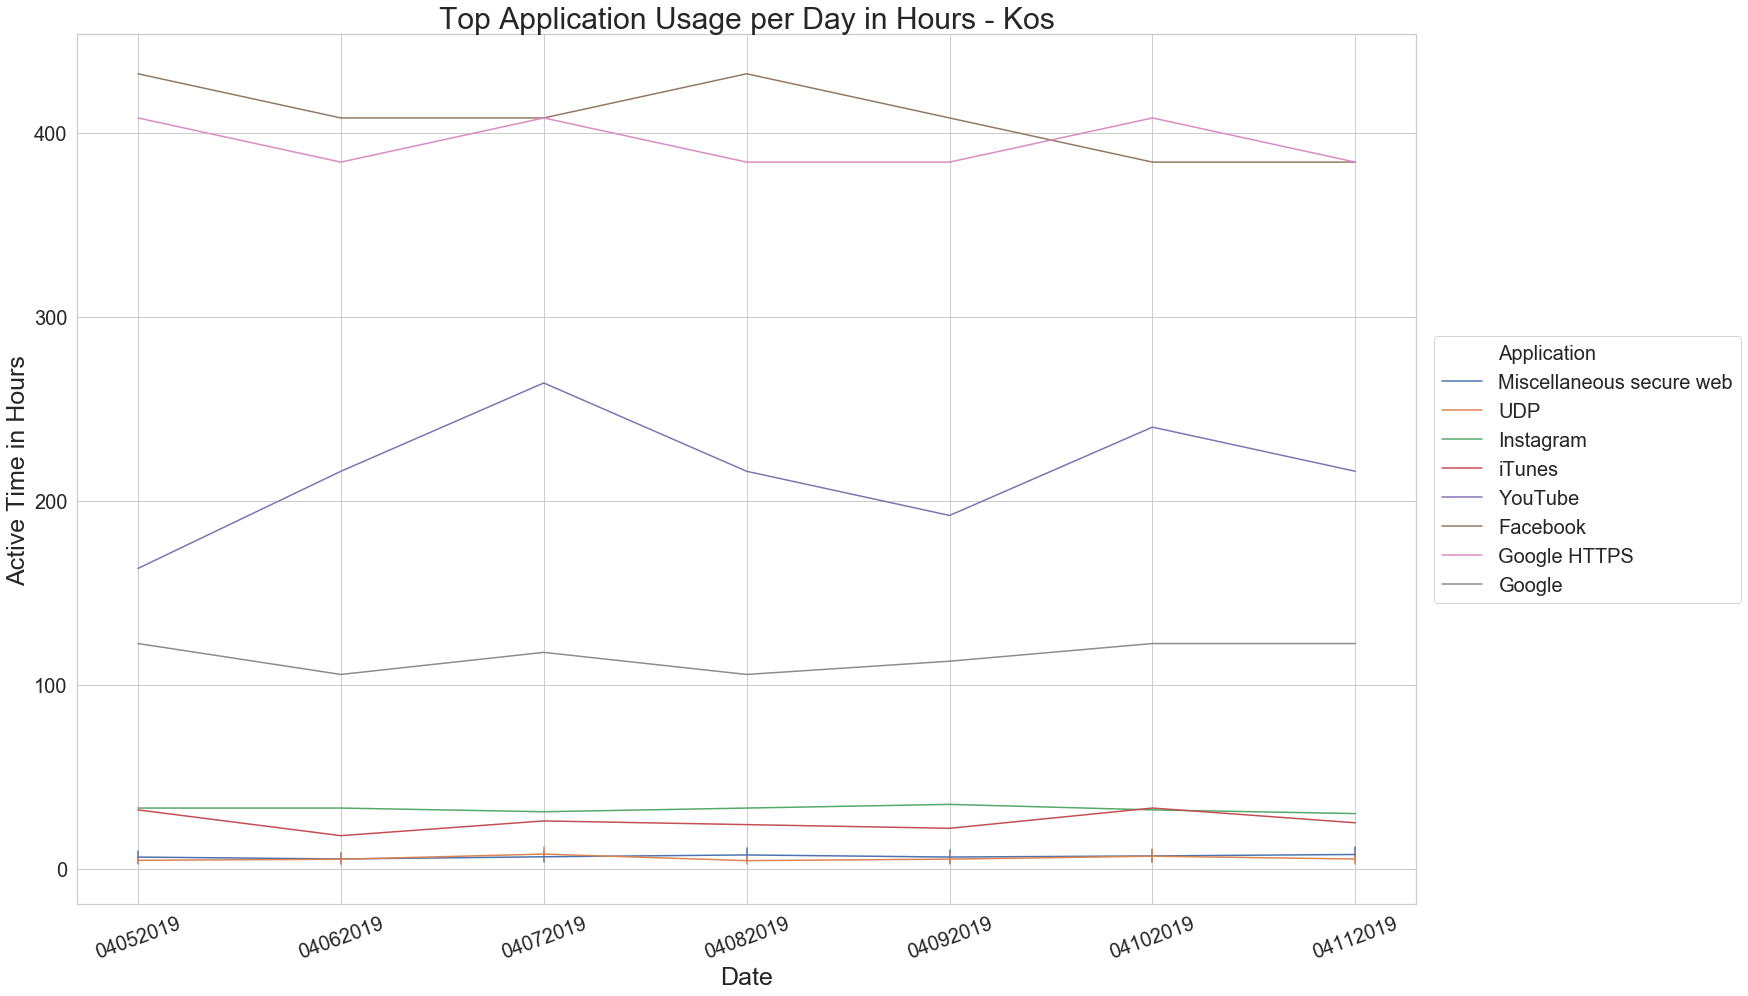

In [27]:
time_app_usage(kos_top10)
plt.title("Top Application Usage per Day in Hours - Kos", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - Moria')

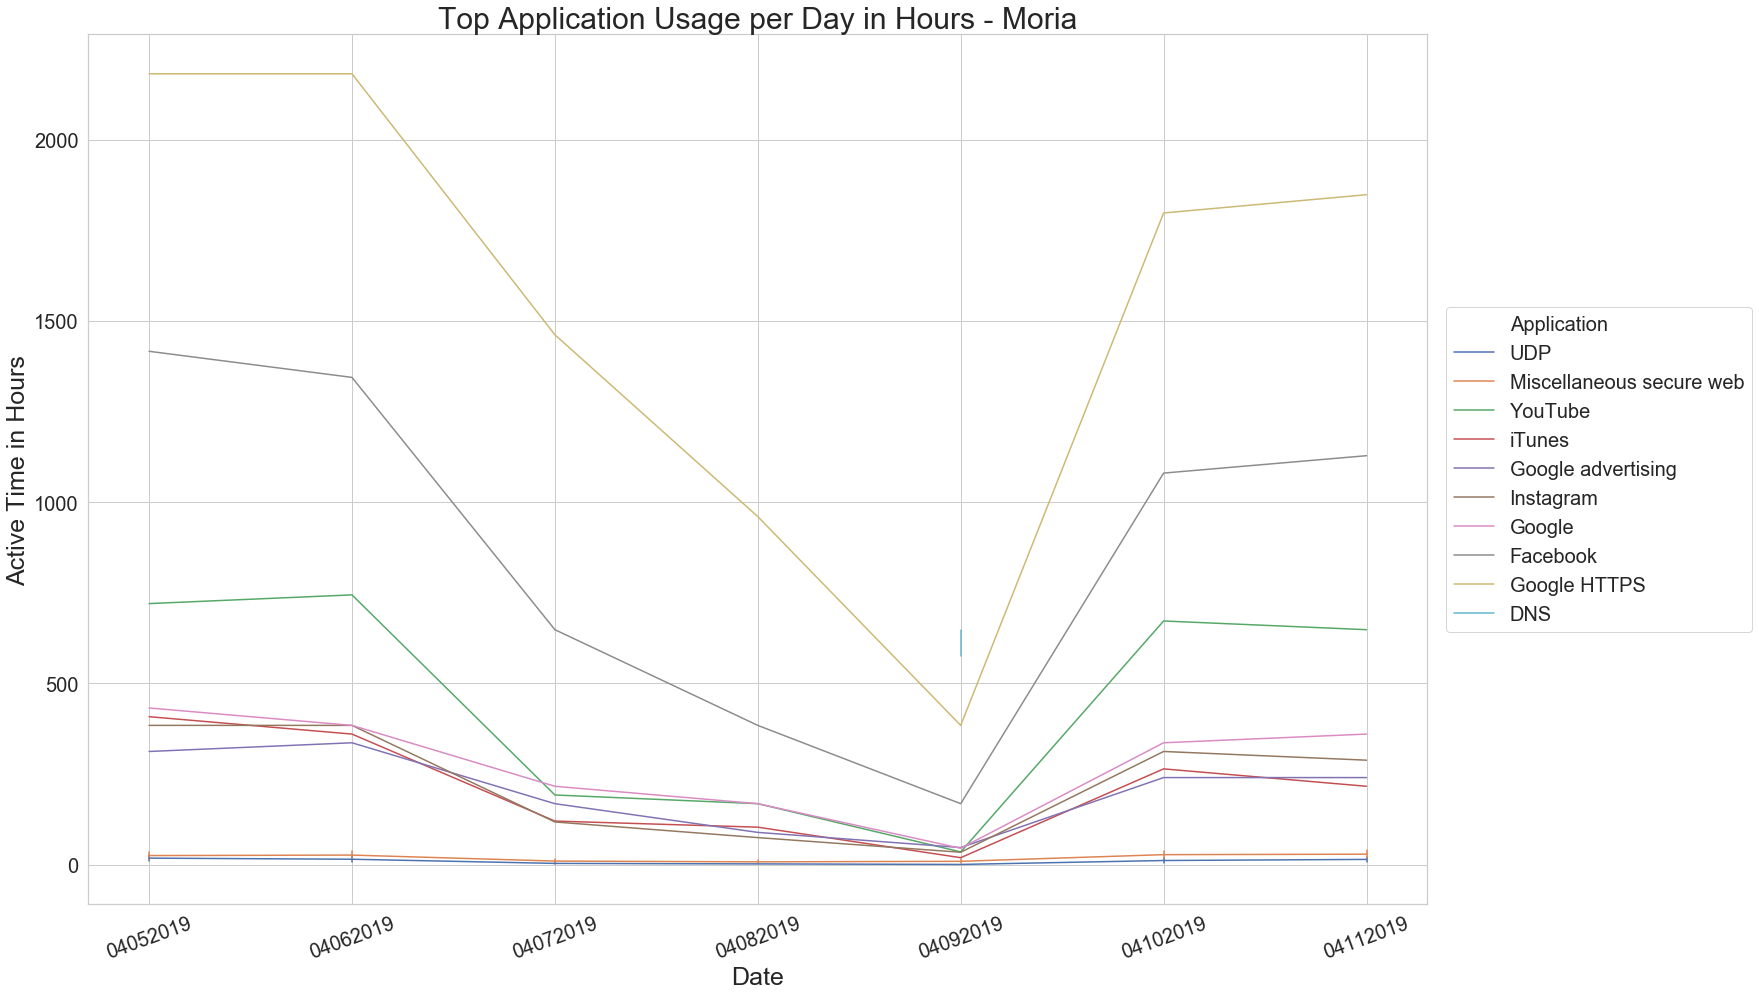

In [46]:
time_app_usage(moria_top10)
plt.title("Top Application Usage per Day in Hours - Moria", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - Nea Kavala')

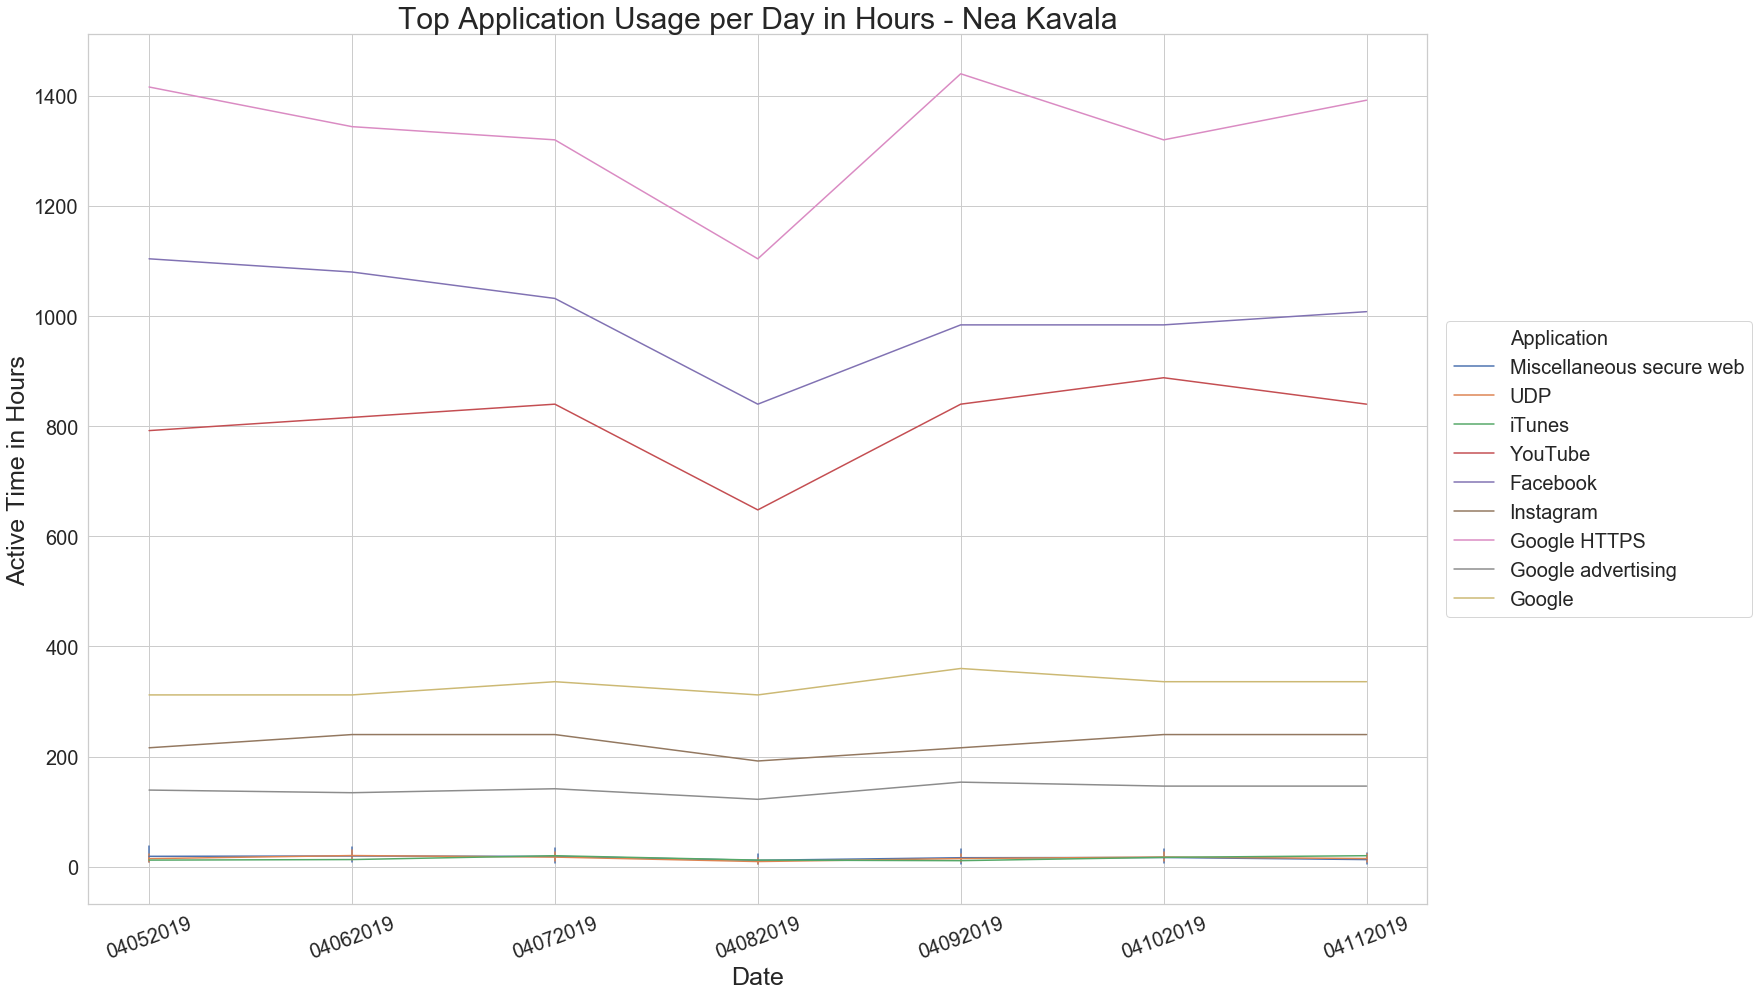

In [47]:
time_app_usage(nea_top10)
plt.title("Top Application Usage per Day in Hours - Nea Kavala", fontsize=30)

# START HERE

Text(0.5,1,'Top Application Usage per Day in Hours - Skaramangas')

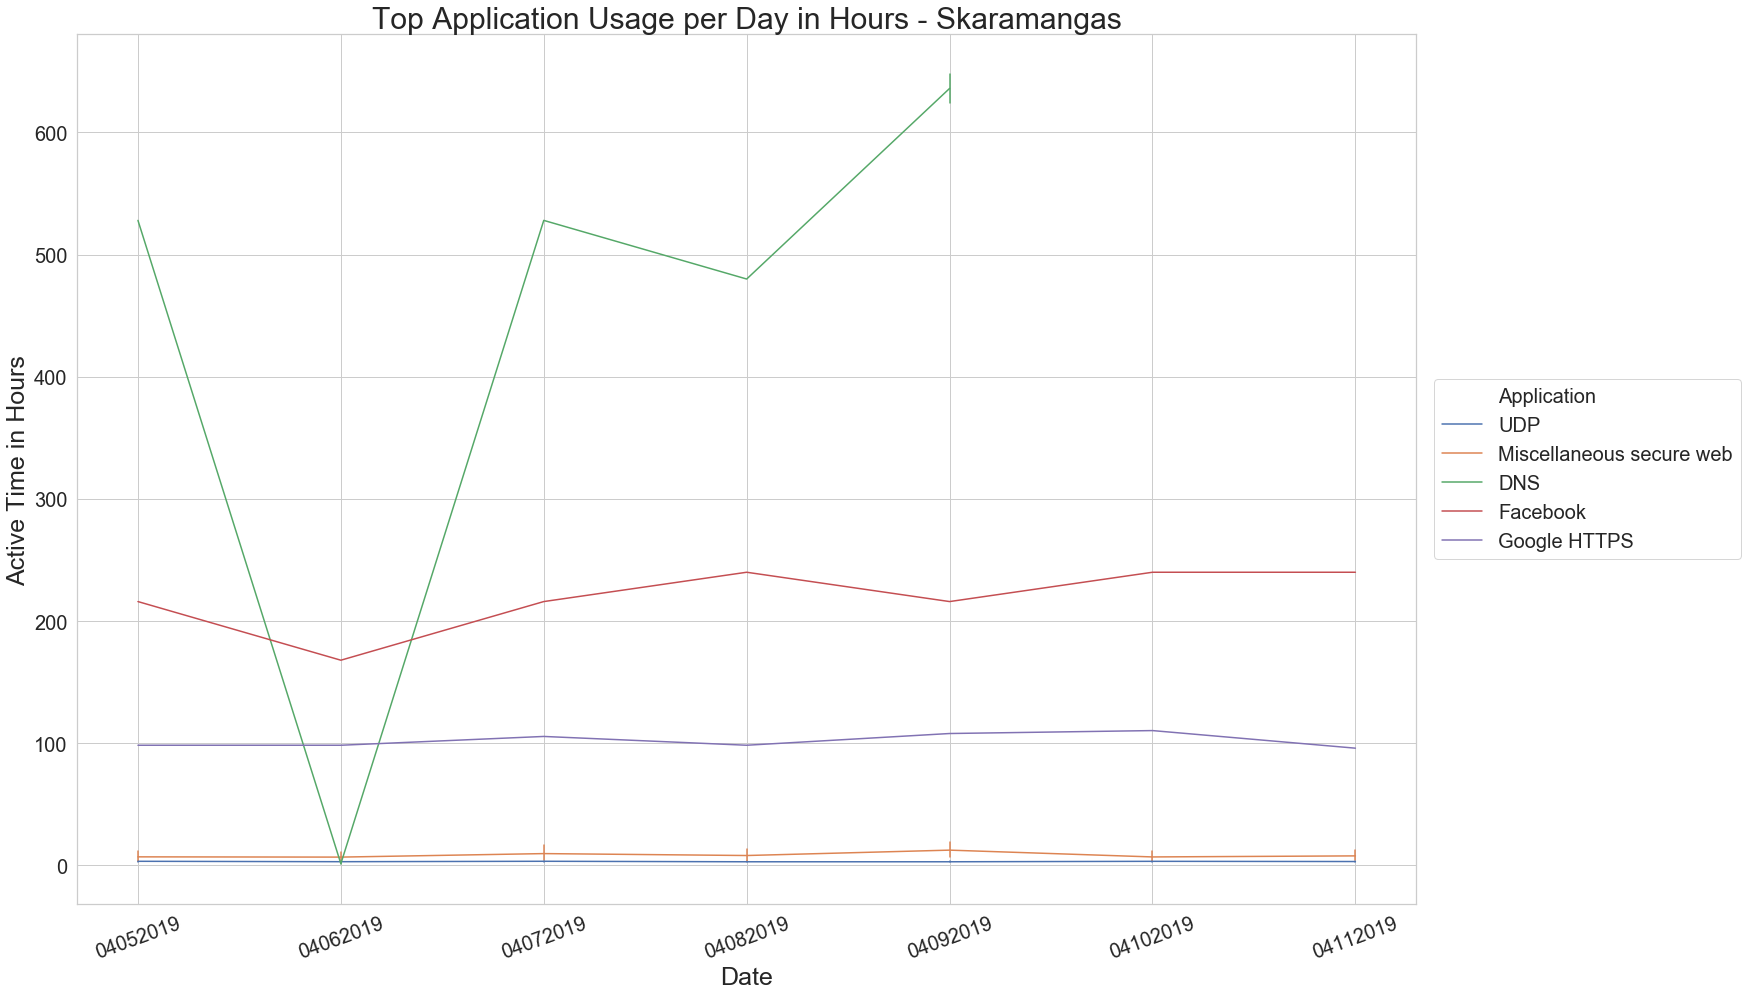

In [48]:
time_app_usage(skaram_top10)
plt.title("Top Application Usage per Day in Hours - Skaramangas", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - Vathi Samos')

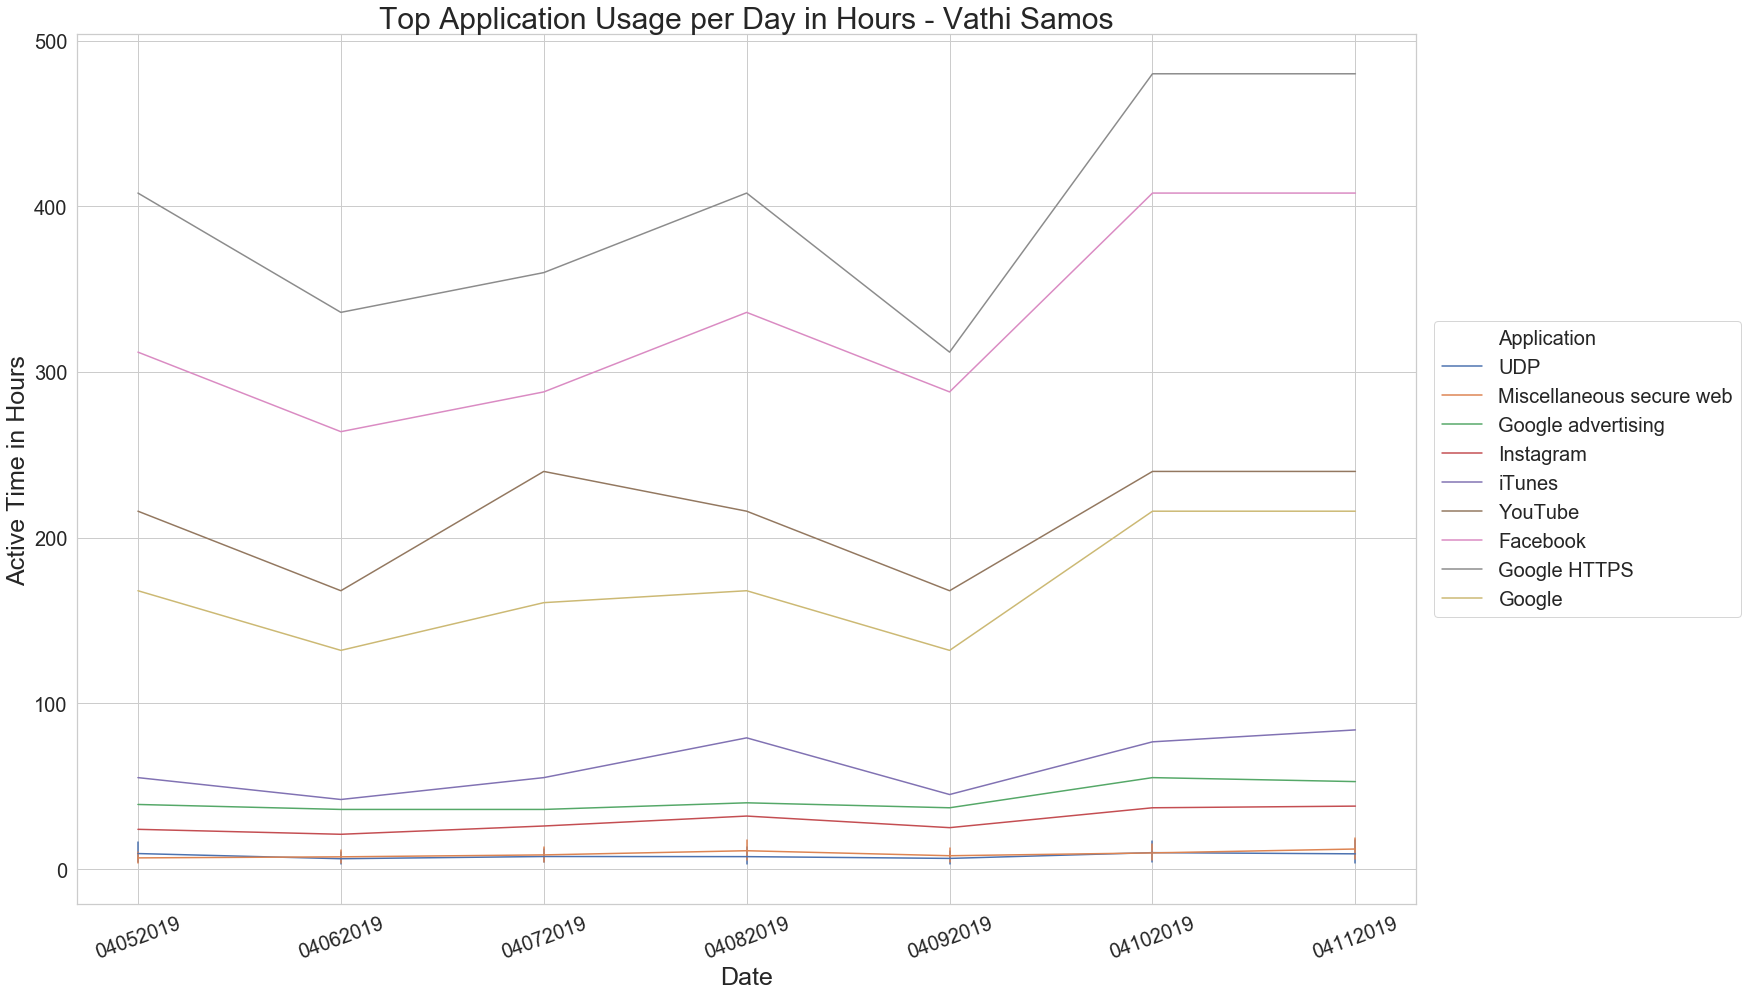

In [49]:
time_app_usage(vathi_top10)
plt.title("Top Application Usage per Day in Hours - Vathi Samos", fontsize=30)

Text(0.5,1,'Top Application Usage per Day in Hours - Veria')

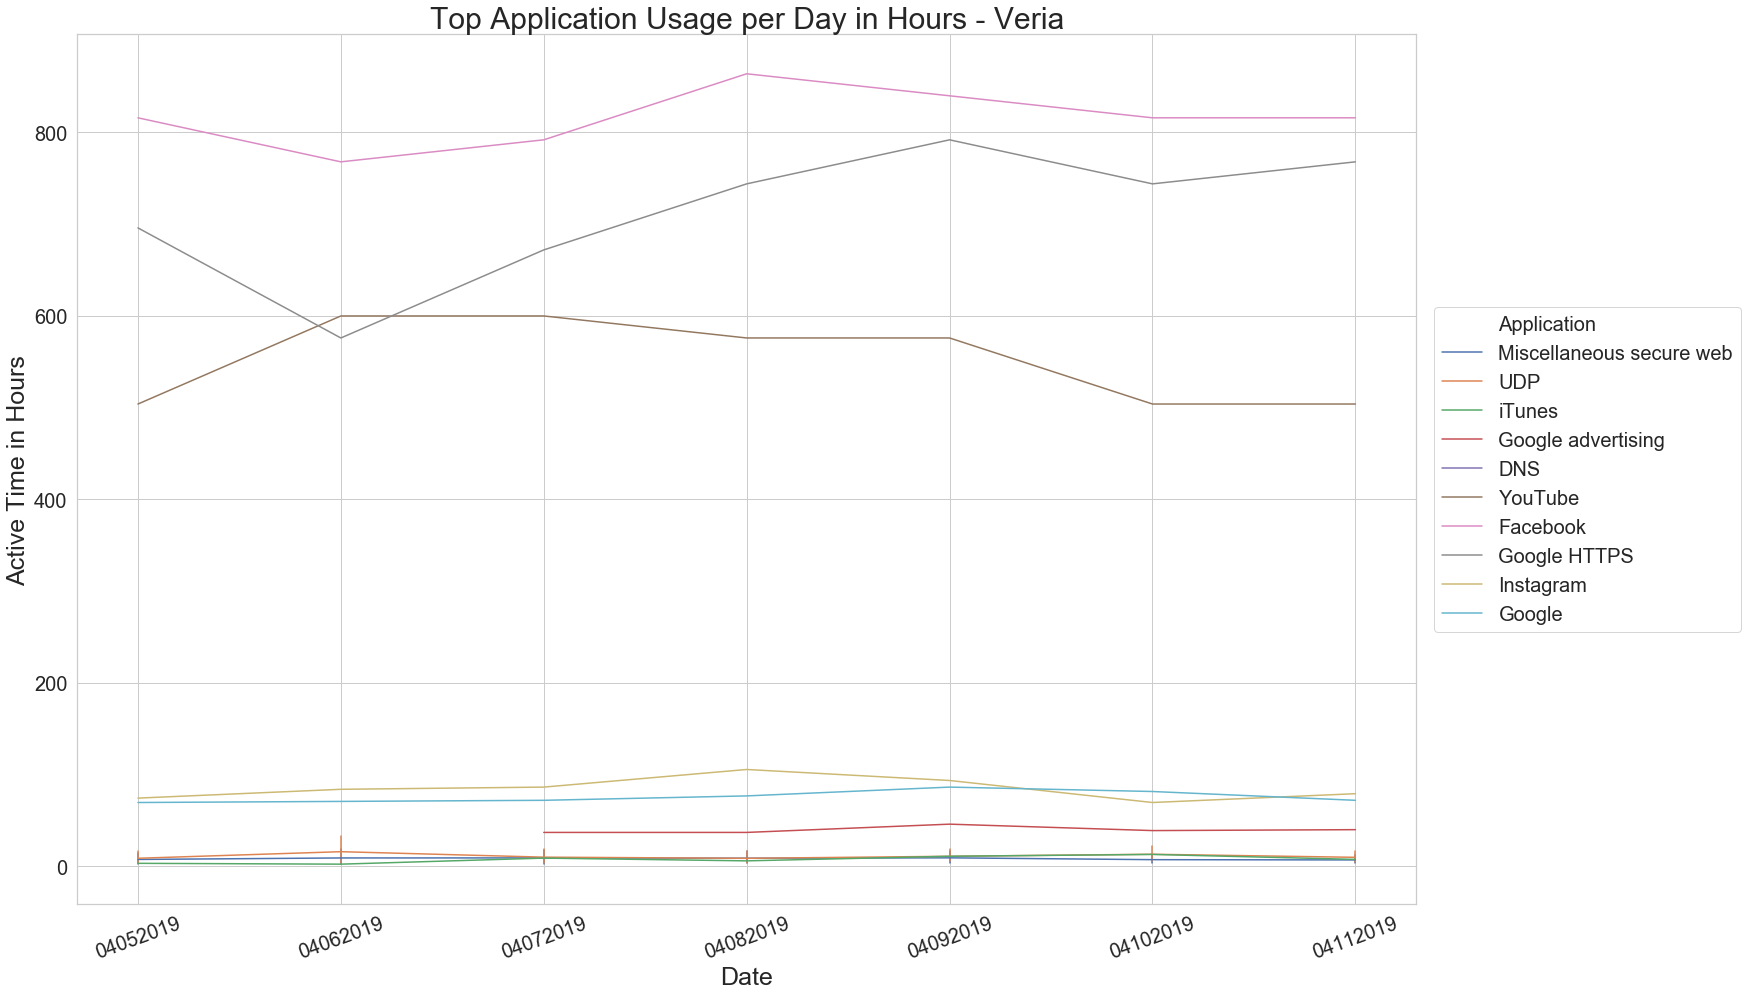

In [50]:
time_app_usage(veria_top10)
plt.title("Top Application Usage per Day in Hours - Veria", fontsize=30)

In [38]:
# top10usageHr_df

In [3]:
# traffic['Hours_per_Client'] = traffic['ActiveTime_hours'].div(traffic['# clients'])

totals = traffic.groupby('Application').sum().reset_index()

totals['Hours_per_Client'] = totals['ActiveTime_hours'].div(totals['# clients']).round(2)

num_clients = totals['# clients'].sum()

totals['app_usage_ratio'] = totals['# clients'].div(num_clients)

totals

In [13]:
totals['# clients'].sum()

225898

## Create .csv of Dataframe: Application Usage (Traffic Analytics)

In [87]:
totals.to_csv('app_usage_perHour_per_client.csv')

In [88]:
# totals = traffic.groupby('Application').sum().reset_index()
# totals.Hours_per_Client = totals.ActiveTime_hours.div(totals['# clients'])
# totals

In [89]:
# traffic[traffic.Application == 'YouTube'].sum()

In [90]:
# app_sum = traffic.groupby(['Application']).sum().reset_index()
# app_sum.Hours_per_Client = app_sum.ActiveTime_hours.div(app_sum['# clients'])
# app_sum['Usage_per_Client'] = app_sum.Usage.div(app_sum['# clients'])
# app_sum

In [91]:
# app_date_sum = traffic.groupby(['Application', 'date']).sum().reset_index()

# app_date.Hours_per_Client = app_date.ActiveTime_hours.div(app_sum['# clients'])
# app_date['Usage_per_Client'] = app_date.Usage.div(app_sum['# clients'])
# app_date_sum

## Create .csv of traffic dataframe

In [33]:
#--Send to .csv file--
traffic.to_csv('7_days_traffic_analytics_usage_per_hour2058.csv')

#### Create separate dataframes for each camp - includes daily application usage from "Traffic analytics"

In [42]:
#--Make DataFrame for each camp--
moria = traffic[traffic['camp_name']=='Moria']
kos = traffic[traffic['camp_name']=='Kos']
nea = traffic[traffic['camp_name']=='Nea']
skaram = traffic[traffic['camp_name']=='Skaram']
vathi = traffic[traffic['camp_name']=='Vathi']
veria = traffic[traffic['camp_name']=='Veria']

#### value_counts( ) shows that you can not take the mean value for each Application
- have to sum all Applications of same type
- then can take mean for each Application's usage across 7 days

In [12]:
# moria.Application.value_counts()

In [13]:
# traffic.columns

#### Functions to create: 
- 1. Time Series of Application Active time usage over 7 days 
- 2. Barplot of top 10 applications used, measure by Active time in hours 

In [73]:
#--Time Series for Application Usage per camp-- 
def time_app_usage(camp):
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(24,16))
#     sns.color_palette("hls")
    ax = sns.lineplot(x="date", y='ActiveTime_hours', hue="Application", 
                 data=camp, err_style="bars", color='hls', ci=0)

    
#     ax.legend(loc='upper left', fontsize=10,bbox_to_anchor=(0, 1.1))
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=20) #--legend
    ax.axes.set_title('Total Application Usage per Day in Hours - ' + camp['camp_name'].unique()[0],fontsize=35)
    ax.set_xlabel('Date',fontsize=25);
    ax.set_ylabel('Active Time in Hours',fontsize=25)
    ax.tick_params(labelsize=20)
    plt.xticks(rotation=20)

    
    
    
#--barplot of usage per camp - top 10 applications-- 
def bar_top10(camps):
    grouped = camps.groupby(['Application']).sum()
    grouped = grouped.reset_index()
    # grouped
    grouped = grouped.sort_values('ActiveTime_hours', ascending=False)
    grouped = grouped[:10]
    grouped = grouped.reset_index()

    app_lst = list(grouped.Application) #--get list of application names in top 10 
    camp1 = camps[camps.Application.isin(app_lst)] #--get new dataframe with only top 10 applications

    camp = camp1.groupby(['date','Application']).sum()
    camp = camp.reset_index()

    equals7 = camp.Application.value_counts().index[camp.Application.value_counts() >2]

    camp = camp[camp.Application.isin(equals7)]
    camp['camp_name'] = camp1['camp_name'].unique()[0]
    camp.Application = camp.Application.astype("category")
    camp.Application.cat.set_categories(app_lst, inplace=True)
    camp = camp.sort_values(['Application'])


    sns.set(style="whitegrid", font_scale = 2)
    plt.figure(figsize=(25,12))
    plt.title('Total Application Usage in Hours Over One Week - ' + camp['camp_name'].unique()[0], fontsize=30)
    sns.barplot(y='Application', x='ActiveTime_hours', data=camp, orient='h', color='b')

    plt.xlabel("Total Active Time in Hours")
    plt.ylabel("")  


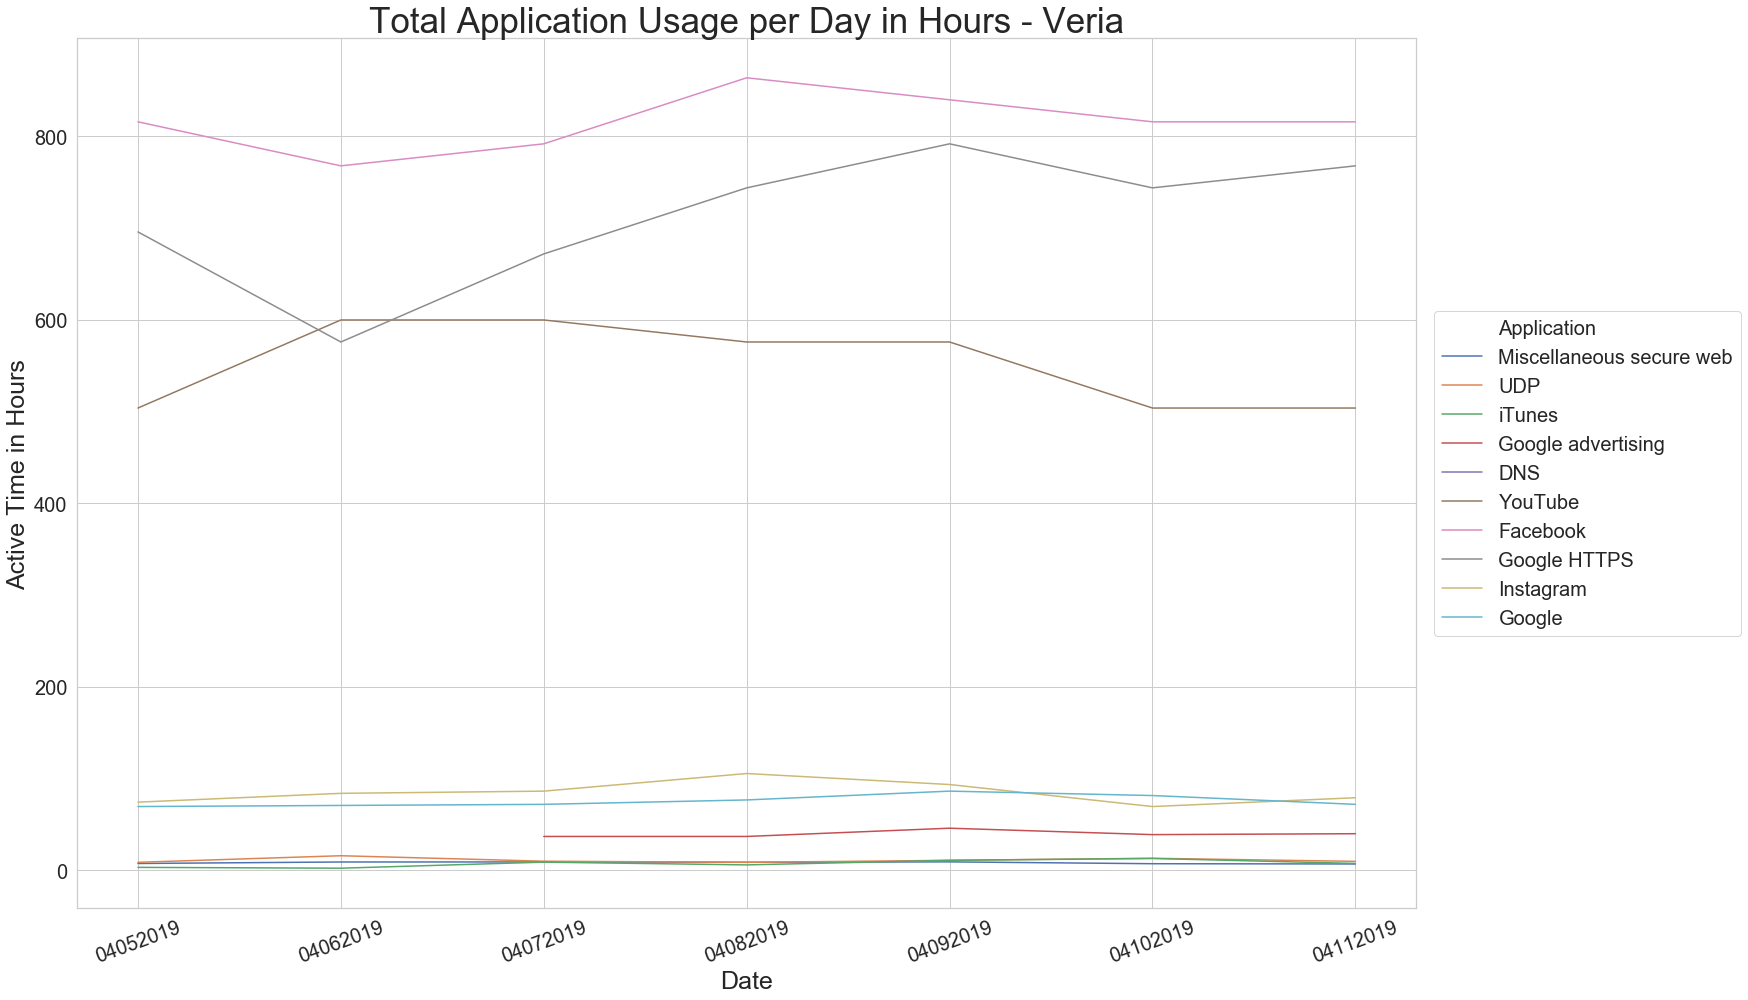

In [74]:
time_app_usage(veria_top10)

#### Functions to create:
- 1. Time series
- 2. Barplot of top 10 applications measure by usage in Active time hours per client (or per device using the client)

In [13]:
#--Time Series for Application Usage per camp-- 
def per_client_usage(camp):
    sns.set()
    plt.figure(figsize=(24,16))
    plt.title('Total Application Usage per Day in Active Hours per Client ' + camp['camp_name'].unique()[0])
    sns.lineplot(x="date", y='Hours_per_Client', hue="Application", 
                 data=camp)
    plt.xticks(rotation=30)
    
#--barplot of usage per camp - top 10 applications-- 
def bar_top10_hrs_per_client(camps):
    grouped = camps.groupby(['Application']).sum()
    grouped = grouped.reset_index()
    # grouped
    grouped = grouped.sort_values('Hours_per_Client', ascending=False)
    grouped = grouped[:10]
    grouped = grouped.reset_index()

    app_lst = list(grouped.Application) #--get list of application names in top 10 
    camp1 = camps[camps.Application.isin(app_lst)] #--get new dataframe with only top 10 applications

    camp = camp1.groupby(['date','Application']).sum()
    camp = camp.reset_index()

    equals7 = camp.Application.value_counts().index[camp.Application.value_counts() ==7]

    camp = camp[camp.Application.isin(equals7)]
    camp['camp_name'] = camp1['camp_name'].unique()[0]
    camp.Application = camp.Application.astype("category")
    camp.Application.cat.set_categories(app_lst, inplace=True)
    camp = camp.sort_values(['Application'])
    
    sns.set(style="whitegrid", font_scale = 2)  #--sets white background and font size
    plt.figure(figsize=(25,12))
    plt.title('Application Usage for One Week in Active Hours per Client - ' + camp['camp_name'].unique()[0])
    sns.barplot(y='Application', x='Hours_per_Client', data=camp, orient='h', color='g')  #--horizontal charts

    #--Labels for x and y-axes
    plt.xlabel("Hours Used per Client")
    plt.ylabel("")

In [16]:
# def bar_top10_hrs_per_client(camp):
#     grouped = camp.groupby(['Application']).sum()
#     grouped = grouped.apply(lambda _df: _df.sort_values(['Hours_per_Client'], ascending=False))
# #     grouped = grouped.sort_values('Hours_per_Client', ascending=False)
#     grouped = grouped[:10] #--choose top 10
#     grouped = grouped.reset_index()
    
#     sns.set(style="whitegrid", font_scale = 2)  #--sets white background and font size
#     plt.figure(figsize=(25,12))
#     plt.title('Application Usage for One Week in Active Hours per Client - ' + camp['camp_name'].unique()[0])
#     sns.barplot(y='Application', x='Hours_per_Client', data=grouped, orient='h', color='g')  #--horizontal charts
    
#     #--Code for Vertical Bar Charts--
# #     sns.barplot(x='Application', y='Hours_per_Client', data=grouped) #--vertical charts
# #     plt.xticks(rotation=45)  #--use this for vertical charts only

#     #--Labels for x and y-axes
#     plt.xlabel("Hours Used per Client")
#     plt.ylabel("Application")

# camps = moria
# grouped = camps.groupby(['Application']).sum()
# grouped = grouped.reset_index()
# # grouped
# grouped = grouped.sort_values('ActiveTime_hours', ascending=False)
# grouped = grouped[:10]
# grouped = grouped.reset_index()

# app_lst = list(grouped.Application) #--get list of application names in top 10 
# # app_lst


# camp1 = camps[camps.Application.isin(app_lst)] #--get new dataframe with only top 10 applications
# #     camp = camp.sort_values('ActiveTime_hours', ascending=False)

# camp = camp1.groupby(['date','Application']).sum()
# camp = camp.reset_index()

# # camp.Application.value_counts() = camp.Application[]
# equals7 = camp.Application.value_counts().index[camp.Application.value_counts() >2]

# # camp[camp.Application=='DNS']

# camp = camp[camp.Application.isin(equals7)]

# camp['camp_name'] = camp1['camp_name'].unique()[0]


# camp.Application = camp.Application.astype("category")
# camp.Application.cat.set_categories(app_lst, inplace=True)

# camp = camp.sort_values(['Application'])


# sns.set(style="whitegrid", font_scale = 2)
# plt.figure(figsize=(25,12))
# plt.title('Total Application Usage in Hours Over One Week - ' + camp['camp_name'].unique()[0])
# sns.barplot(y='Application', x='ActiveTime_hours', data=camp, orient='h', color='b')

# plt.xlabel("Total Active Time in Hours")
# plt.ylabel("") 

In [619]:
# camp['camp_name'] = camp1['camp_name'].unique()[0]


# camp.Application = camp.Application.astype("category")
# camp.Application.cat.set_categories(app_lst, inplace=True)

# camp = camp.sort_values(['Application'])


# sns.set(style="whitegrid", font_scale = 2)
# plt.figure(figsize=(25,12))
# plt.title('Total Application Usage in Hours Over One Week - ' + camp['camp_name'].unique()[0])
# sns.barplot(y='Application', x='ActiveTime_hours', data=camp, orient='h', color='b')

# plt.xlabel("Total Active Time in Hours")
# plt.ylabel("Application") 

# 1.a. Total Application Usage Per Day in Hours for all Applications (by Application)
- This includes all Applications, such as Application Protocols and Social Networking Applications
- These charts are not used in the final report

Text(0.5,1,'Total Web Application Usage Over One Week - Six Camps')

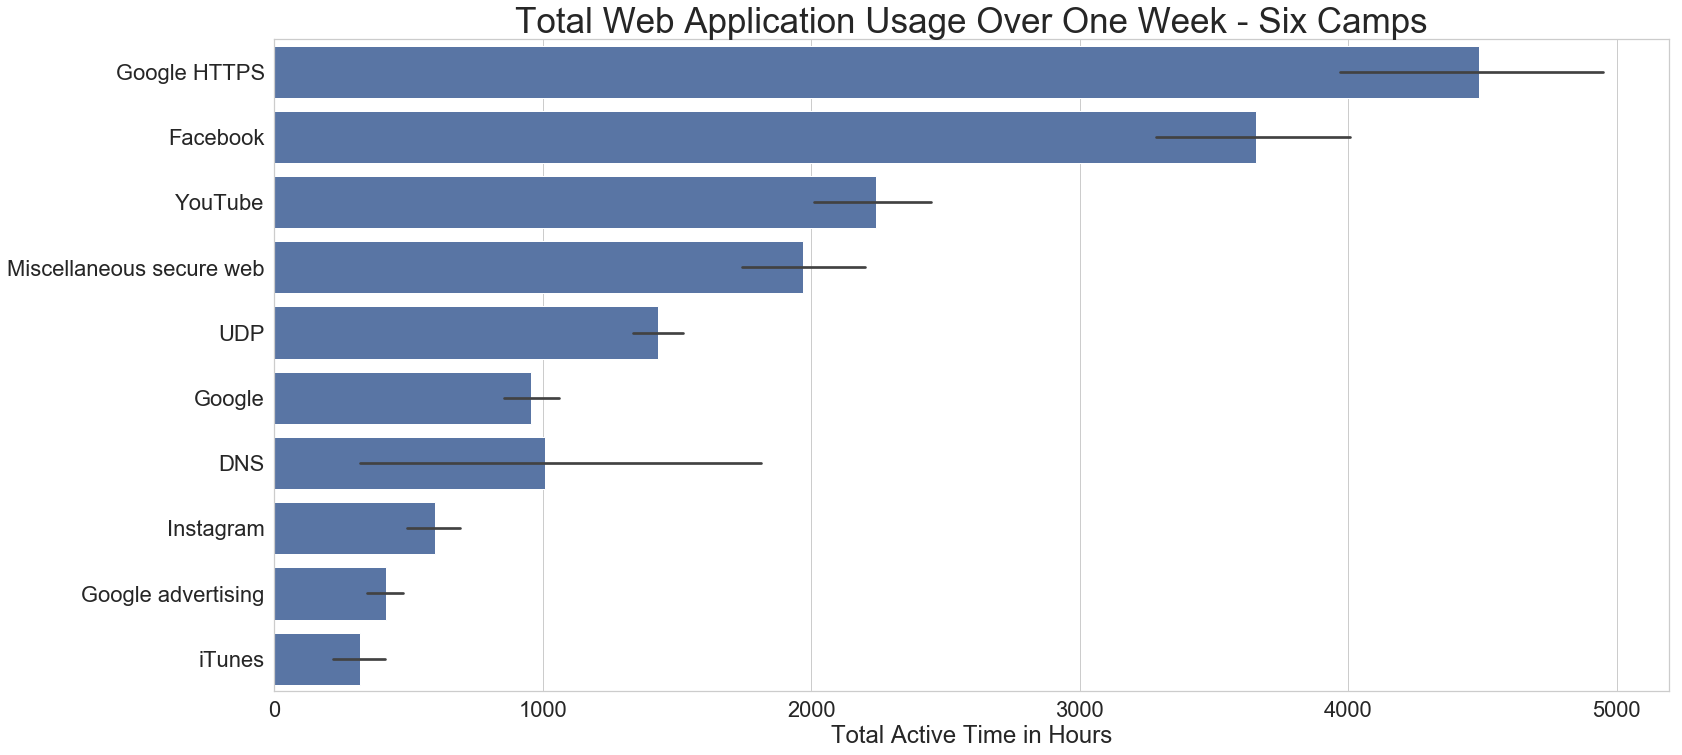

In [101]:
bar_top10(traffic)
plt.title("Total Web Application Usage Over One Week - Six Camps", fontsize=35)

Text(0.5,1,'Total Web Application Usage Over One Week in Hours - Six Camps')

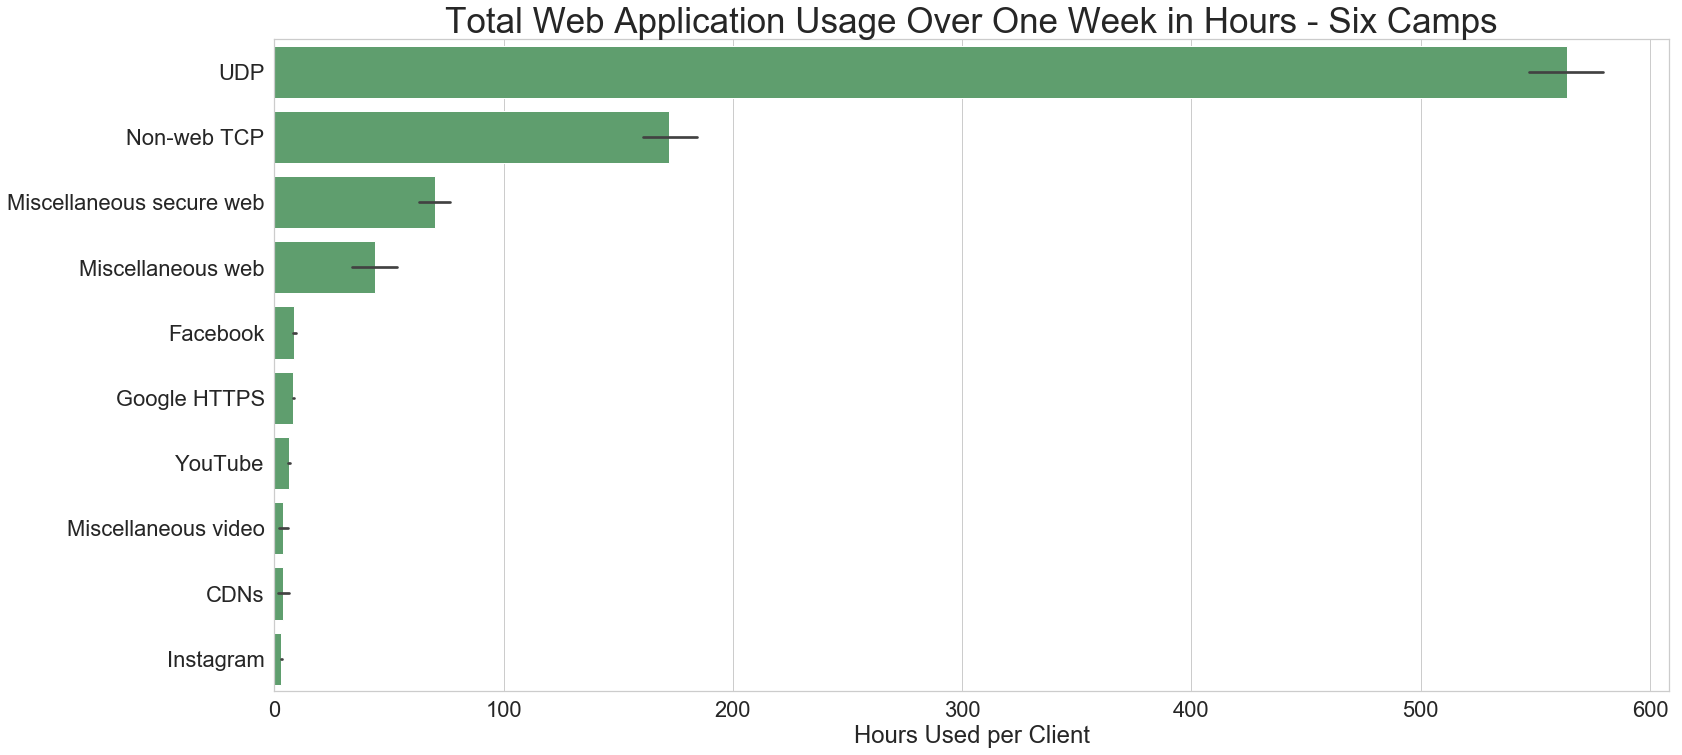

In [14]:
bar_top10_hrs_per_client(traffic)
plt.title("Total Web Application Usage Over One Week in Hours - Six Camps", fontsize=35)

### Kos

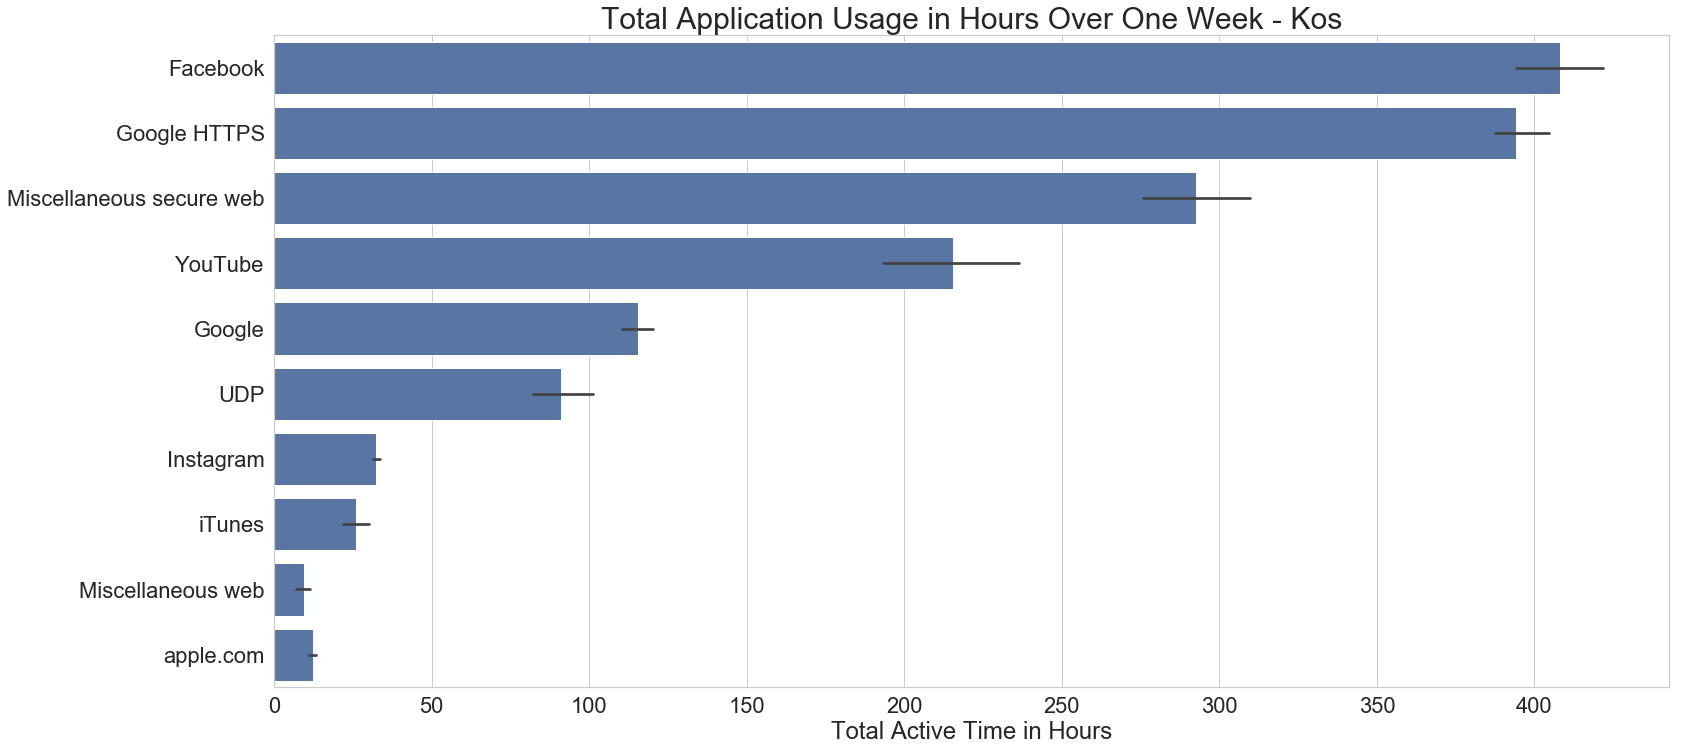

In [25]:
bar_top10(kos)

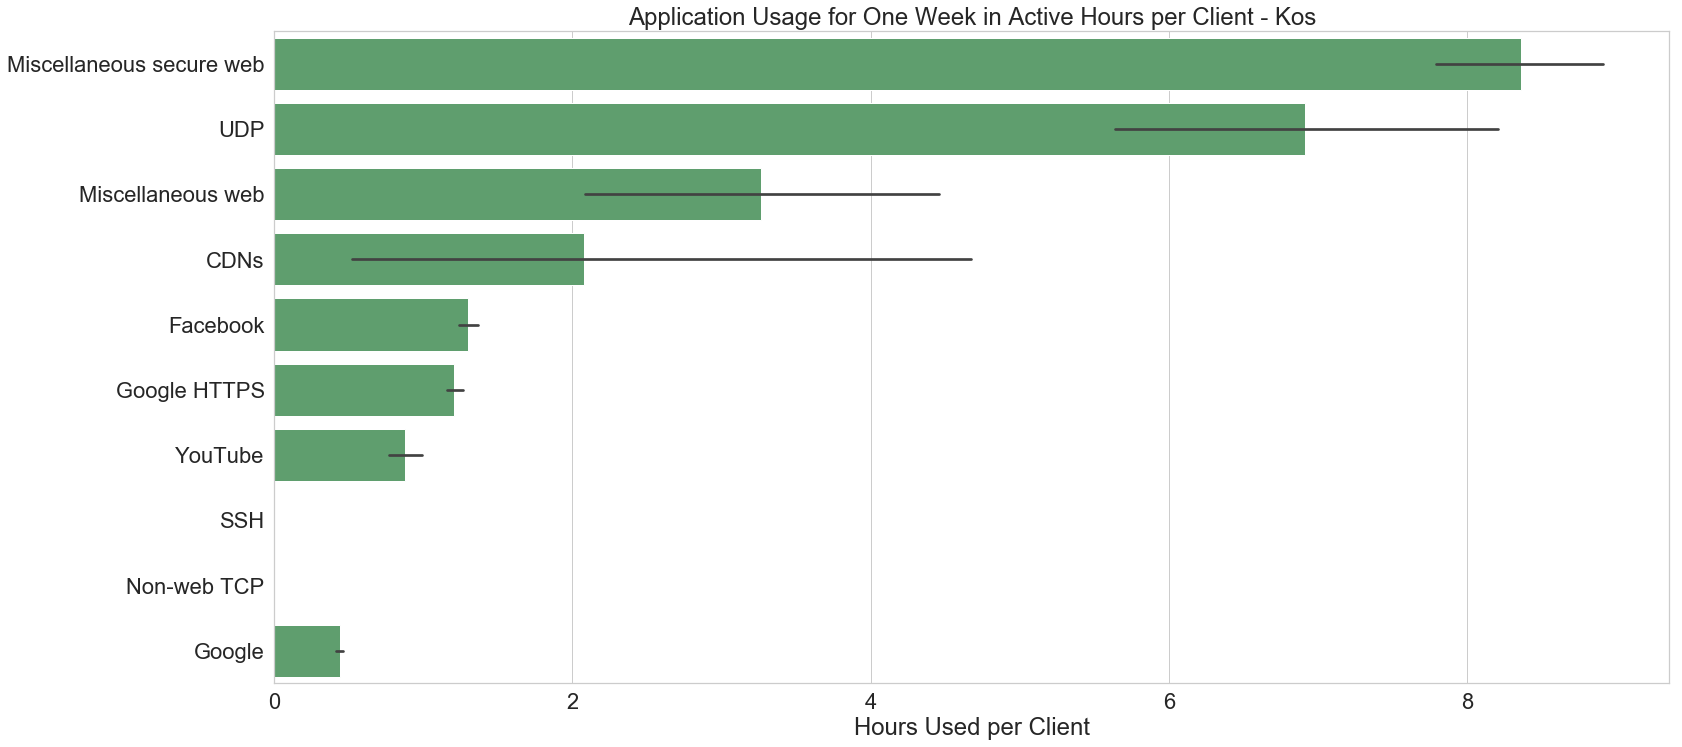

In [43]:
bar_top10_hrs_per_client(kos)

In [4]:
time_app_usage(kos)

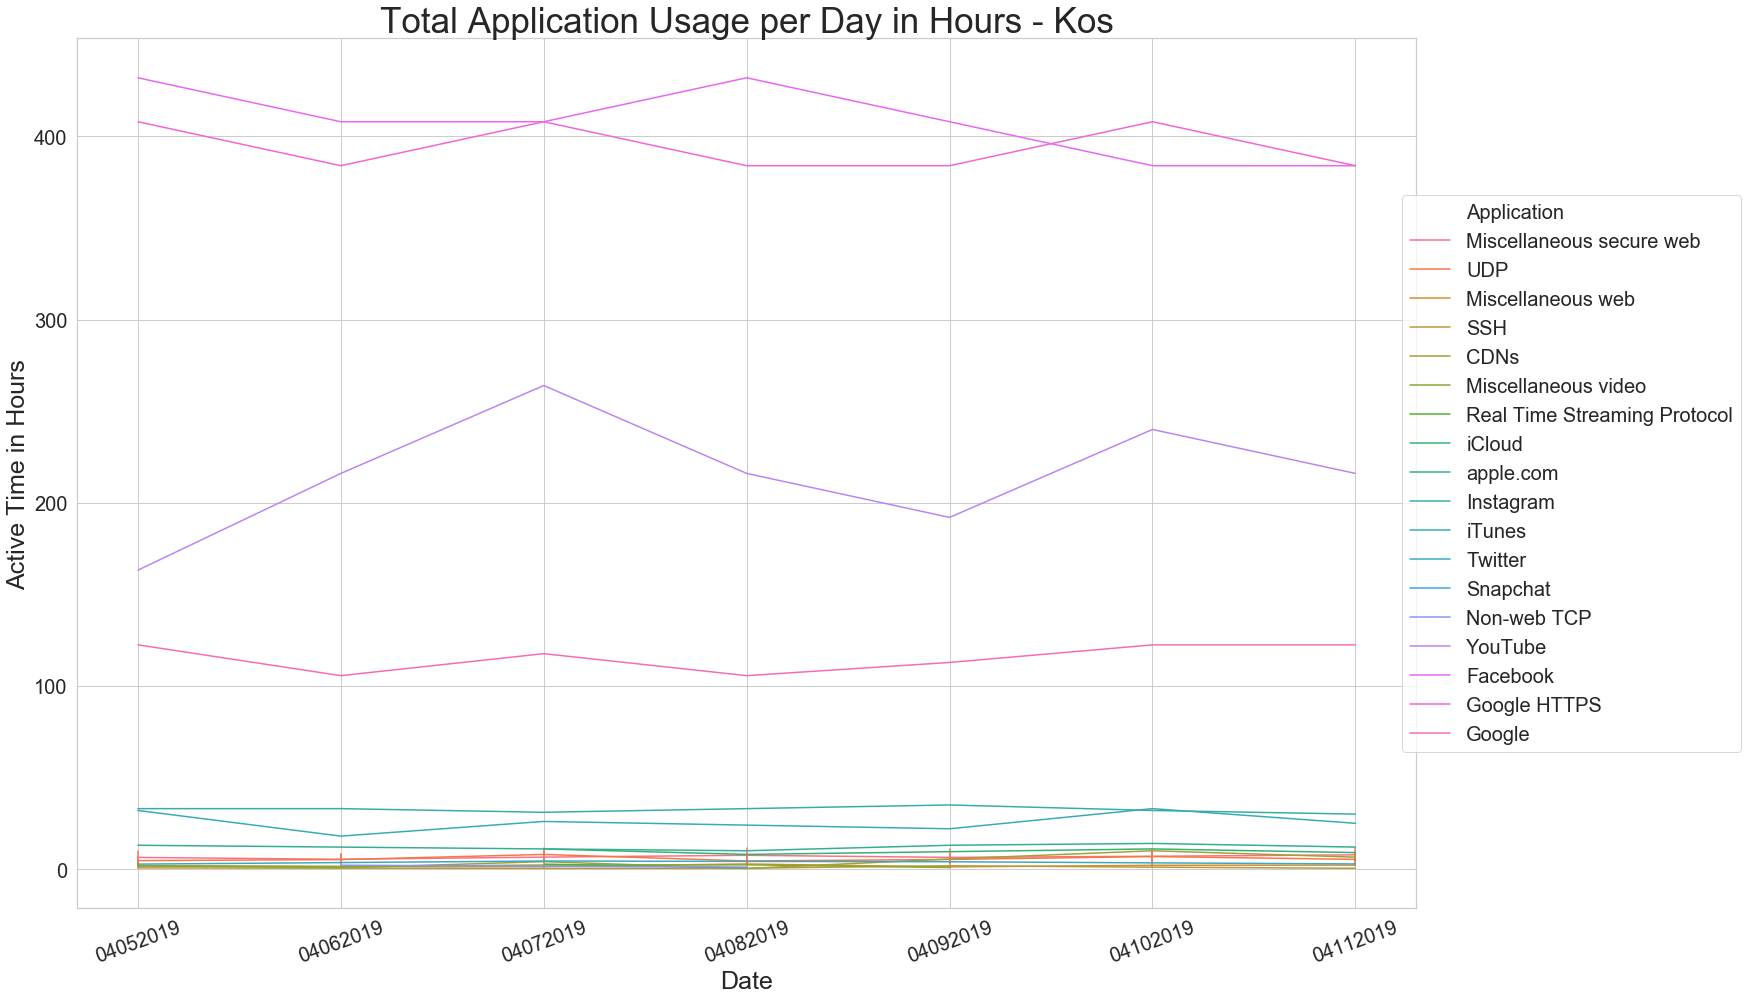

In [36]:
time_app_usage(kos)

### Moria

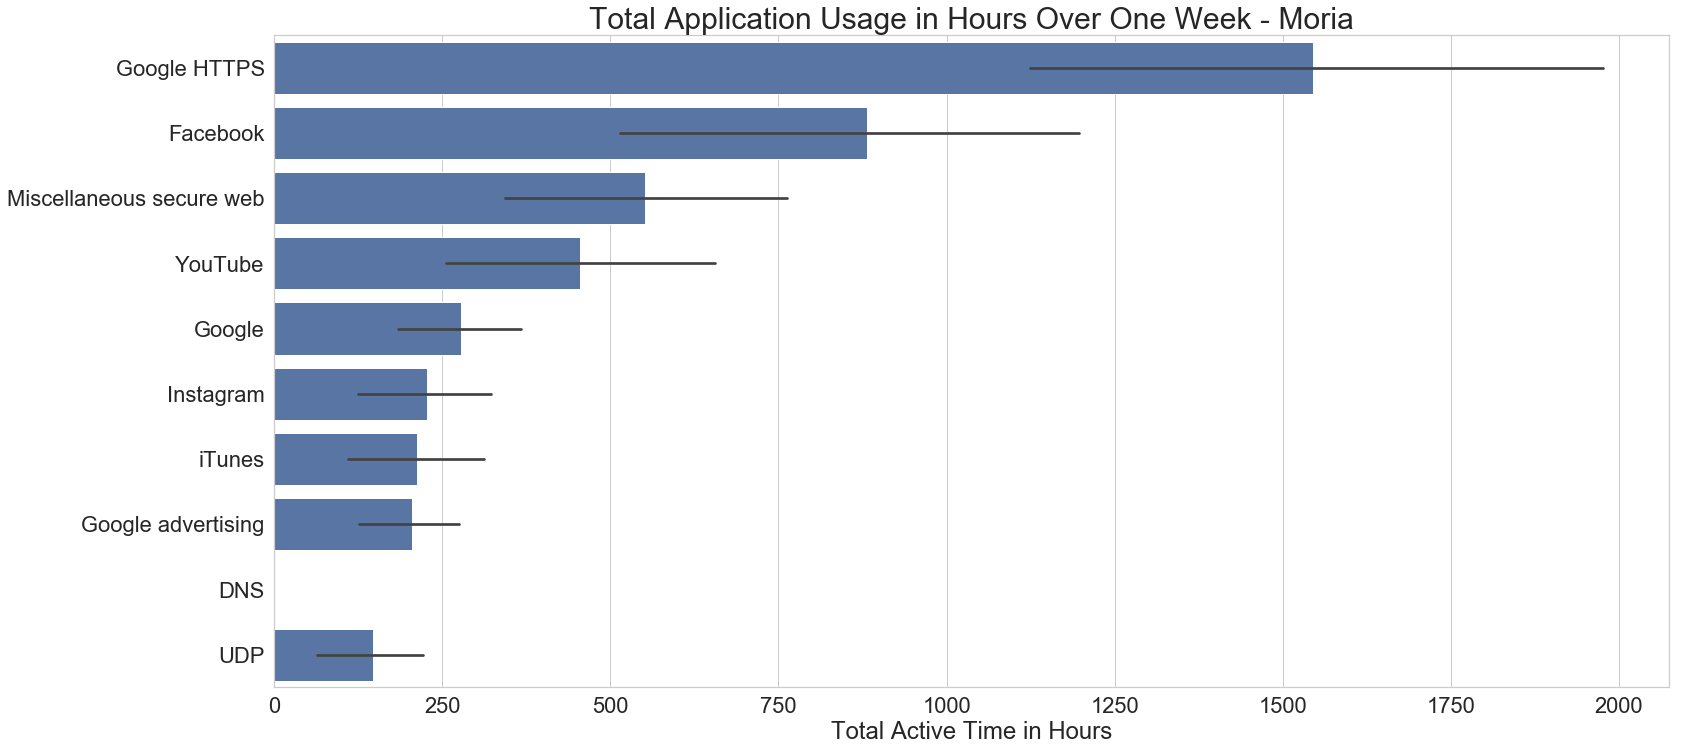

In [37]:
bar_top10(moria)

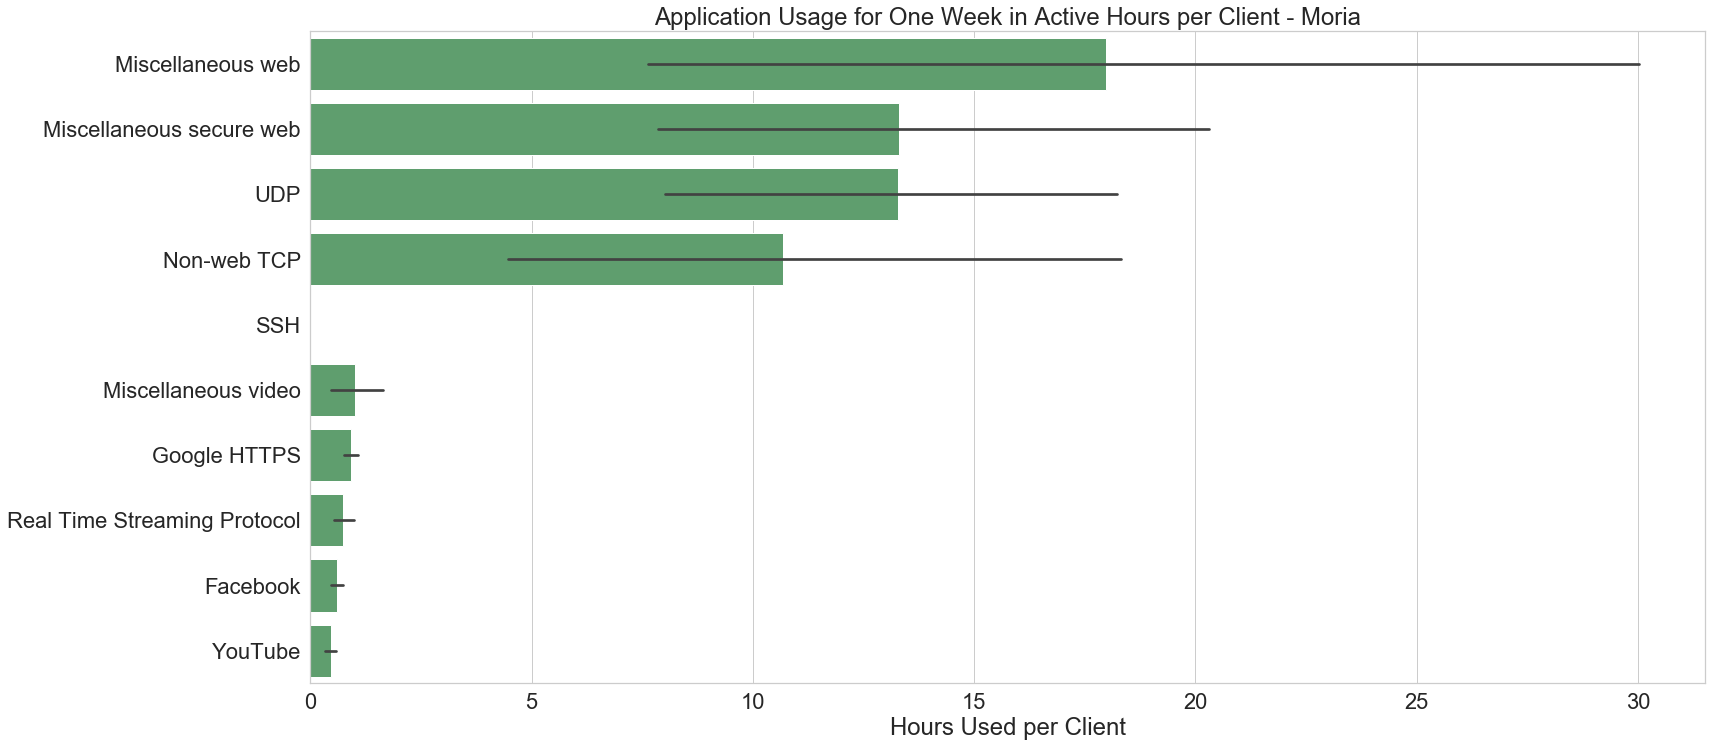

In [44]:
bar_top10_hrs_per_client(moria)

In [5]:
time_app_usage(moria)

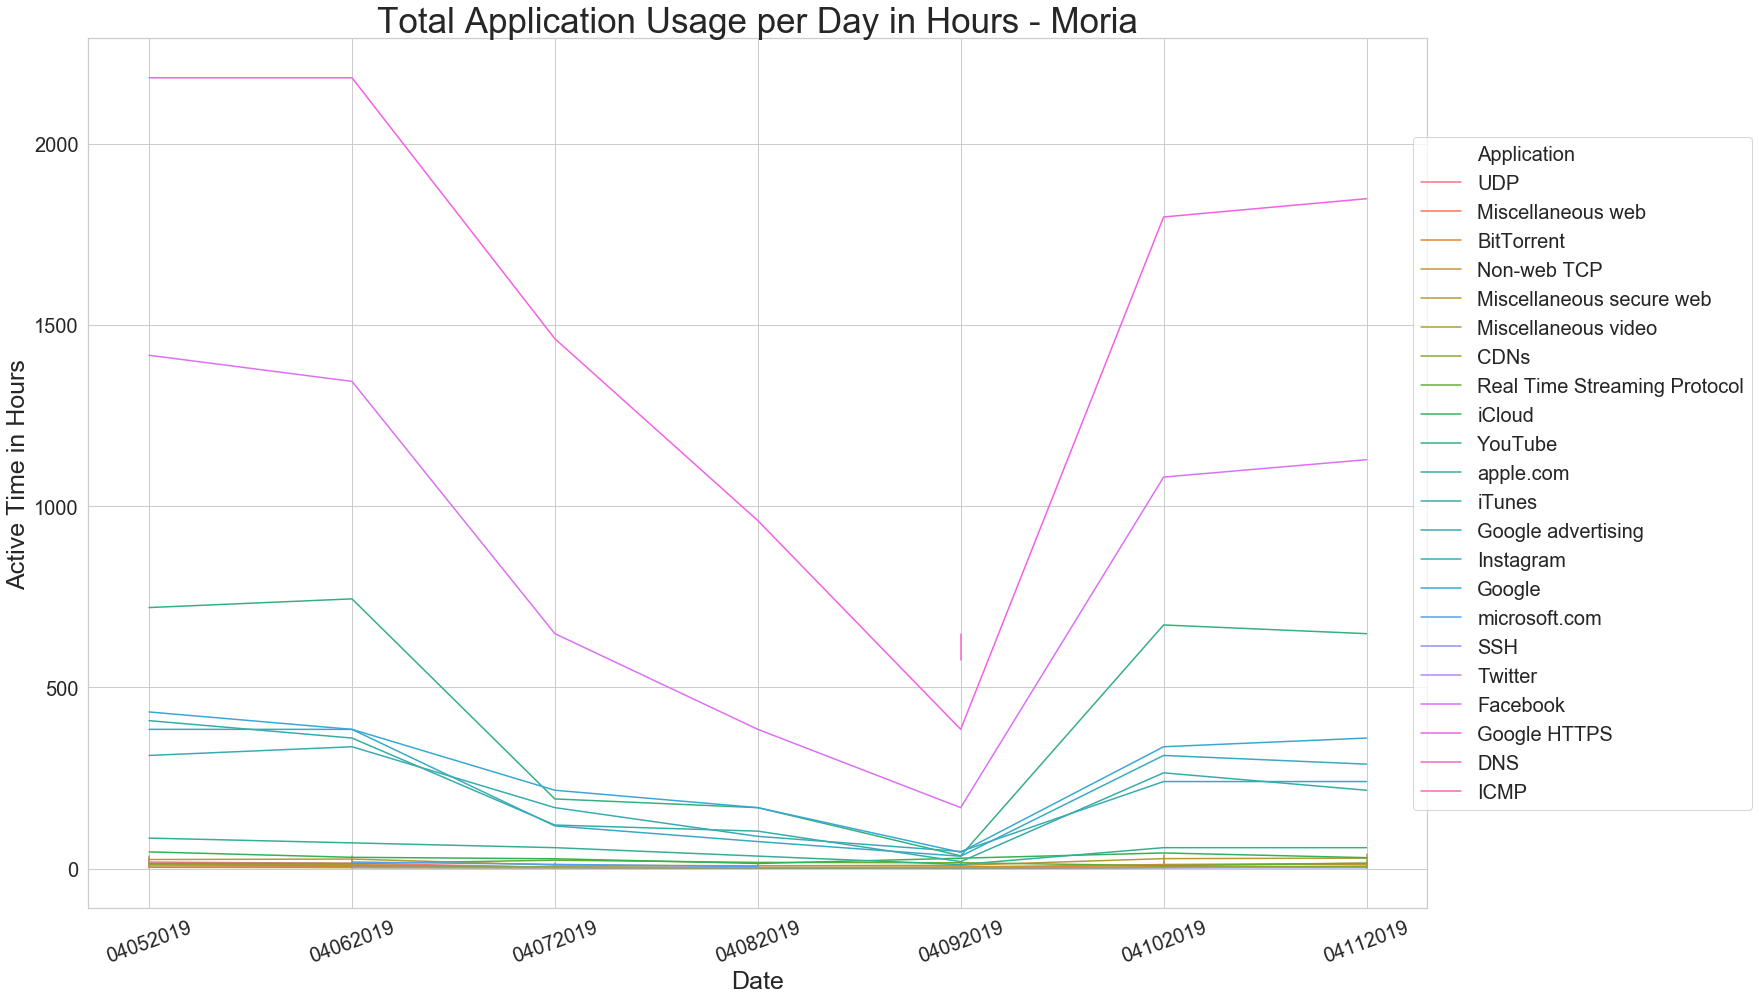

In [45]:
time_app_usage(moria)

### Nea Kavala

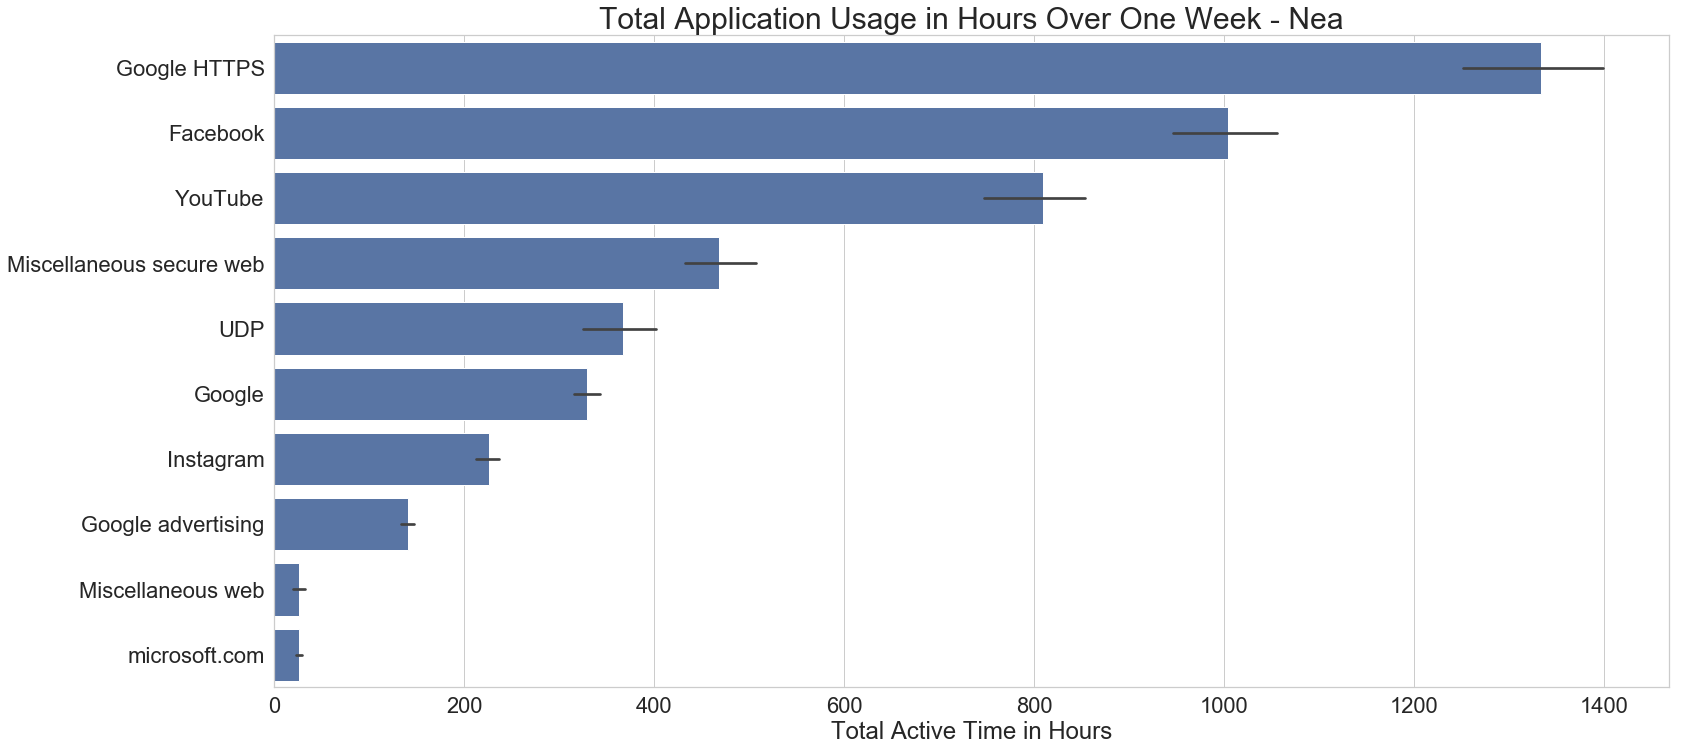

In [39]:
bar_top10(nea)

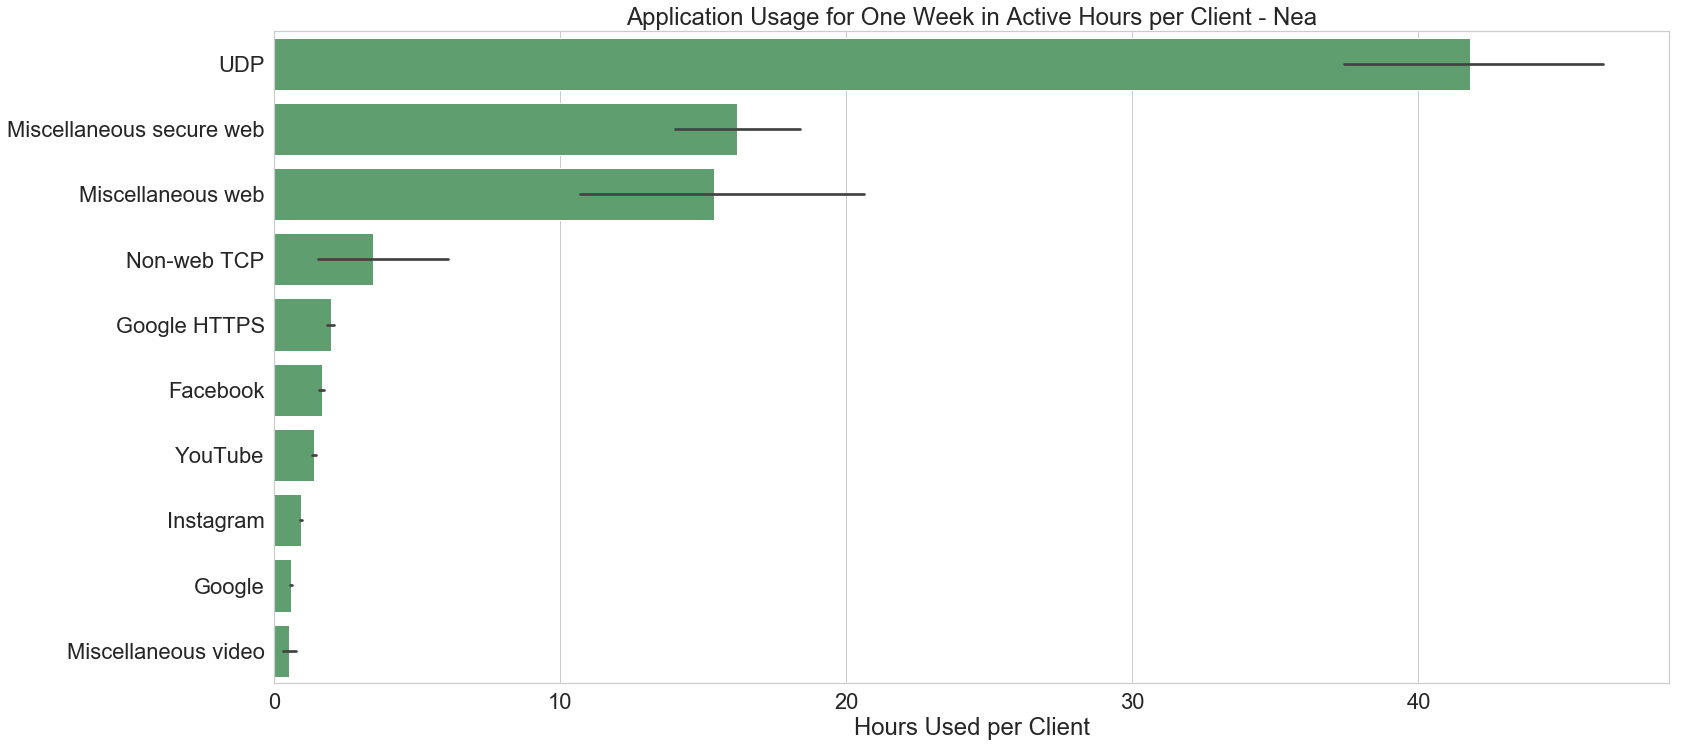

In [46]:
bar_top10_hrs_per_client(nea)

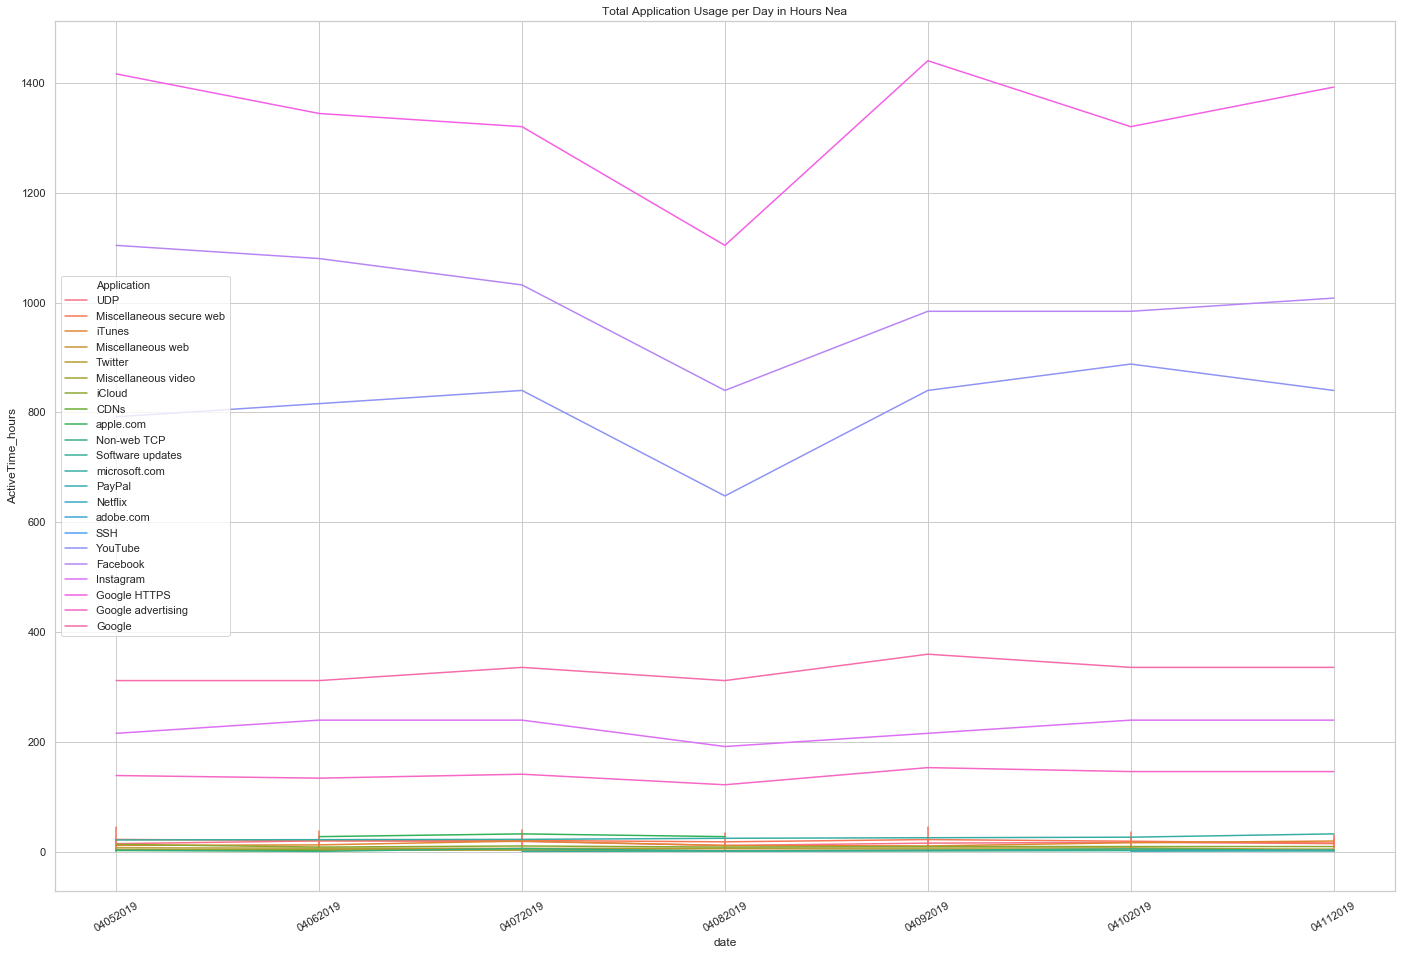

In [407]:
time_app_usage(nea)

### Skaramangas

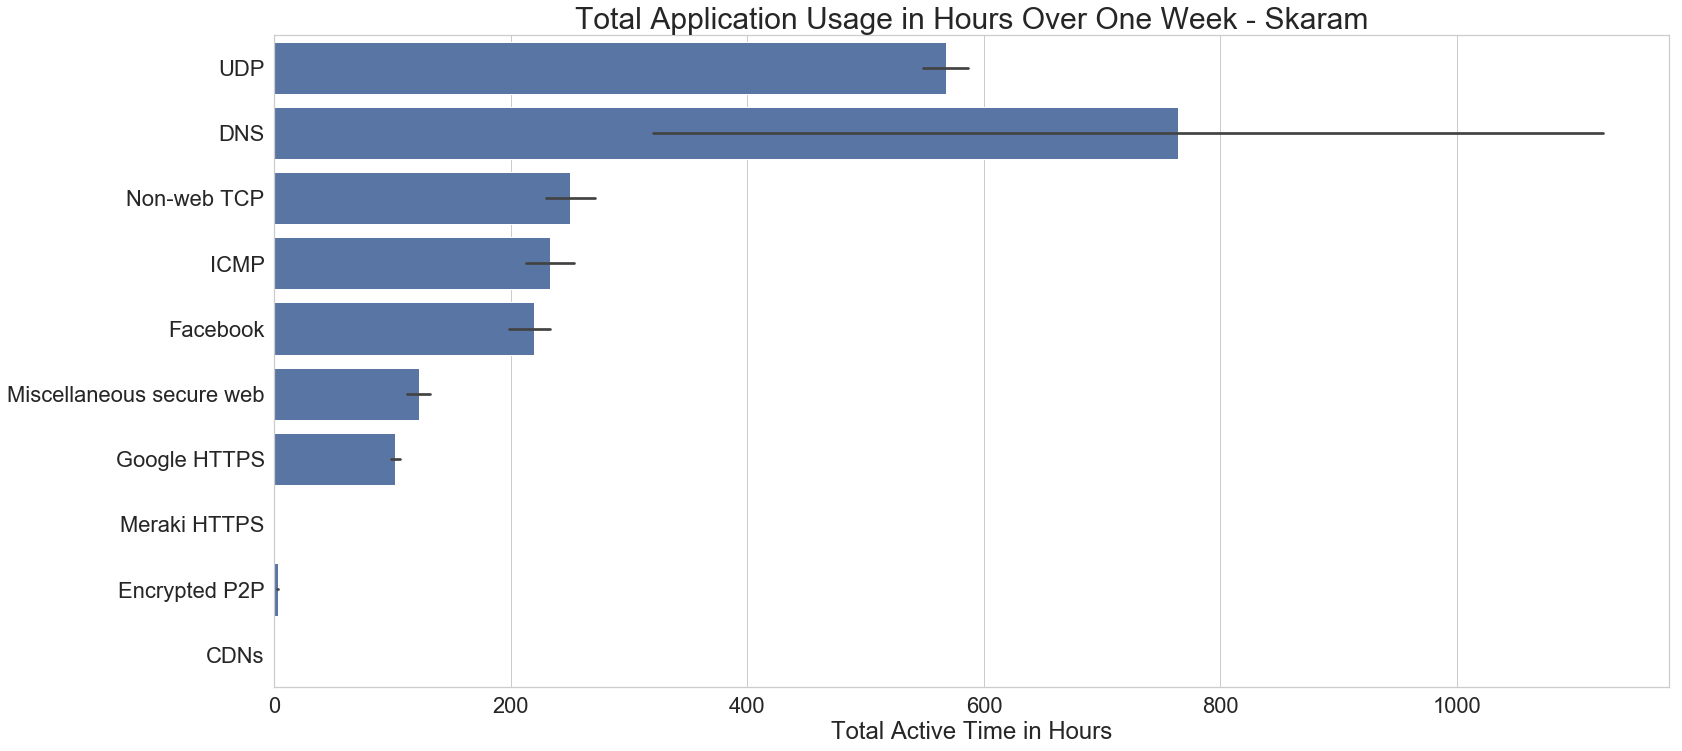

In [47]:
bar_top10(skaram)

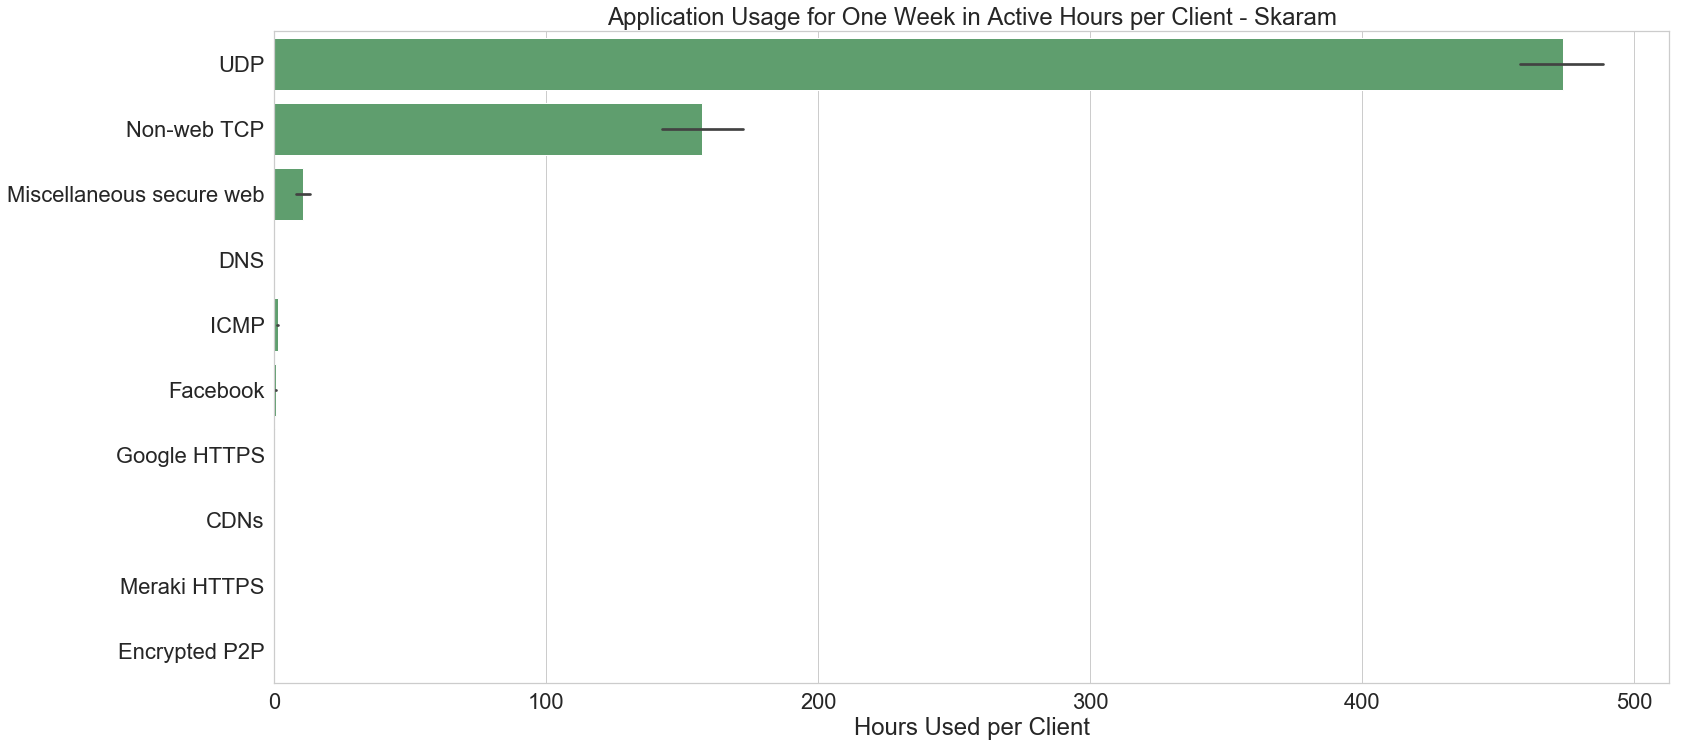

In [48]:
bar_top10_hrs_per_client(skaram)

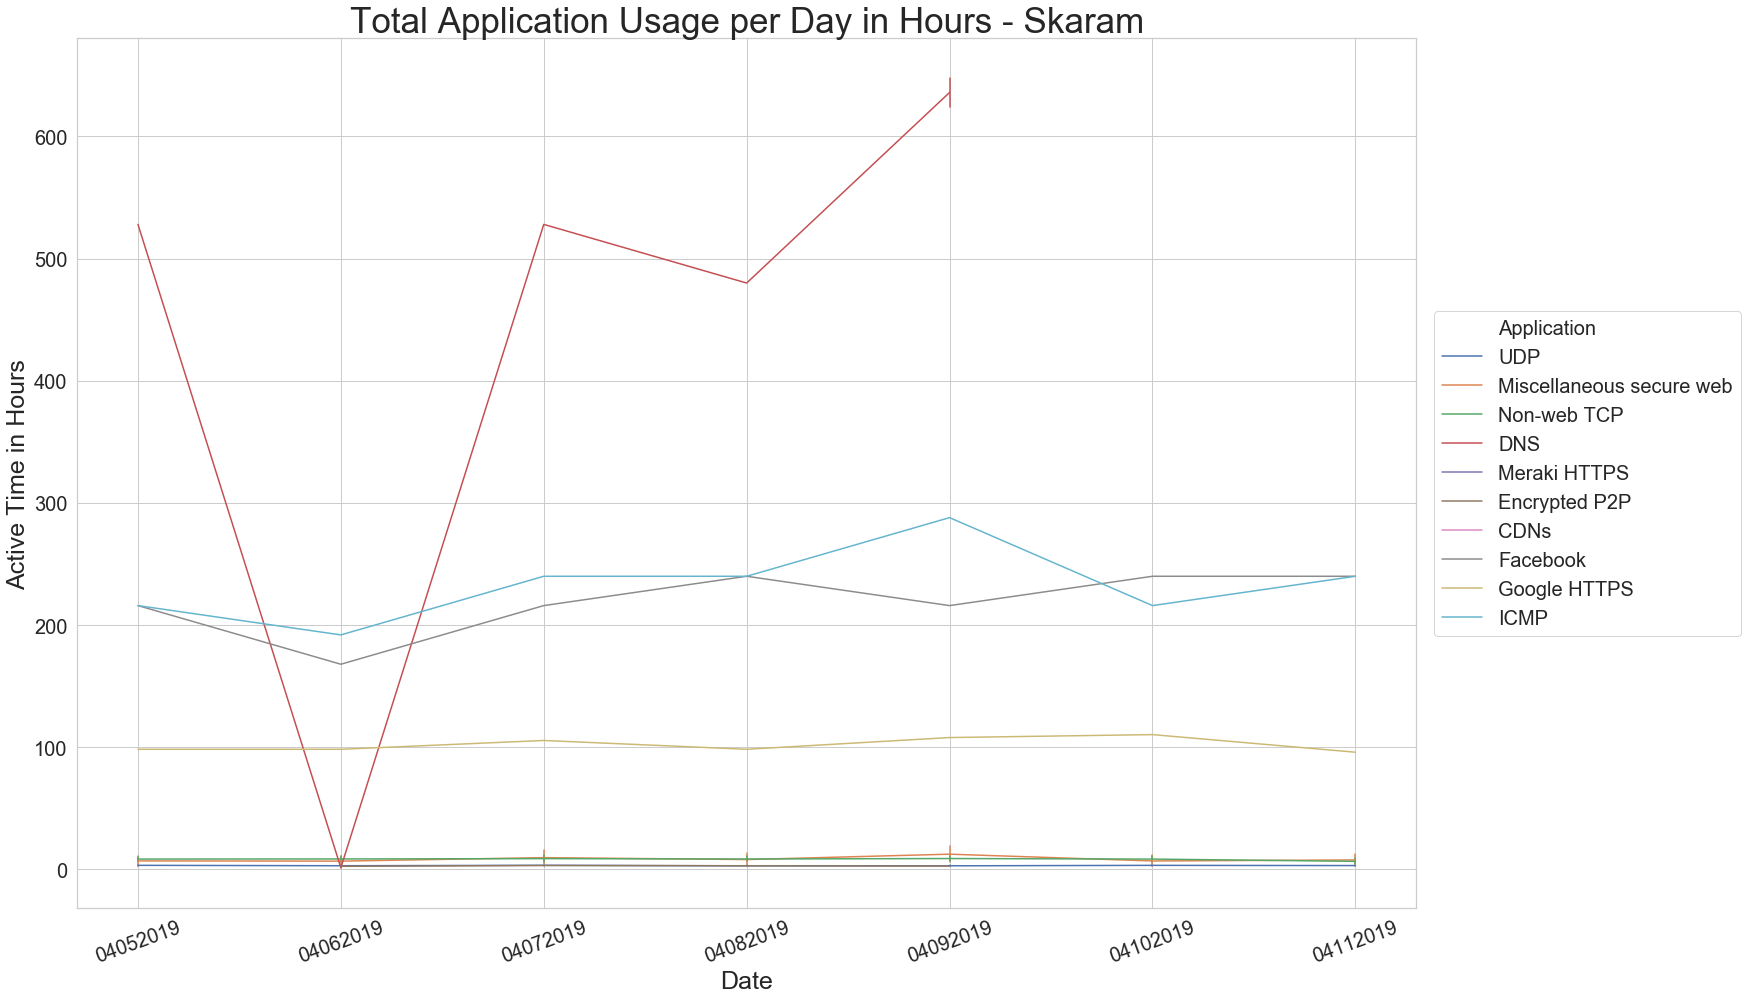

In [41]:
time_app_usage(skaram)

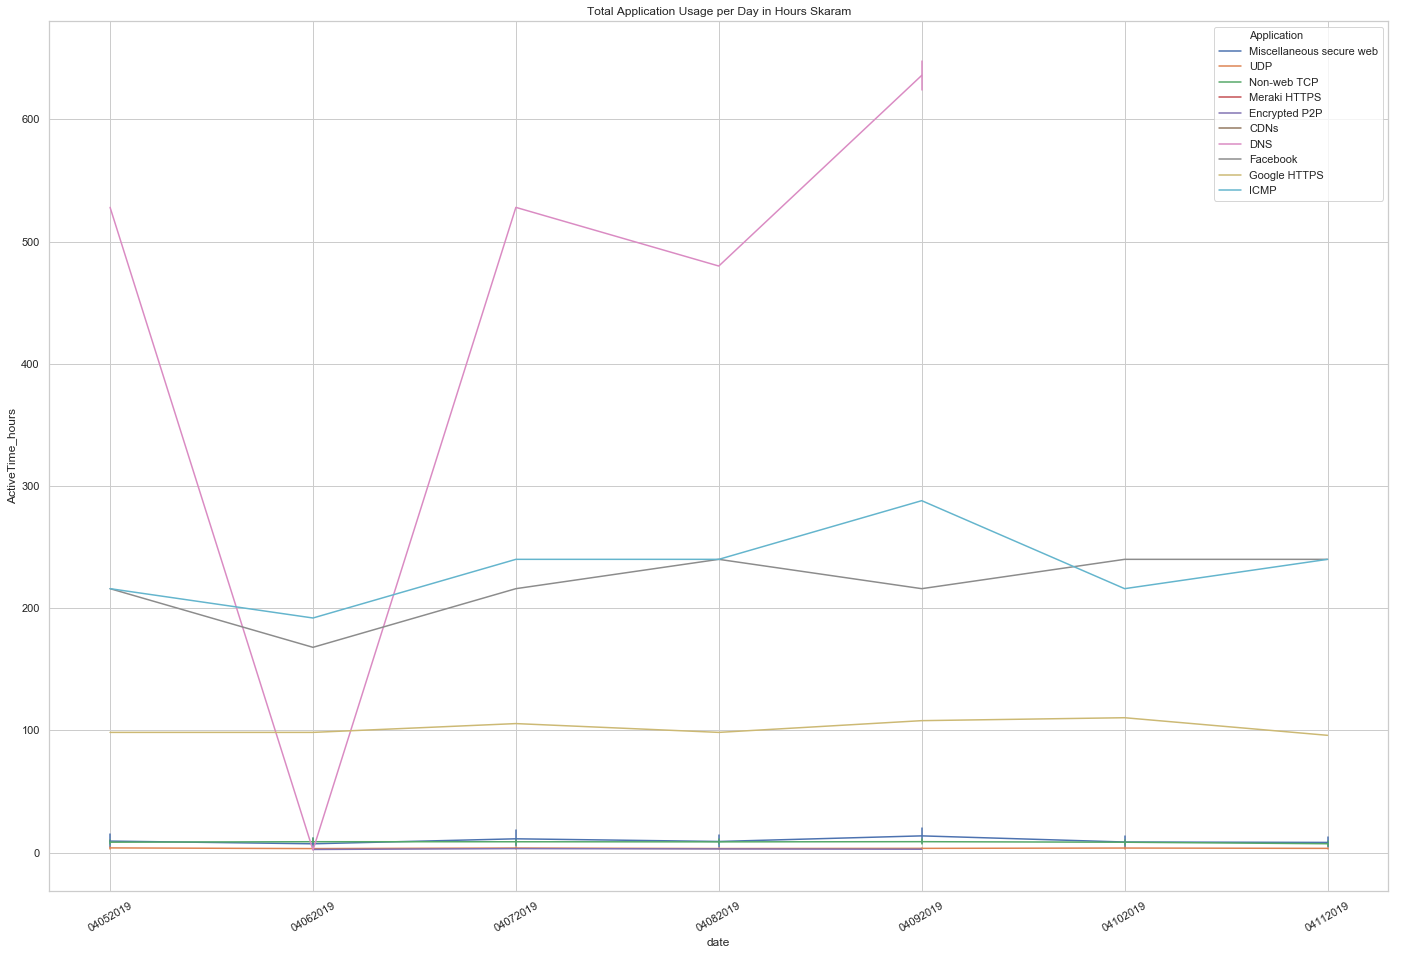

In [408]:
time_app_usage(skaram)

### Vathi Samos

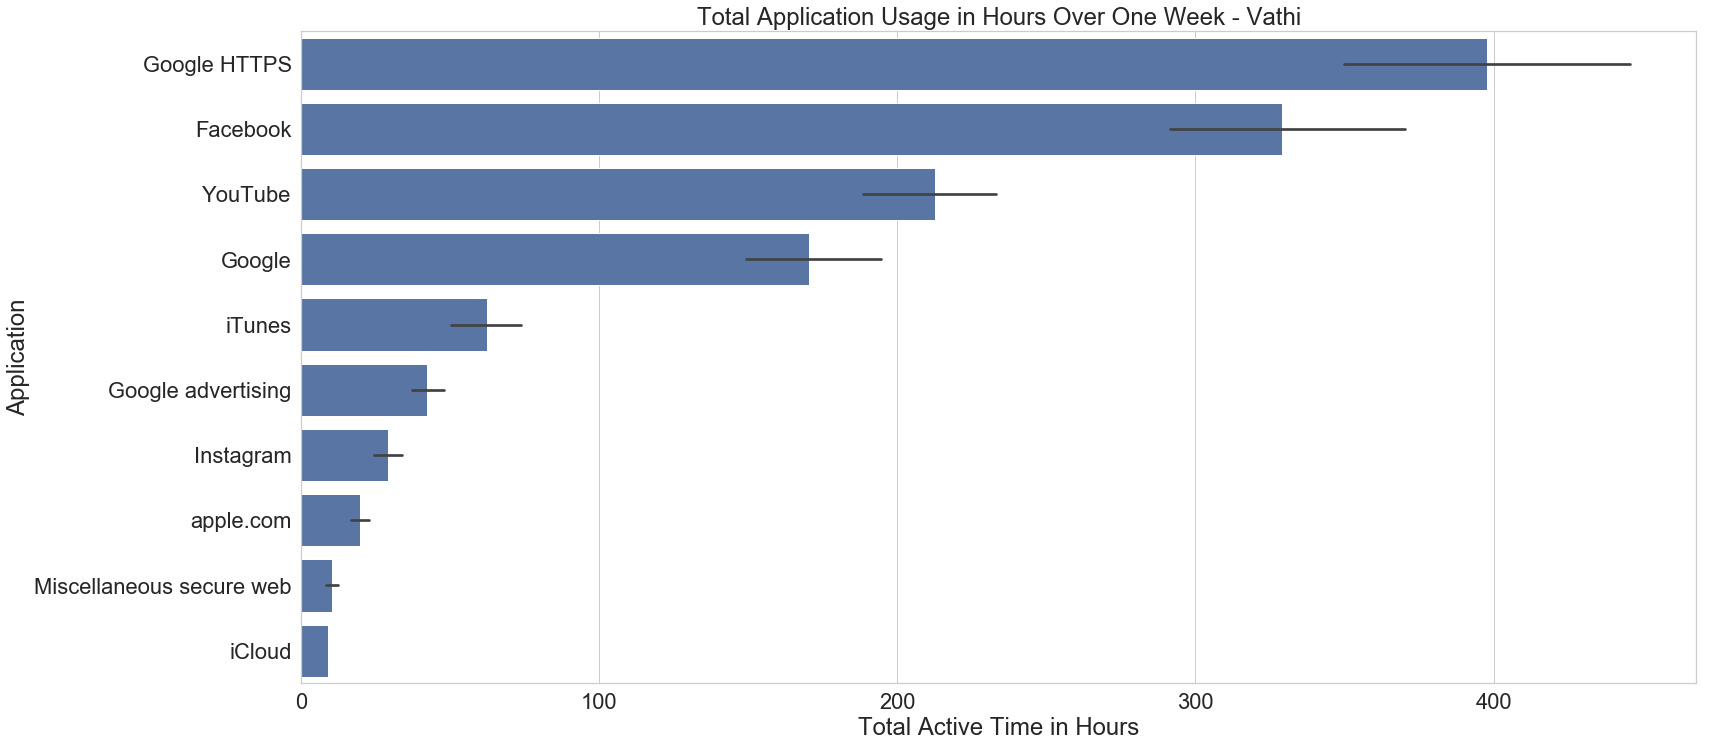

In [467]:
bar_top10(vathi)

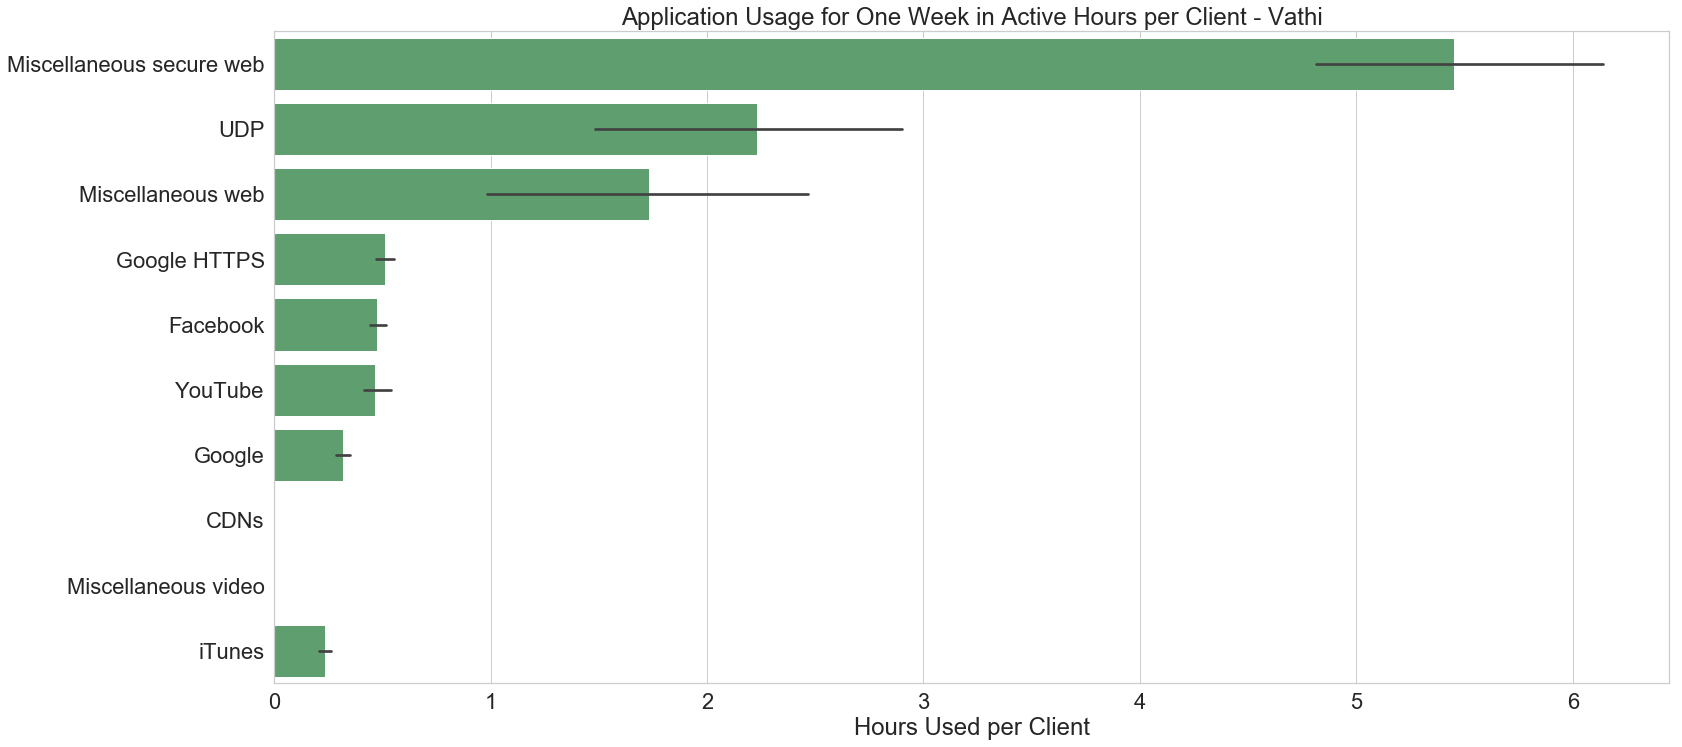

In [49]:
bar_top10_hrs_per_client(vathi)

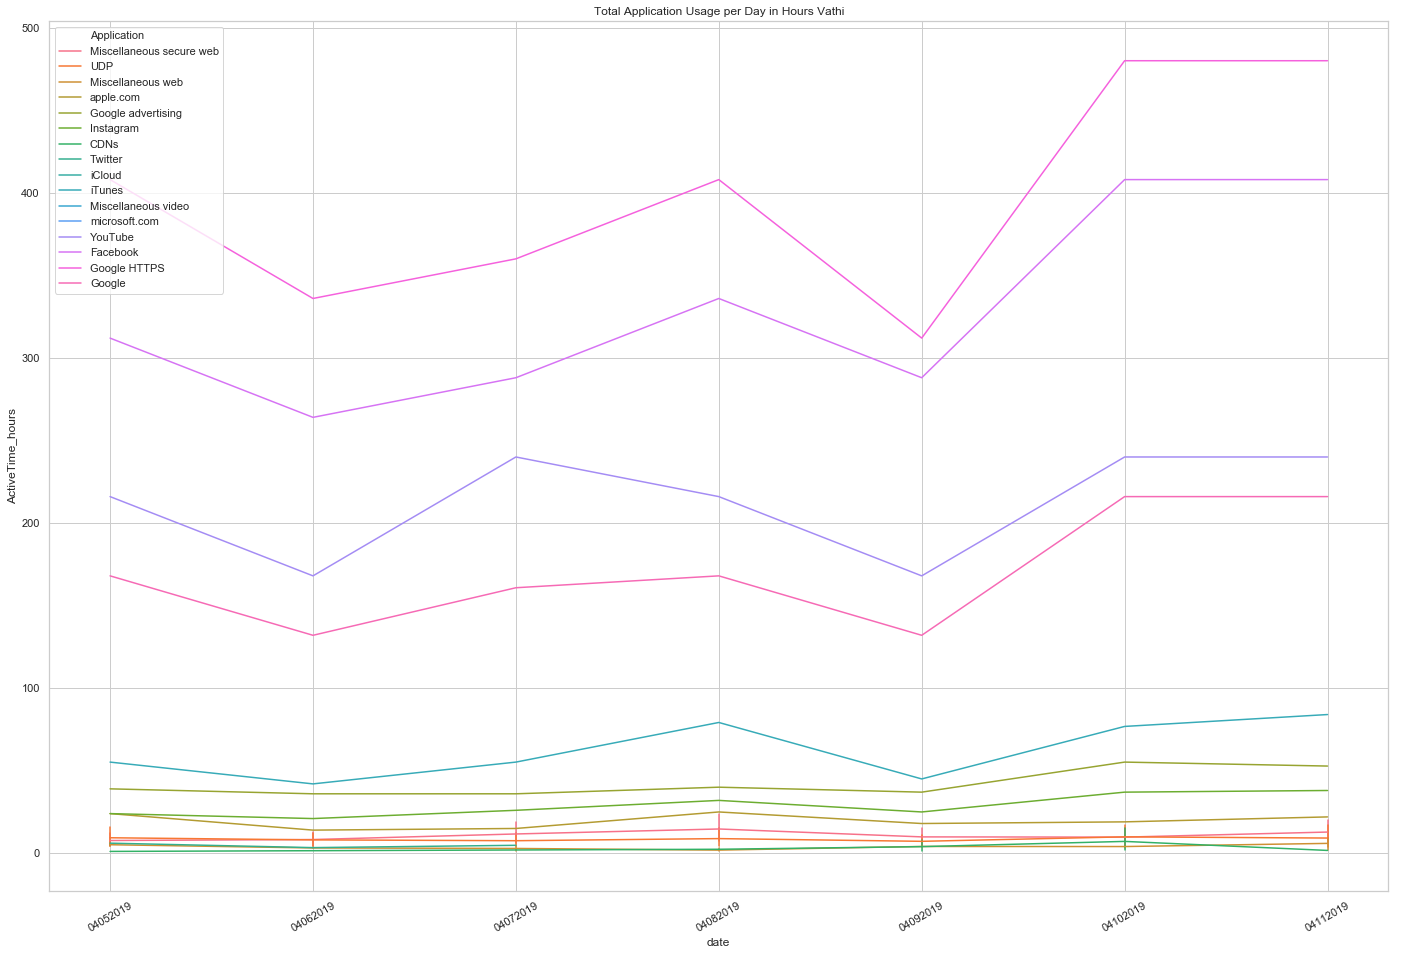

In [409]:
time_app_usage(vathi)

### Veria

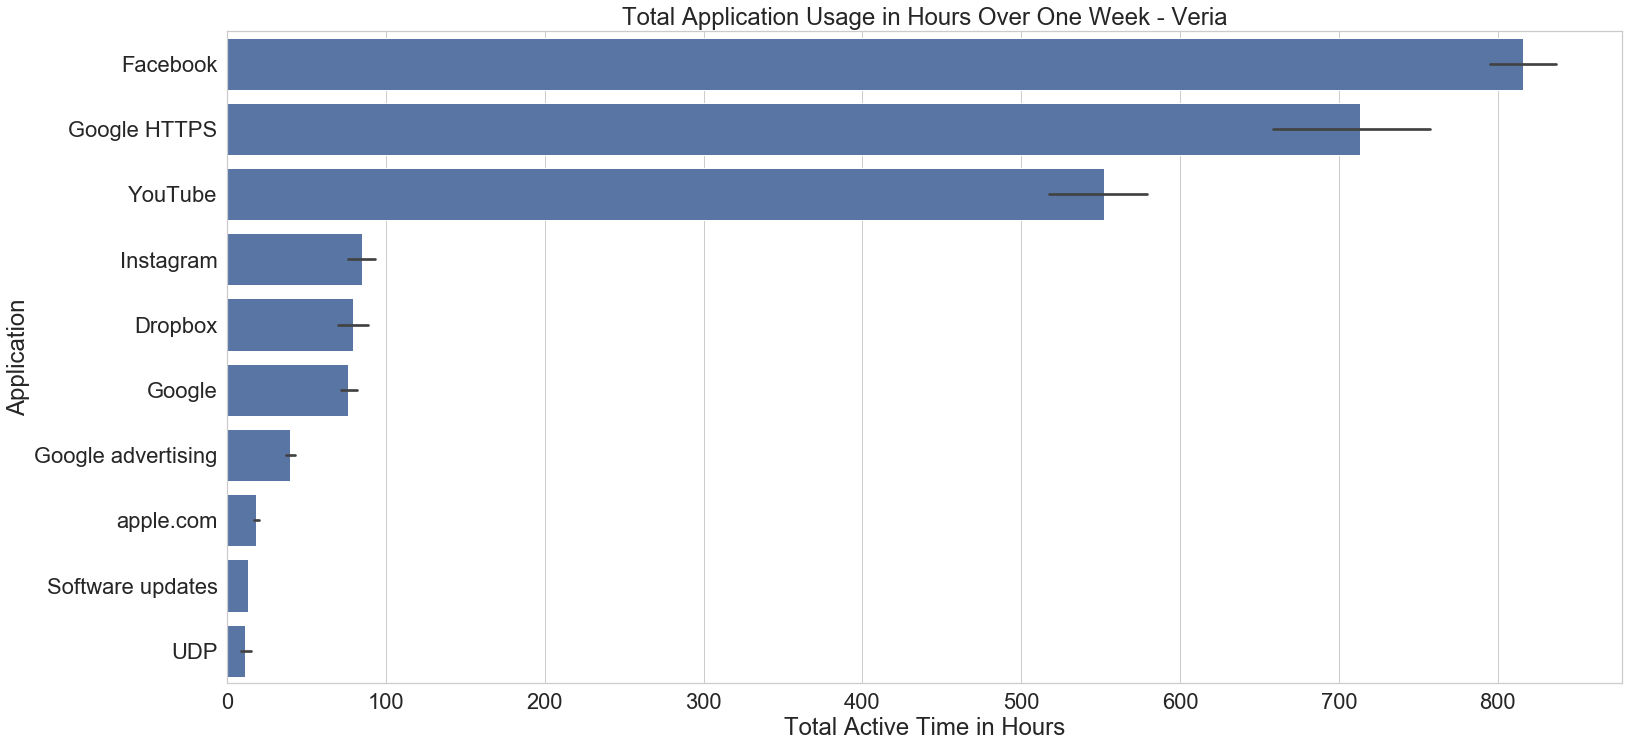

In [468]:
bar_top10(veria)

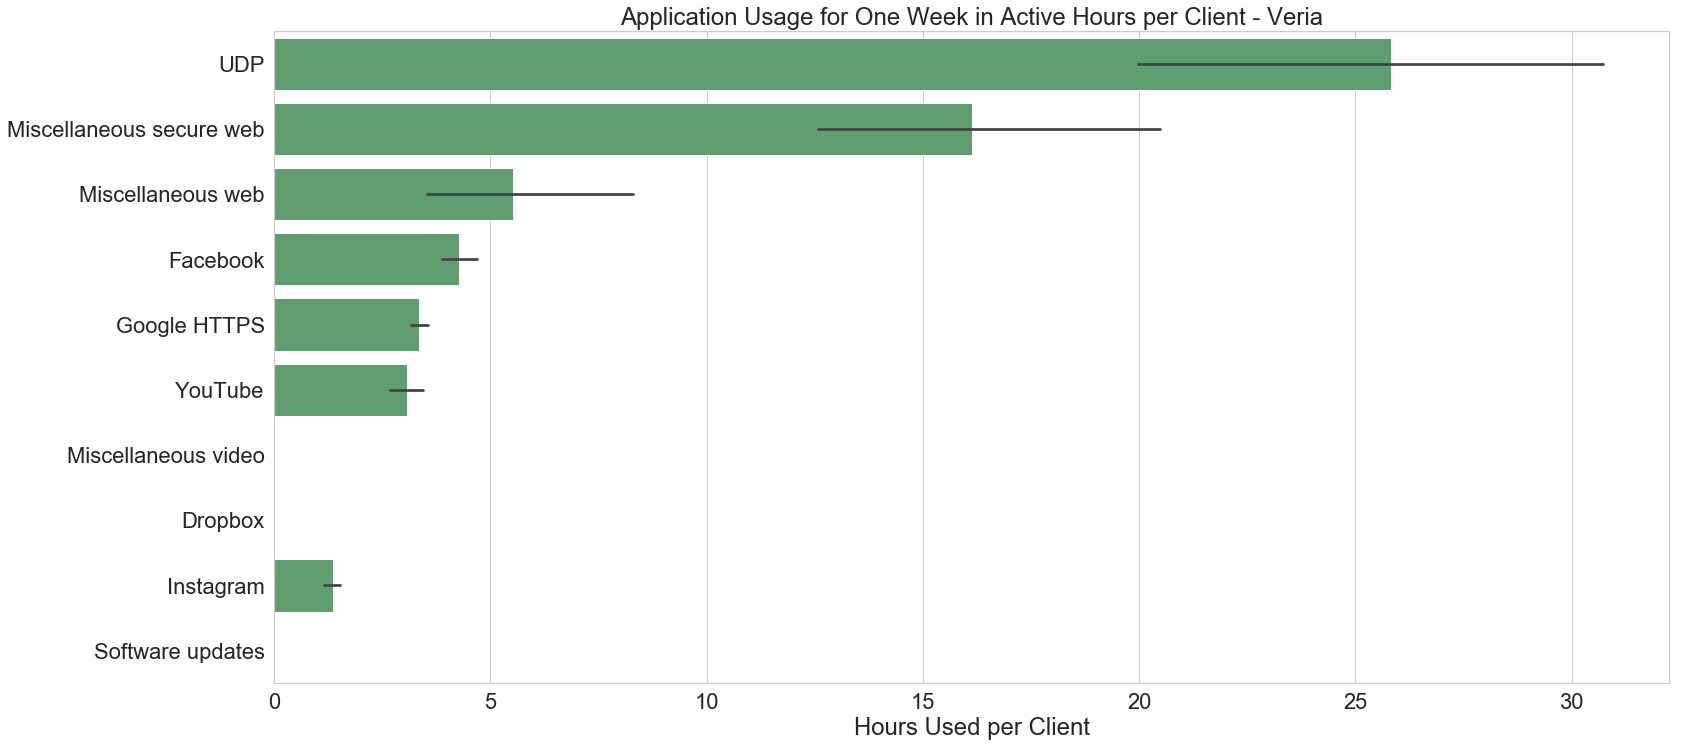

In [50]:
bar_top10_hrs_per_client(veria)

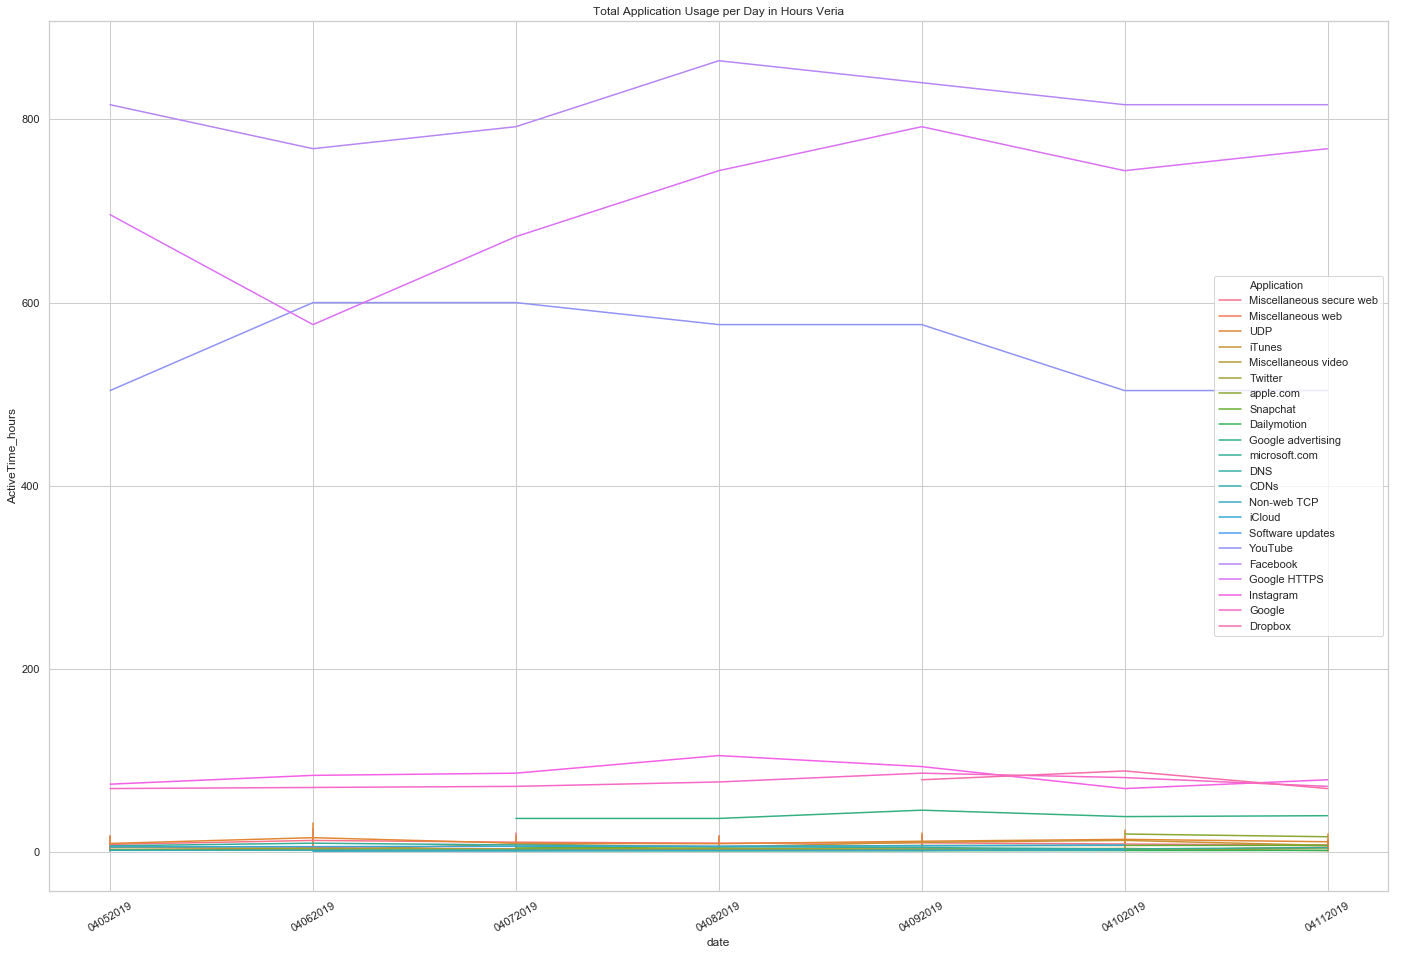

In [411]:
time_app_usage(veria)

In [18]:
traffic.head()

Application                 Destination Protocol   Port  \
4  Miscellaneous secure web    fath3-4.fna.whatsapp.net      TCP    443   
5  Miscellaneous secure web    fath3-3.fna.whatsapp.net      TCP    443   
7                       UDP              217.182.188.14      UDP  10548   
8         Miscellaneous web  updates-http.cdn-apple.com      TCP     80   
9                       UDP             googlevideo.com      UDP    443   

   % Usage    Usage   Sent  Received  Flows Active time  # clients  \
4      1.9  1096034  33949   1062085   4893    34 hours        223   
5      1.8  1044595  30110   1014485   3463    29 hours        201   
7      1.1   670149  61277    608872     10   2.3 hours          1   
8      0.8   476600  13055    463545    150   3.2 hours         19   
9      0.8   451033  10294    440739    171   5.8 hours         39   

                                         filename camp_name      date  \
4  Vathi_04082019_traffic_analytics_past24hrs.csv     Vathi  04082019   
5  Vathi_04082019_traffic_analytics_past24hrs.csv     Vathi  04082019   
7  Vathi_04082019_traffic_analytics_past24hrs.csv     Vathi  04082019   
8  Vathi_04082019_traffic_analytics_past24hrs.csv     Vathi  04082019   
9  Vathi_04082019_traffic_analytics_past24hrs.csv     Vathi  04082019   

   ActiveTime_Minutes active_time_increment  active_time_num  \
4              2040.0                 hours             34.0   
5              1740.0                 hours             29.0   
7               138.0                 hours              2.3   
8               192.0                 hours              3.2   
9               348.0                 hours              5.8   

   ActiveTime_hours  Hours_per_Client  date_time  
4              34.0              0.15 2019-04-08  
5              29.0              0.14 2019-04-08  
7               2.3              2.30 2019-04-08  
8               3.2              0.17 2019-04-08  
9               5.8              0.15 2019-04-08

# 1.b. Application Protocol Usage per Day in Minutes
- This gives data and visualizations for Web Application Protocols only
- These visualizations are present in the final report

In [19]:
traffic.Application.unique()

array(['Miscellaneous secure web', 'UDP', 'Miscellaneous web',
       'apple.com', 'Google advertising', 'Instagram', 'CDNs', 'iTunes',
       'Twitter', 'Miscellaneous video', 'iCloud', 'Non-web TCP', 'SSH',
       'Snapchat', 'Dailymotion', 'microsoft.com',
       'Real Time Streaming Protocol', 'Software updates', 'YouTube',
       'Google', 'Meraki HTTPS', 'Encrypted P2P', 'BitTorrent', 'PayPal',
       'DNS', 'Netflix', 'adobe.com', 'Facebook', 'Google HTTPS',
       'Dropbox', 'ICMP'], dtype=object)

#### Remove anything that is not a web protocol, create new dataframe, protocol_df

In [51]:
protocols = ['UDP','CDNs','Non-web TCP','ICMP','SSH','DNS','Real Time Streaming Protocol',
             'SOCKS proxy','Encrypted P2P','FTP', 'TCP', 'Encrypted TCP (SSL)']
protocol_df = traffic[traffic.Application.isin(protocols)]

In [52]:
moria_proto = protocol_df[protocol_df['camp_name']=='Moria']
kos_proto = protocol_df[protocol_df['camp_name']=='Kos']
nea_proto = protocol_df[protocol_df['camp_name']=='Nea']
skaram_proto = protocol_df[protocol_df['camp_name']=='Skaram']
vathi_proto = protocol_df[protocol_df['camp_name']=='Vathi']
veria_proto = protocol_df[protocol_df['camp_name']=='Veria']

# 1.c. Web Application Usage per Day in Hours (e.g. Facebook, Google, etc.)
- This includes all Applications that are not Web Application Protocols
- These appear in the final report

In [53]:
protocols = ['UDP','CDNs','Non-web TCP','ICMP','SSH','DNS','Real Time Streaming Protocol',
             'SOCKS proxy','Encrypted P2P','FTP', 'TCP', 'Encrypted TCP (SSL)']
app_df = traffic[~traffic.Application.isin(protocols)]

#### Create dataframe for each camp, includes all applications except for Web Protocols

In [54]:
#--Camps with Web Application data only (like Google, Facebook, etc. --no protocols)--
moria_app = app_df[app_df['camp_name']=='Moria']
kos_app = app_df[app_df['camp_name']=='Kos']
nea_app = app_df[app_df['camp_name']=='Nea']
skaram_app = app_df[app_df['camp_name']=='Skaram']
vathi_app = app_df[app_df['camp_name']=='Vathi']
veria_app = app_df[app_df['camp_name']=='Veria']

## Visualizations
- For all camps in total
- For each separate camp

### All Camps

Text(0.5,1,'Application Usage Over One Week in Active Hours - Six Camps')

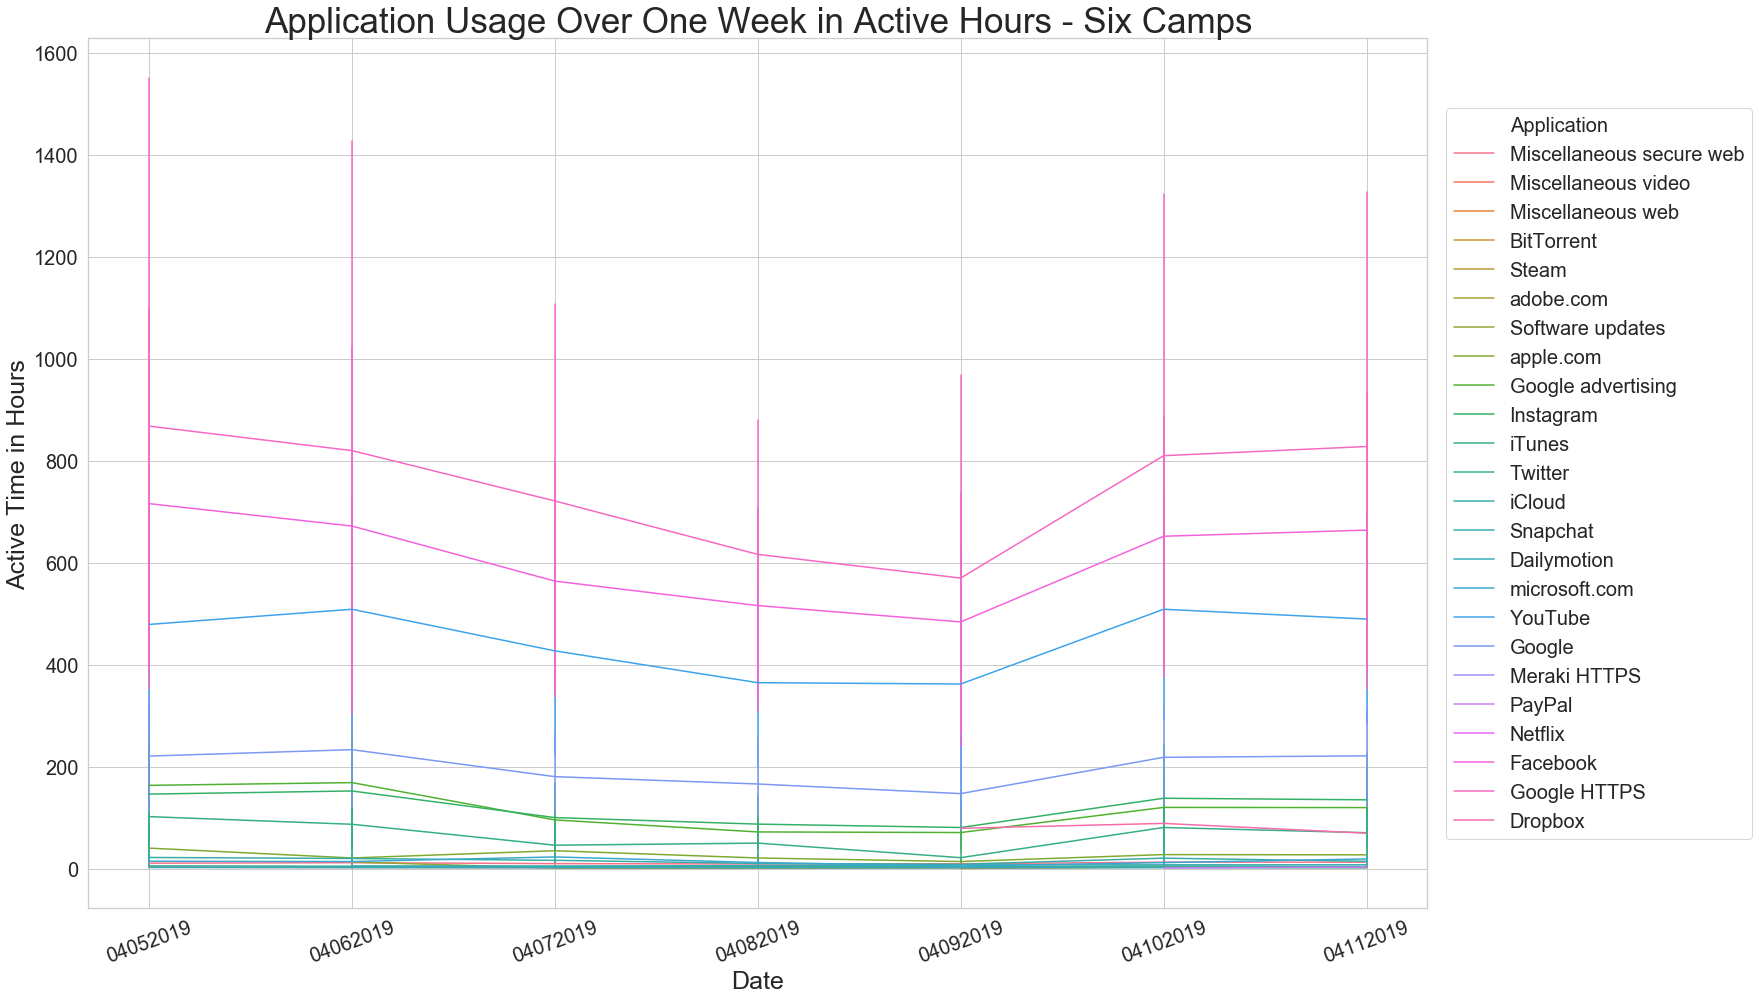

In [55]:
time_app_usage(app_df)
plt.title("Application Usage Over One Week in Active Hours - Six Camps", fontsize=35)
# plt.title("")

Text(0.5,1,'Application Usage for One Week in Active Hours per Client - Six Camps')

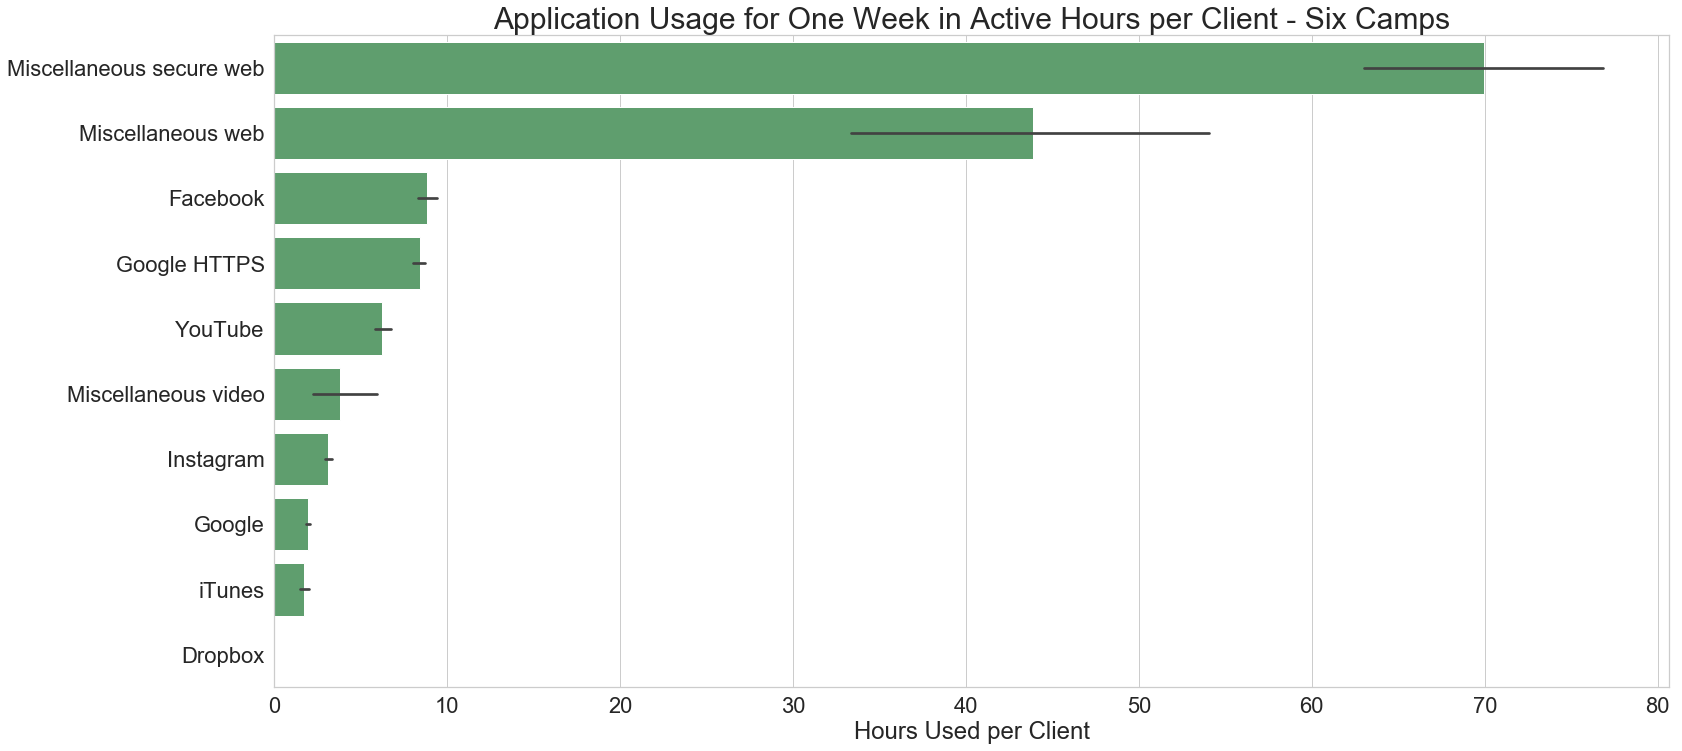

In [56]:
bar_top10_hrs_per_client(app_df)
plt.title("Application Usage for One Week in Active Hours per Client - Six Camps",fontsize=30)

Text(0.5,1,'Total Application Usage in Hours Over One Week - Six Camps')

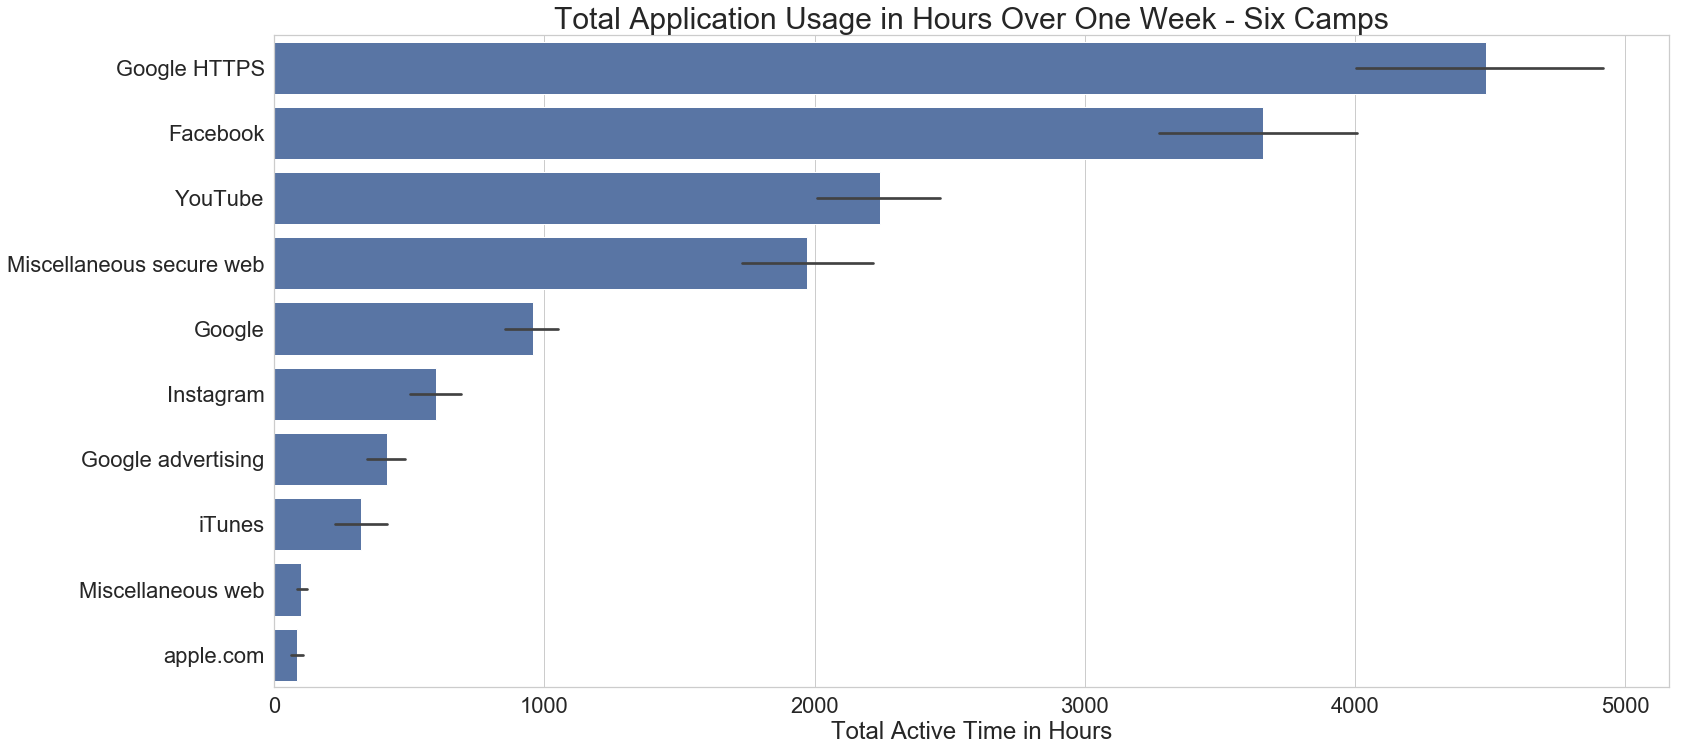

In [57]:
bar_top10(app_df)
plt.title("Total Application Usage in Hours Over One Week - Six Camps",fontsize=30)

### Kos

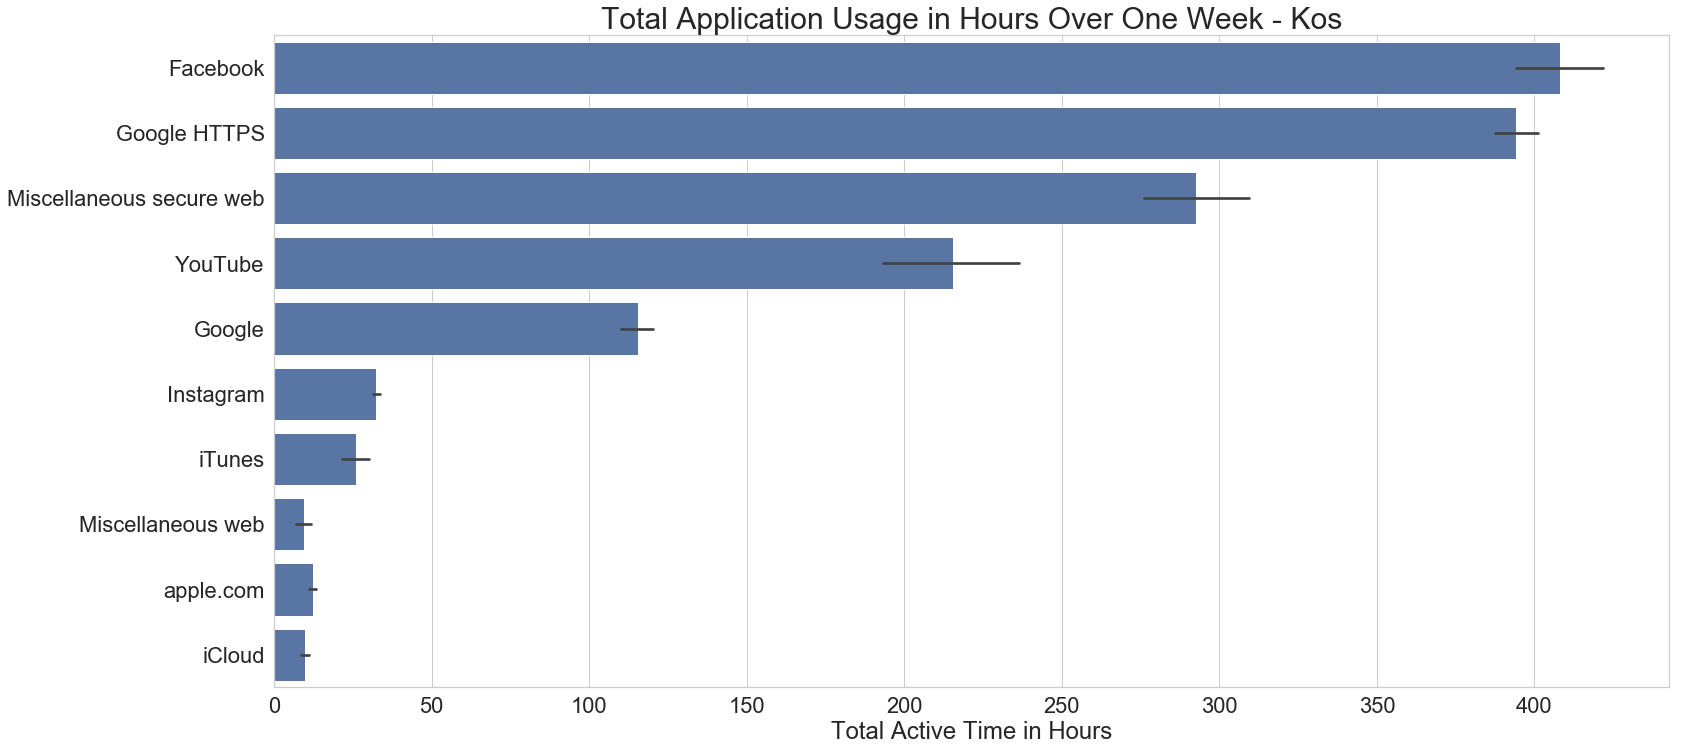

In [58]:
bar_top10(kos_app)

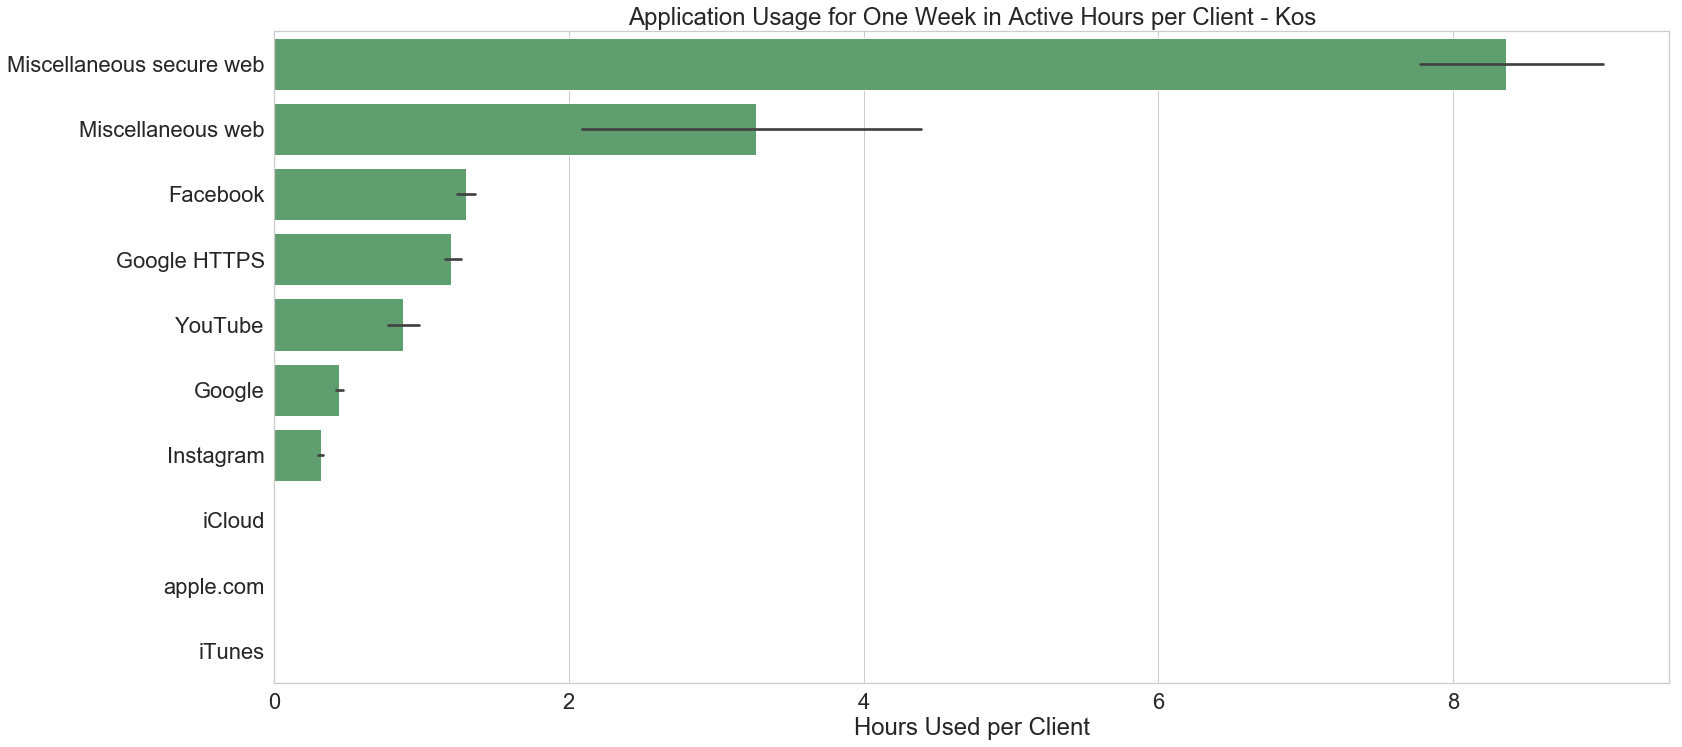

In [59]:
bar_top10_hrs_per_client(kos_app)

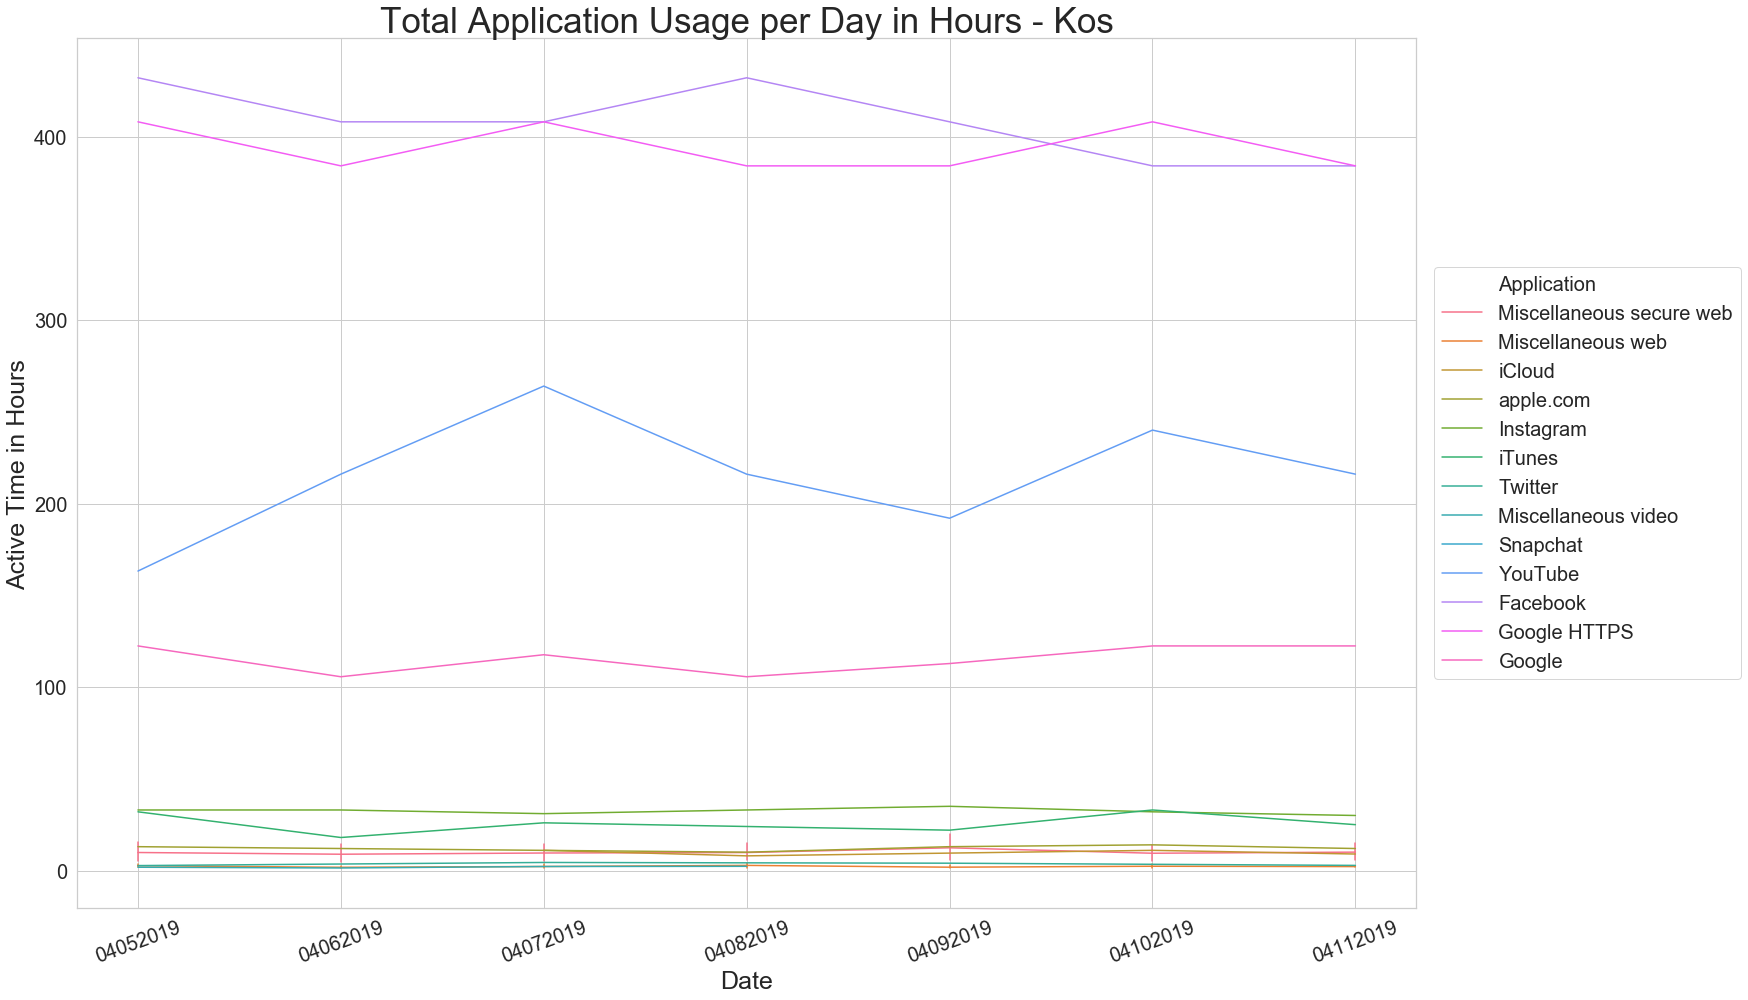

In [26]:
time_app_usage(kos_app)
# plt.title("")

### Moria

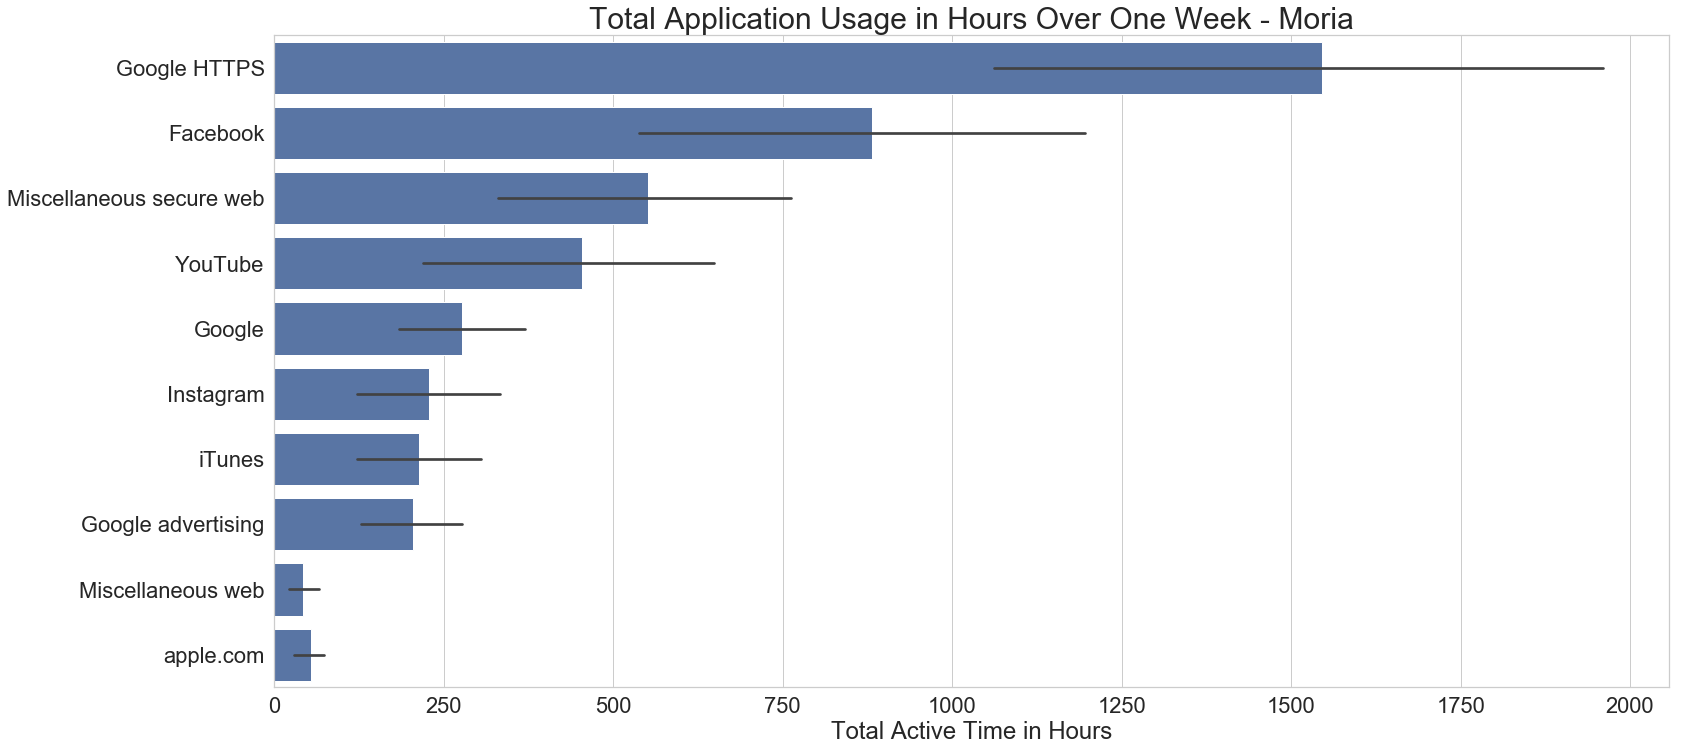

In [60]:
bar_top10(moria_app)

Text(0.5,1,'')

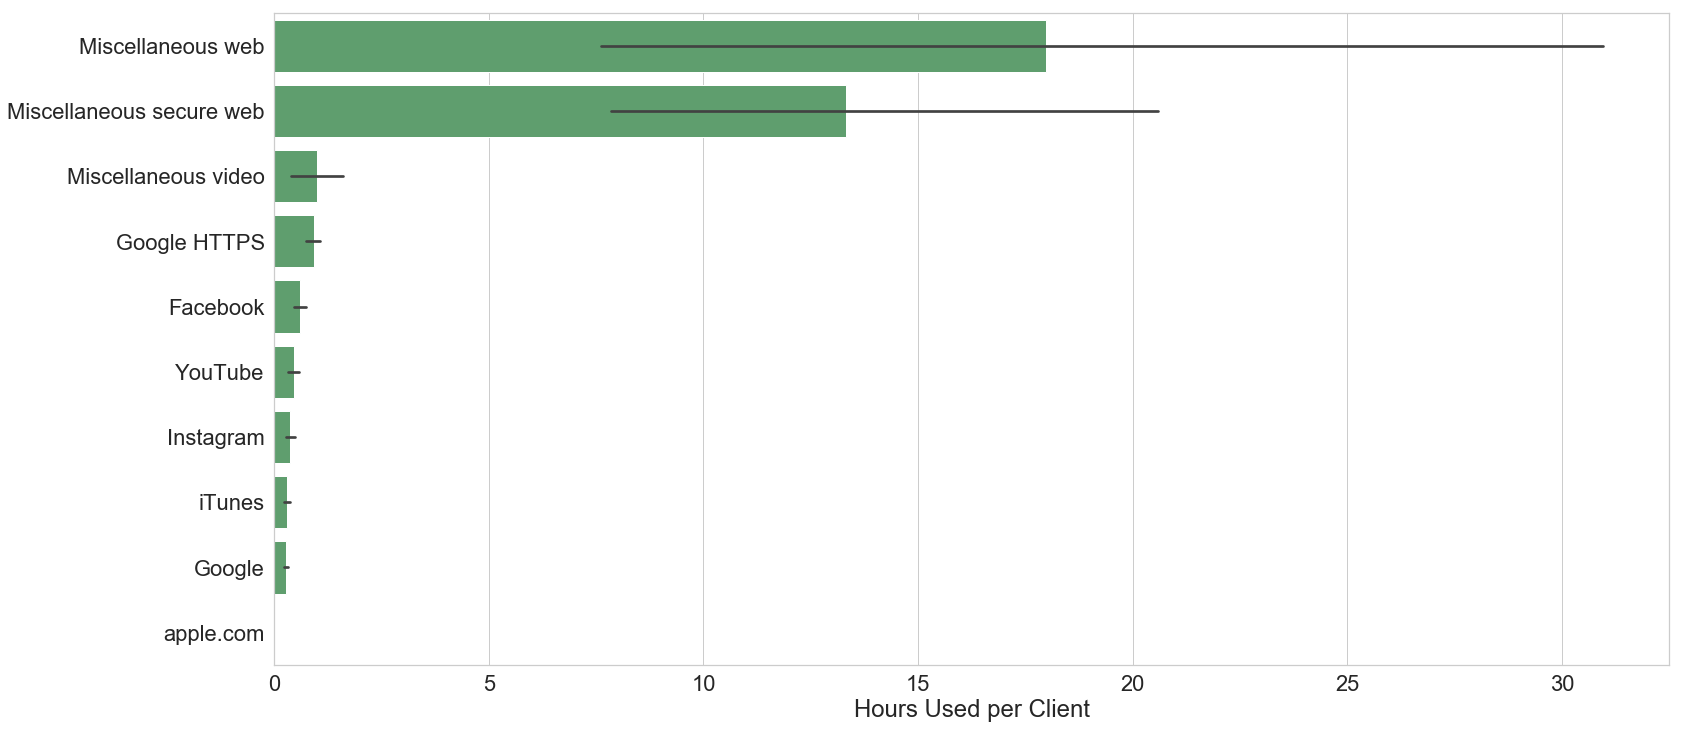

In [61]:
bar_top10_hrs_per_client(moria_app)
plt.title("")

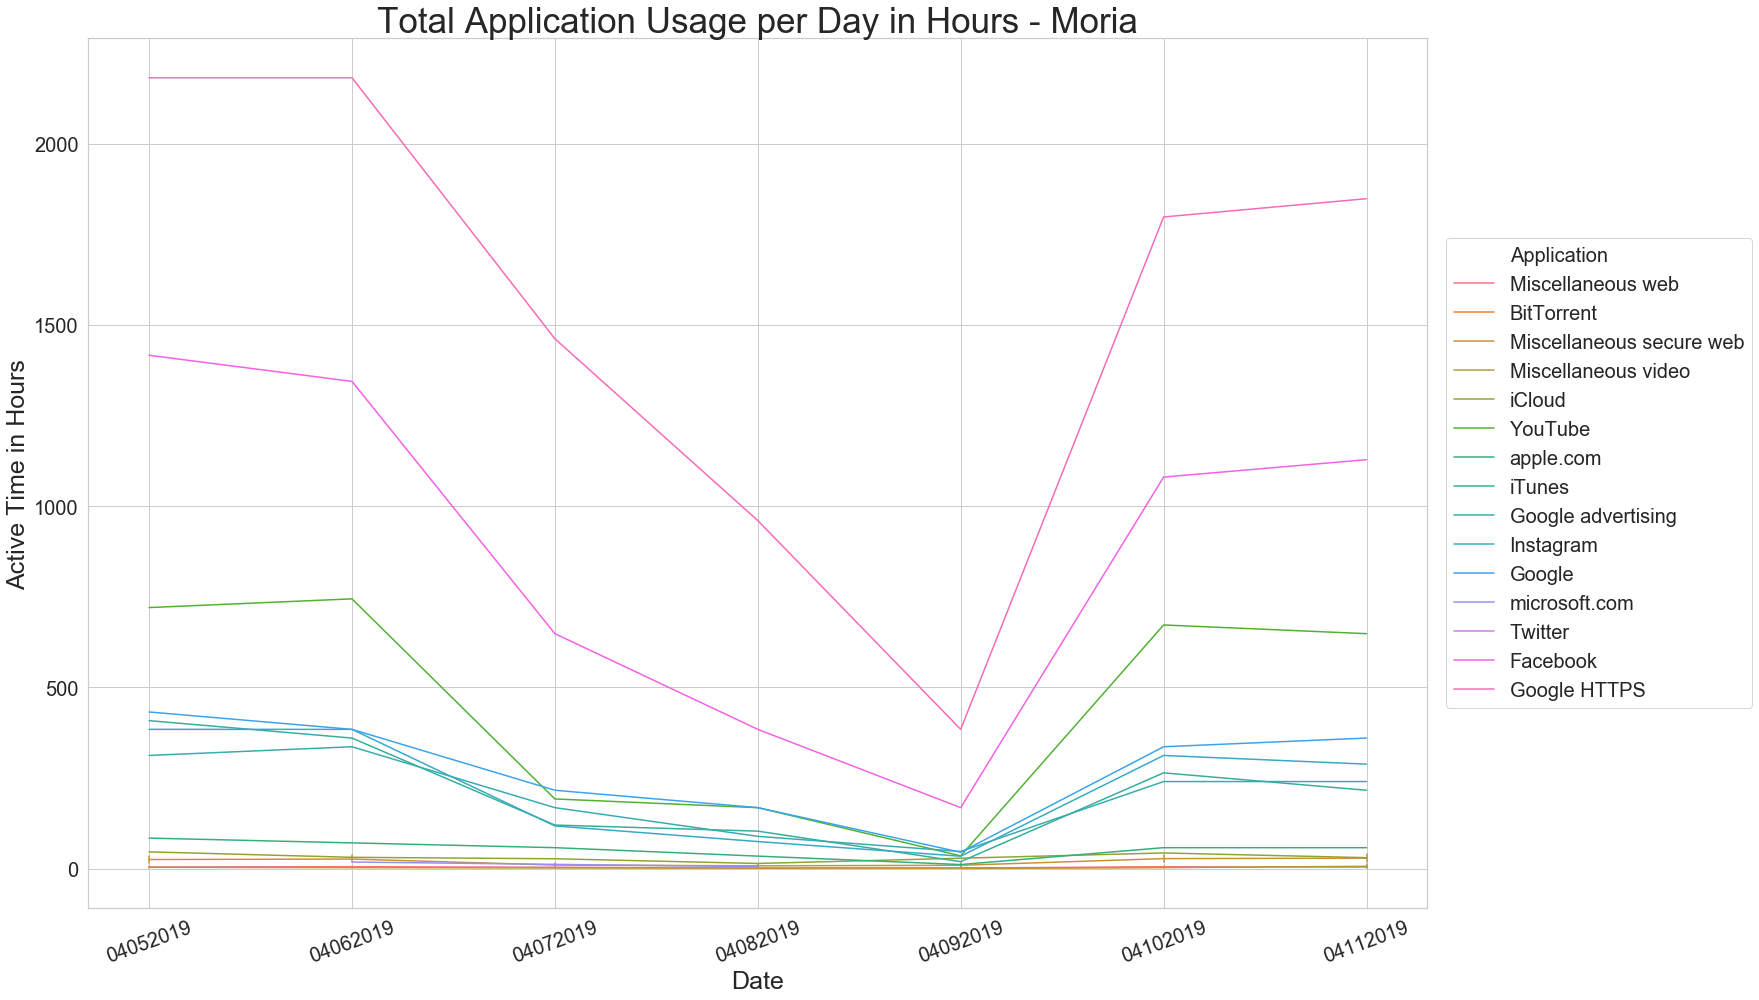

In [62]:
time_app_usage(moria_app)
# plt.title("")

### Nea Kavala

Text(0.5,1,'Total Application Usage in Hours Over One Week - Nea Kavala')

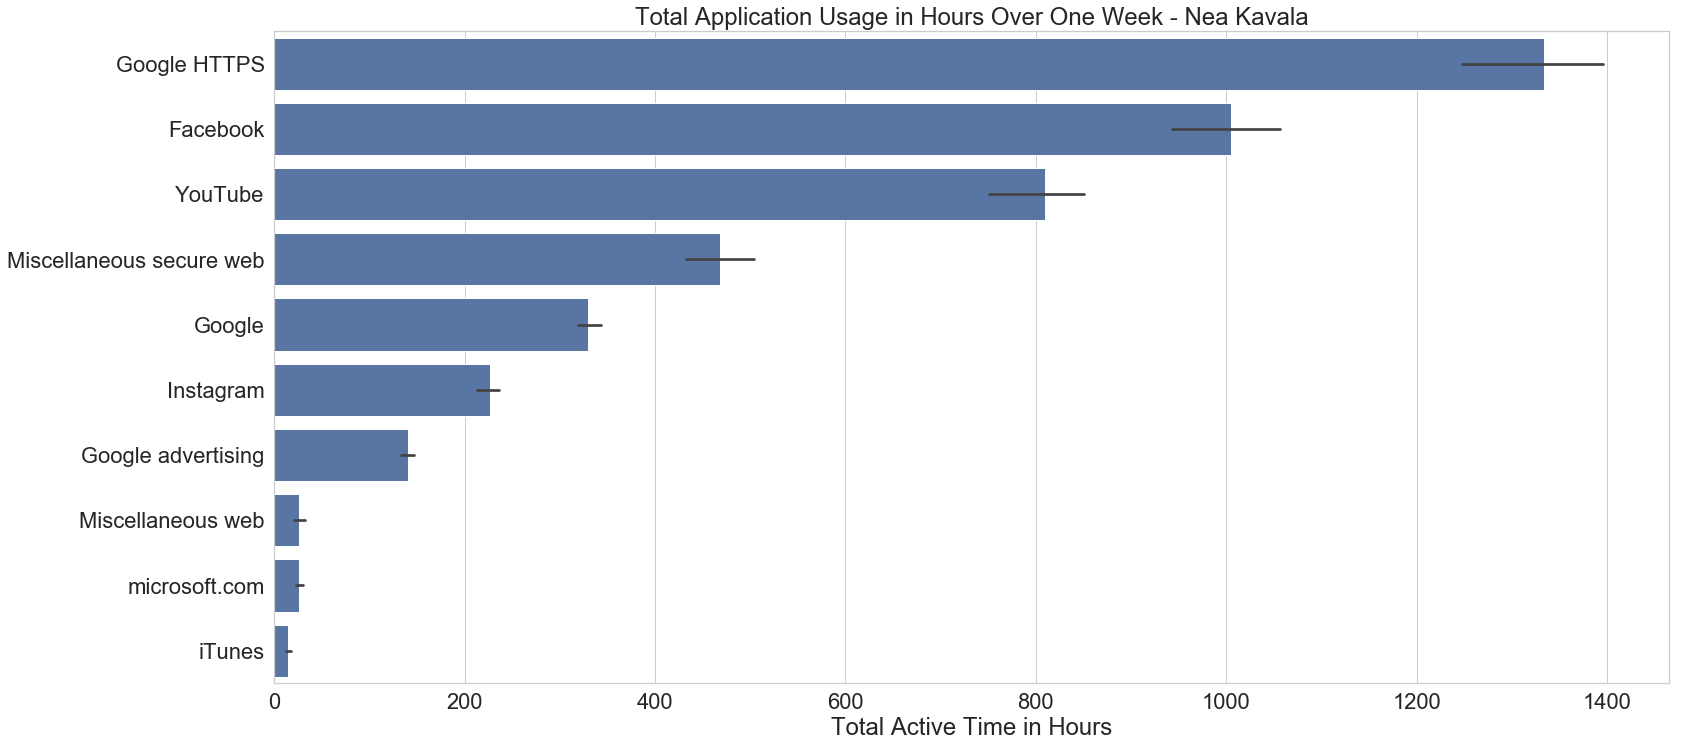

In [63]:
bar_top10(nea_app)
plt.title("Total Application Usage in Hours Over One Week - Nea Kavala")

Text(0.5,1,'Application Usage for One Week in Active Hours per Client - Nea Kavala')

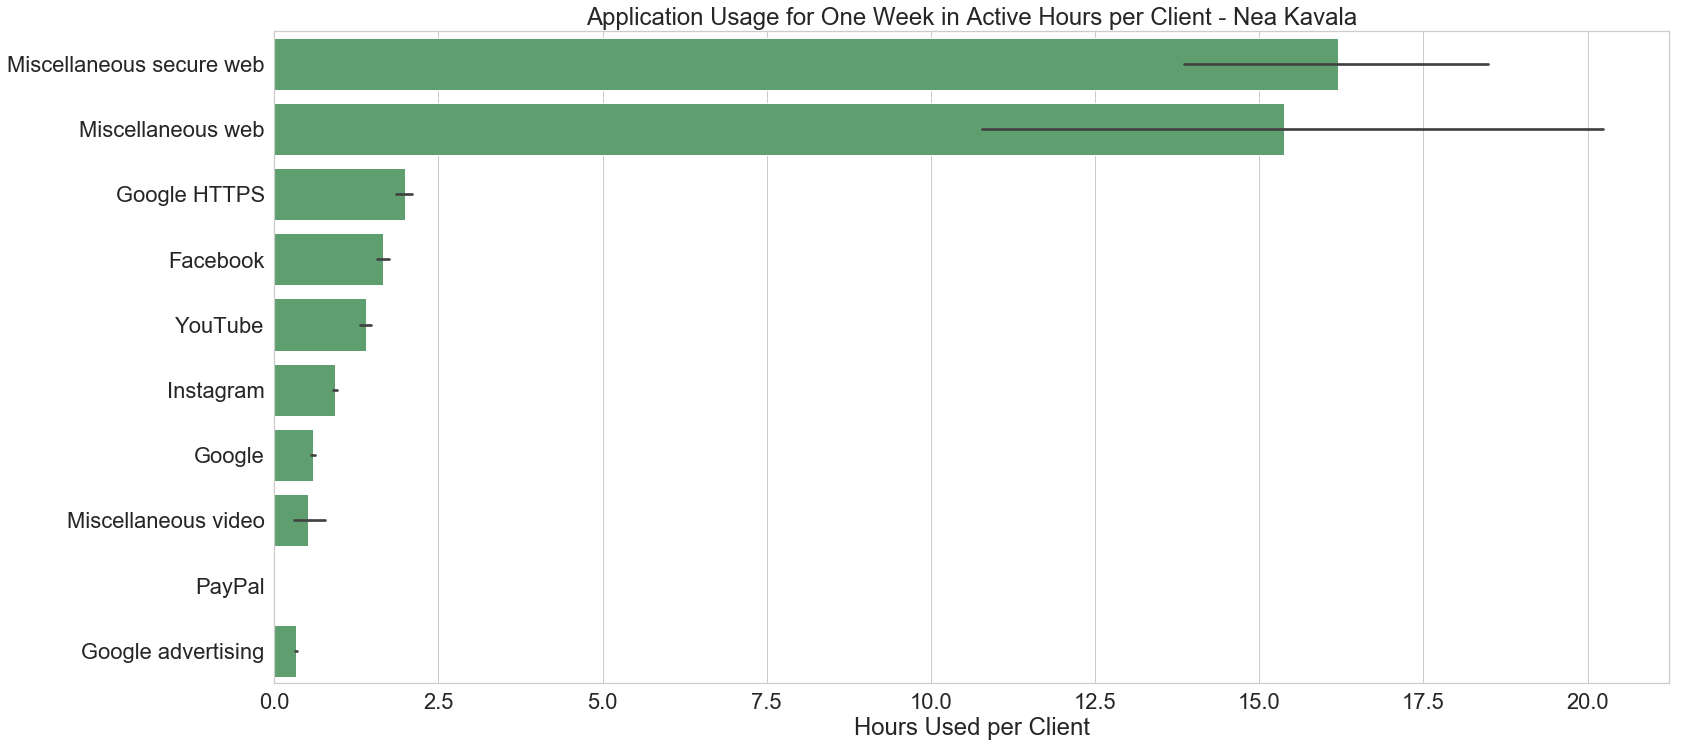

In [64]:
bar_top10_hrs_per_client(nea_app)
plt.title("Application Usage for One Week in Active Hours per Client - Nea Kavala")

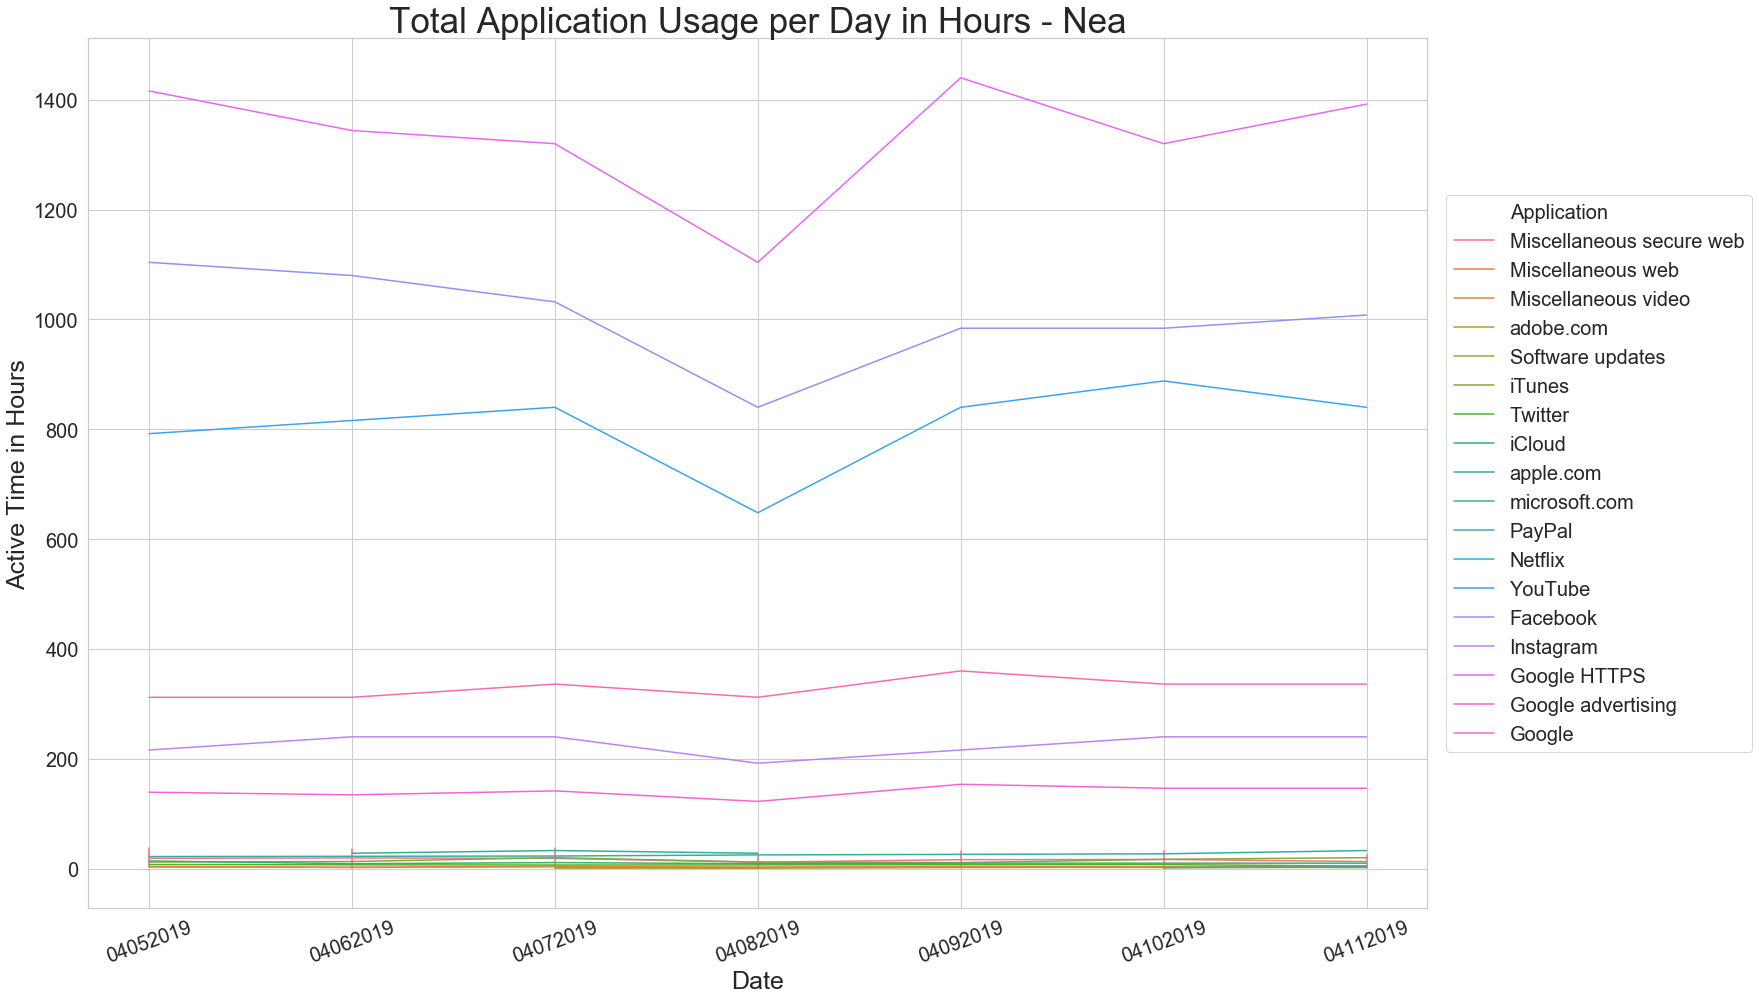

In [65]:
time_app_usage(nea_app)

### Skaramangas

Text(0.5,1,'Total Application Usage in Hours Over One Week - Skaramangas')

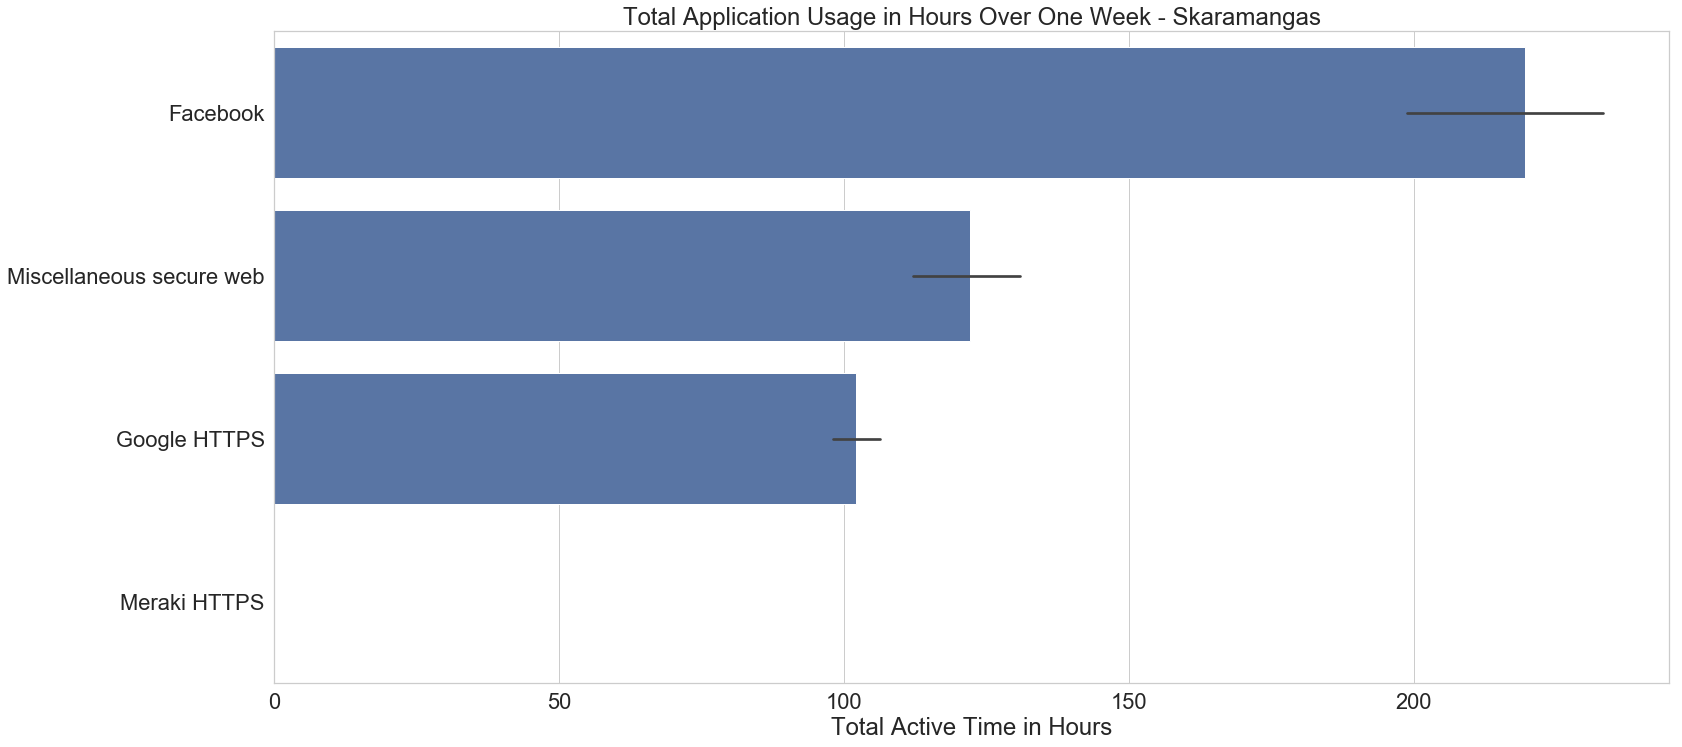

In [66]:
bar_top10(skaram_app)
plt.title("Total Application Usage in Hours Over One Week - Skaramangas")

Text(0.5,1,'Total Application Usage in Hours Over One Week - Skaramangas')

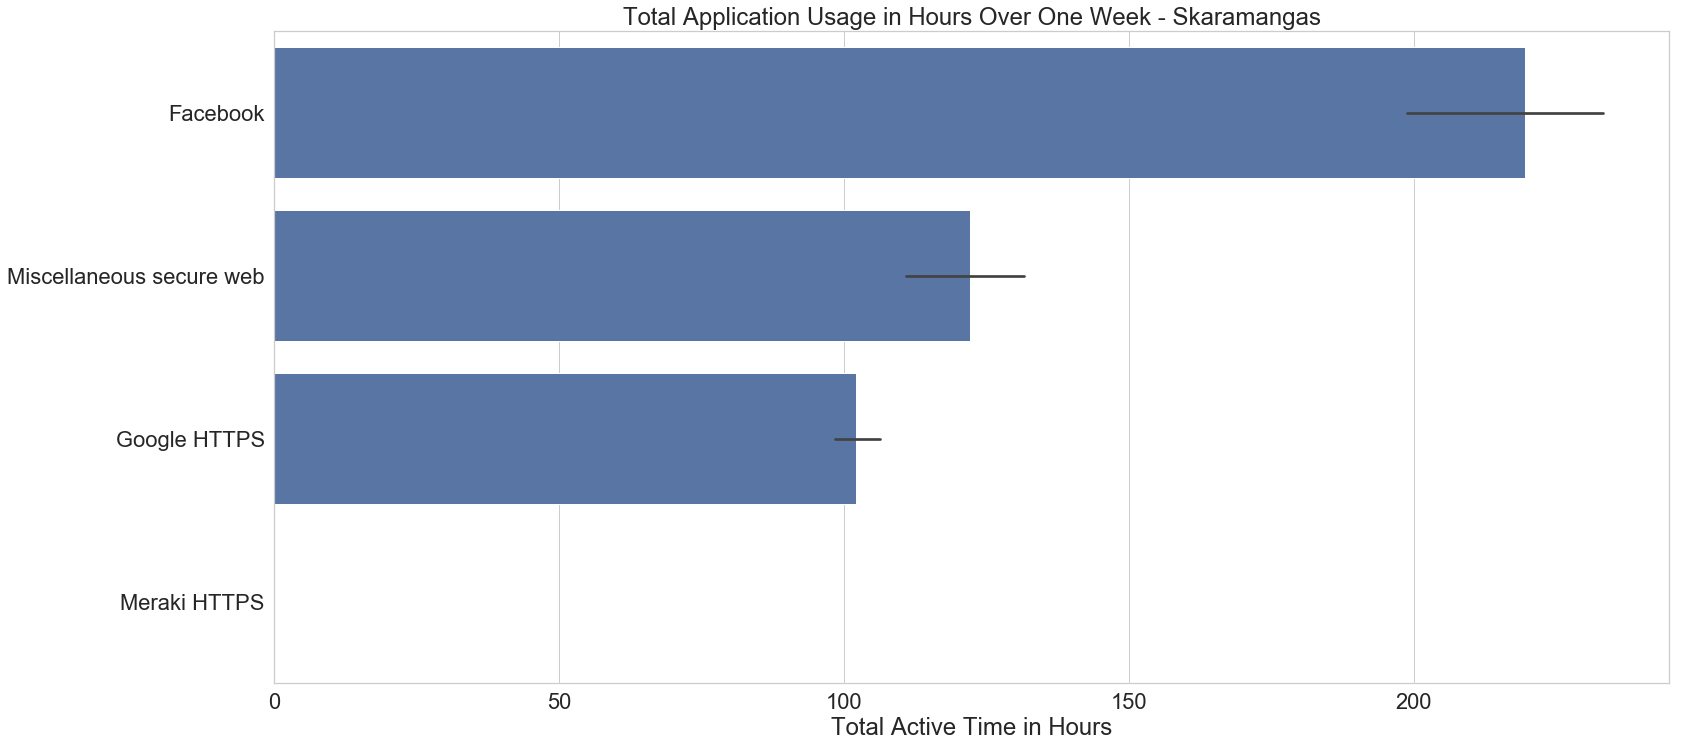

In [67]:
bar_top10(skaram_app)
plt.title("Total Application Usage in Hours Over One Week - Skaramangas")

Text(0.5,1,'Application Usage for One Week in Active Hours per Client - Skaramangas')

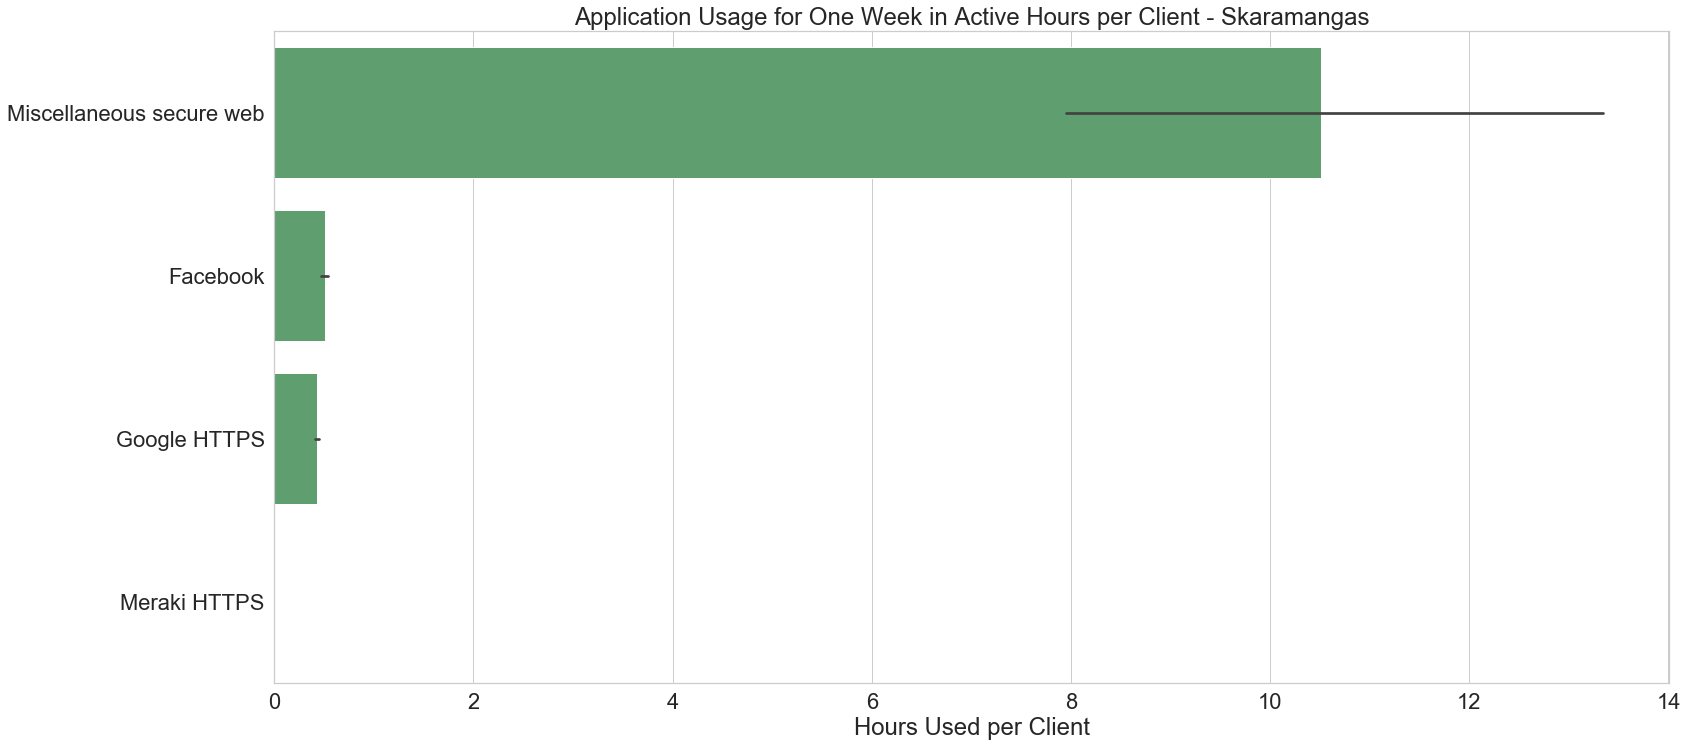

In [68]:
bar_top10_hrs_per_client(skaram_app)
plt.title("Application Usage for One Week in Active Hours per Client - Skaramangas")

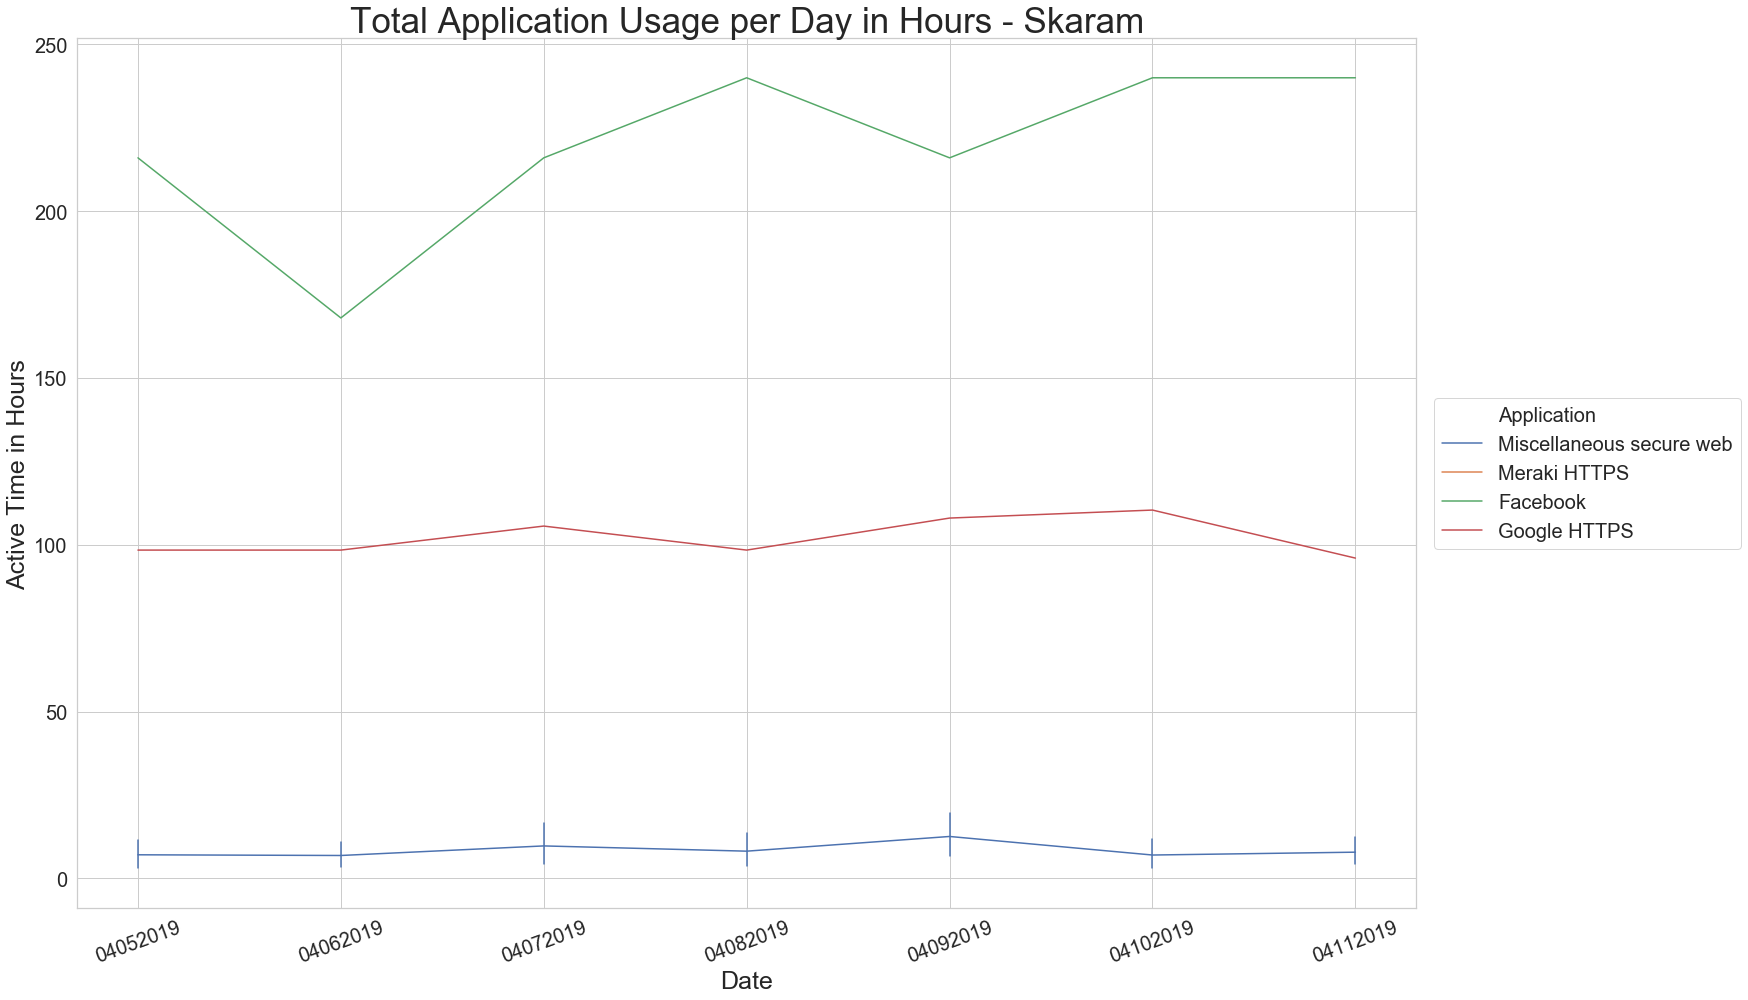

In [69]:
time_app_usage(skaram_app)

### Vathi Samos

Text(0.5,1,'Total Application Usage in Hours Over One Week - Vathi Samos')

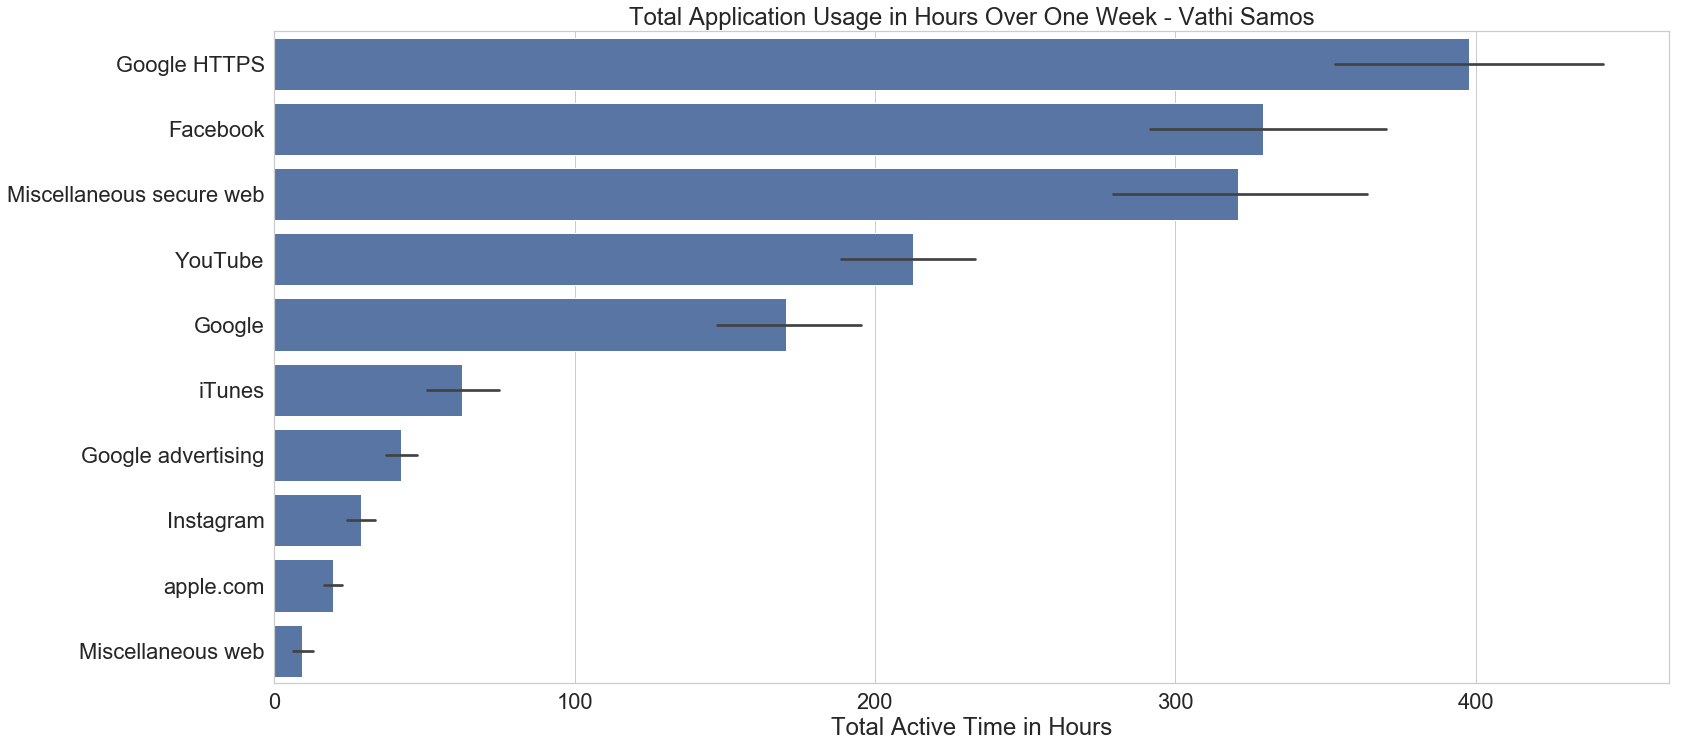

In [70]:
bar_top10(vathi_app)
plt.title("Total Application Usage in Hours Over One Week - Vathi Samos")

Text(0.5,1,'Application Usage for One Week in Active Hours per Client - Vathi Samos')

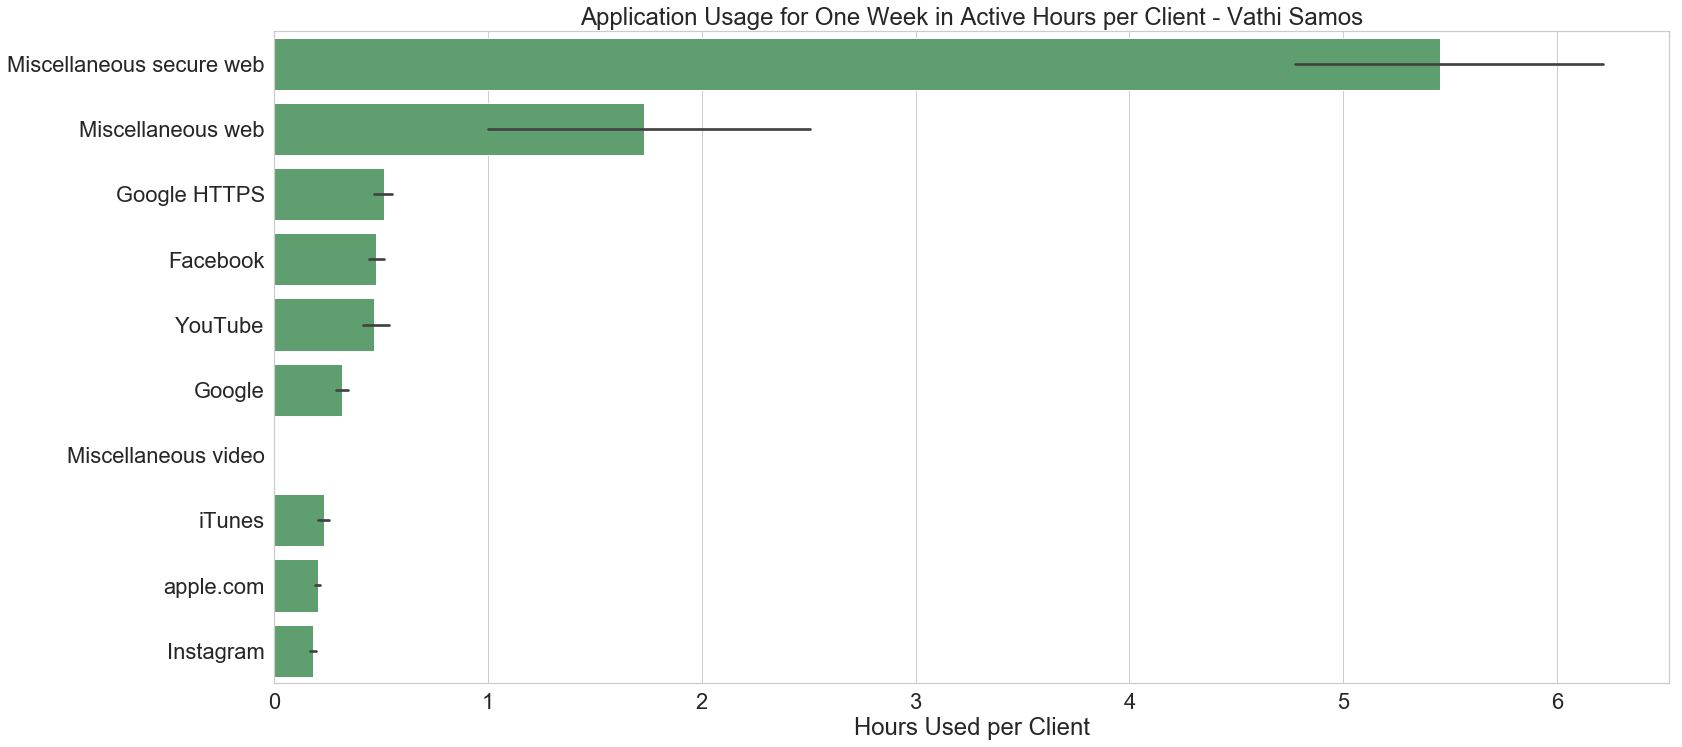

In [71]:
bar_top10_hrs_per_client(vathi_app)
plt.title("Application Usage for One Week in Active Hours per Client - Vathi Samos")

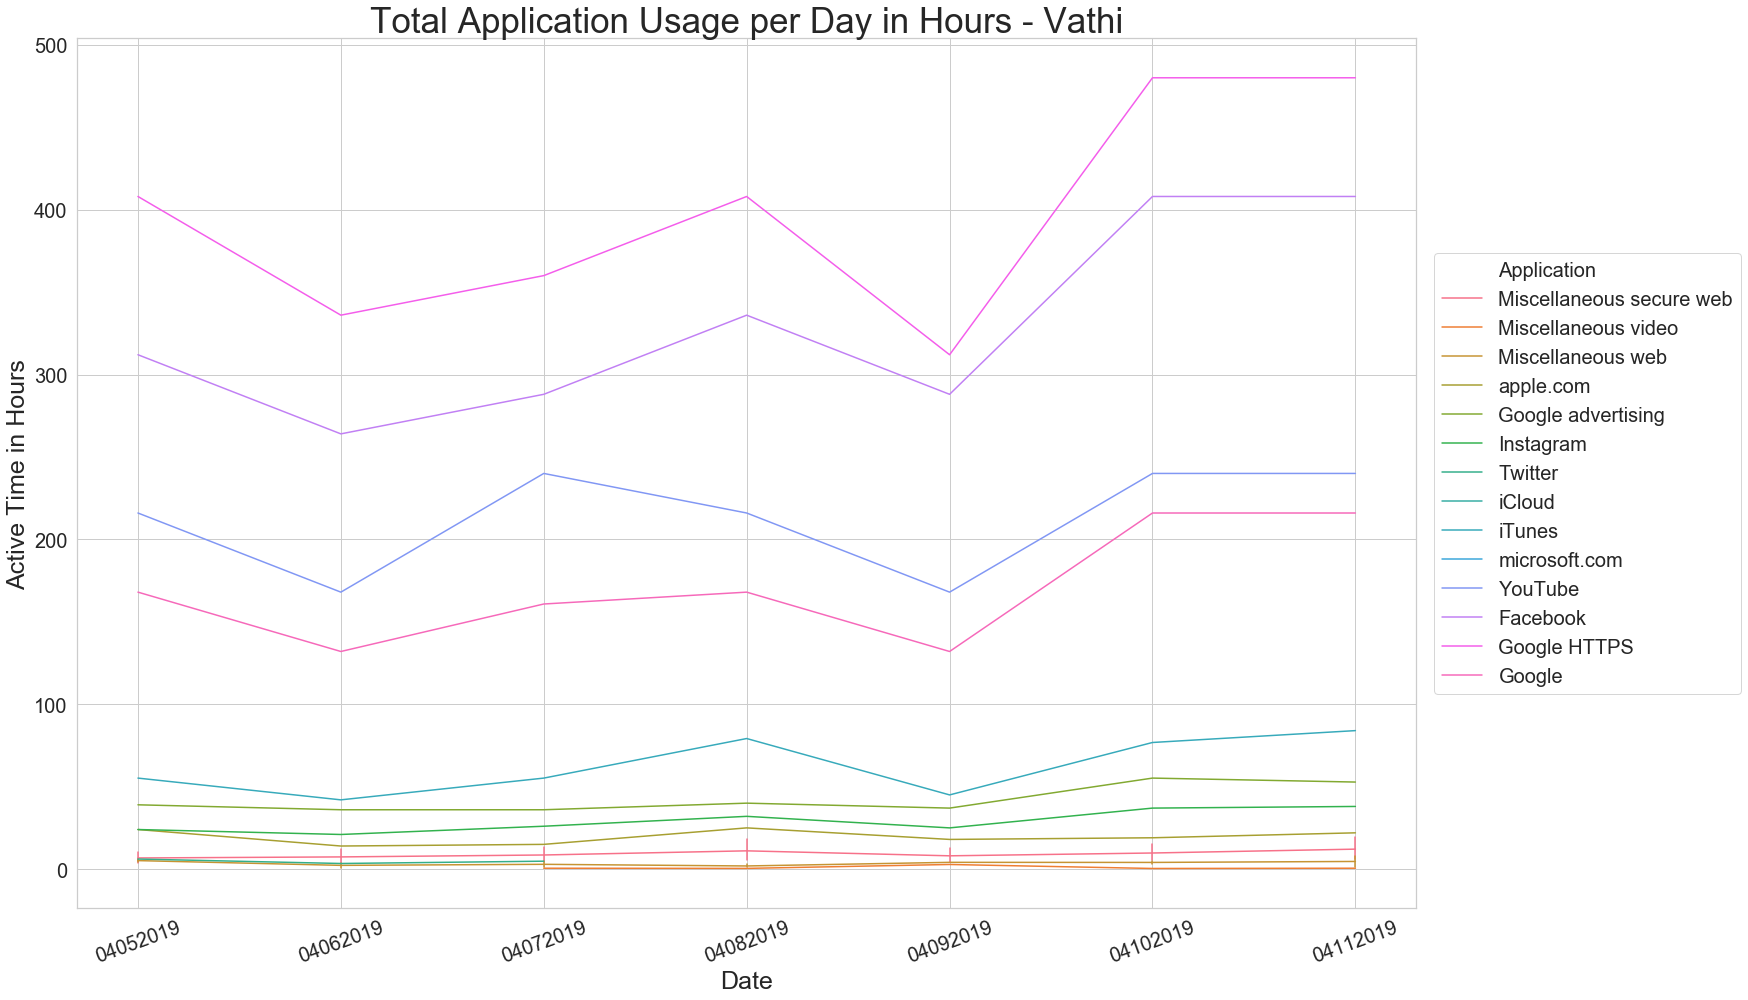

In [72]:
time_app_usage(vathi_app)

### Veria

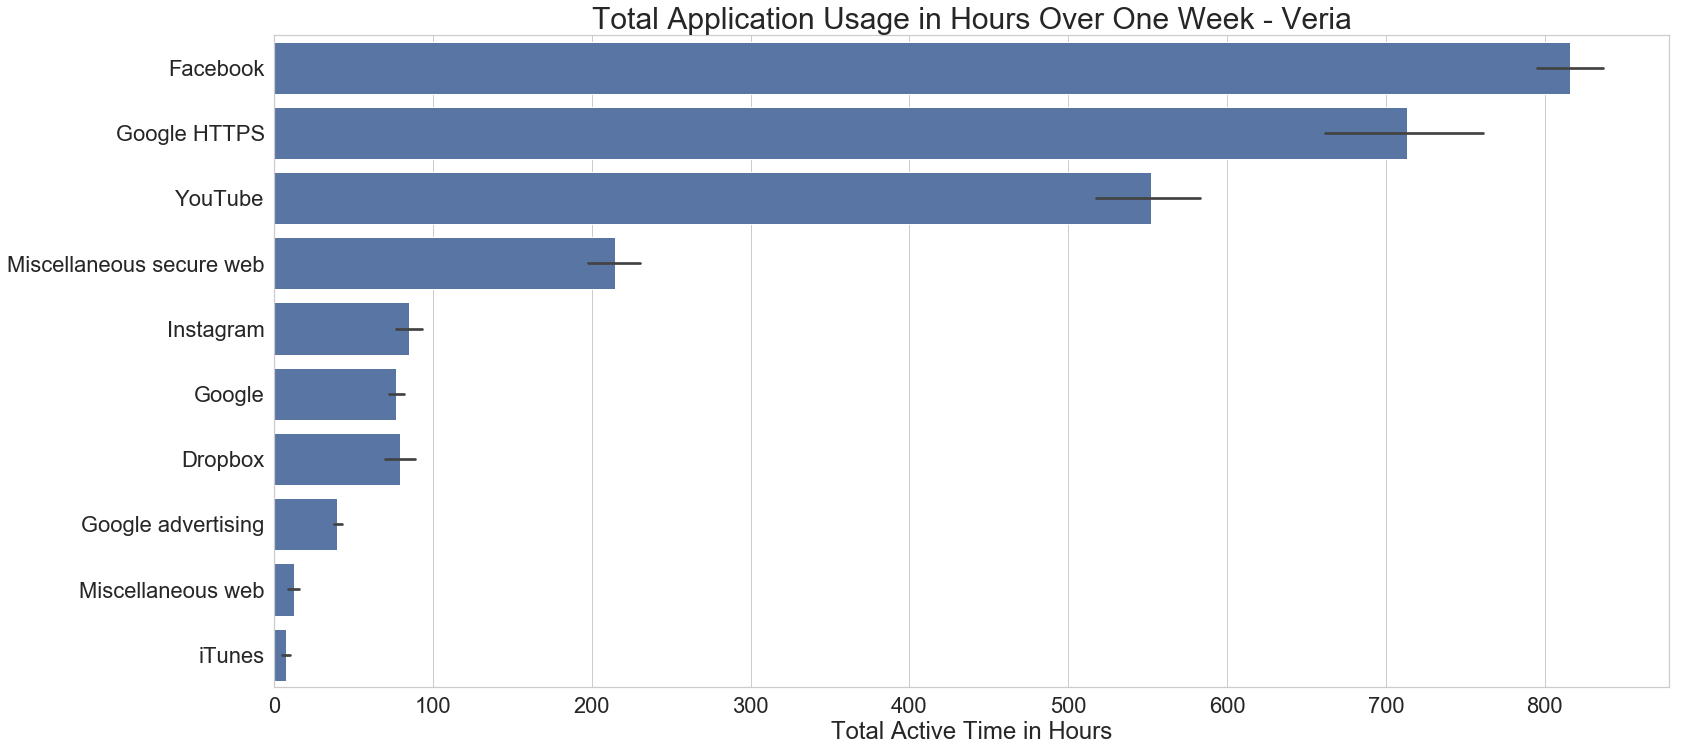

In [73]:
bar_top10(veria_app)

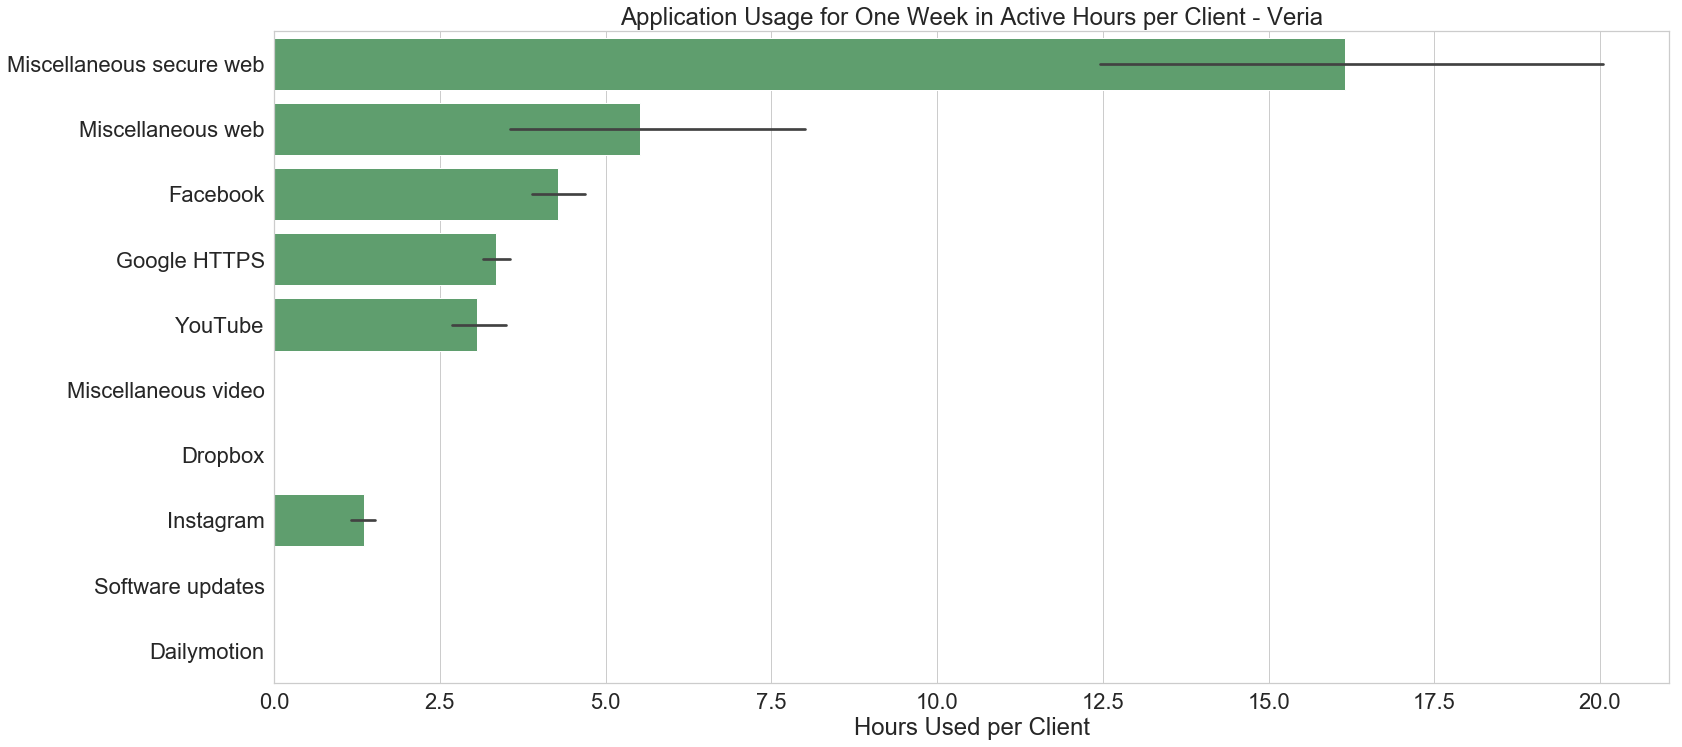

In [74]:
bar_top10_hrs_per_client(veria_app)

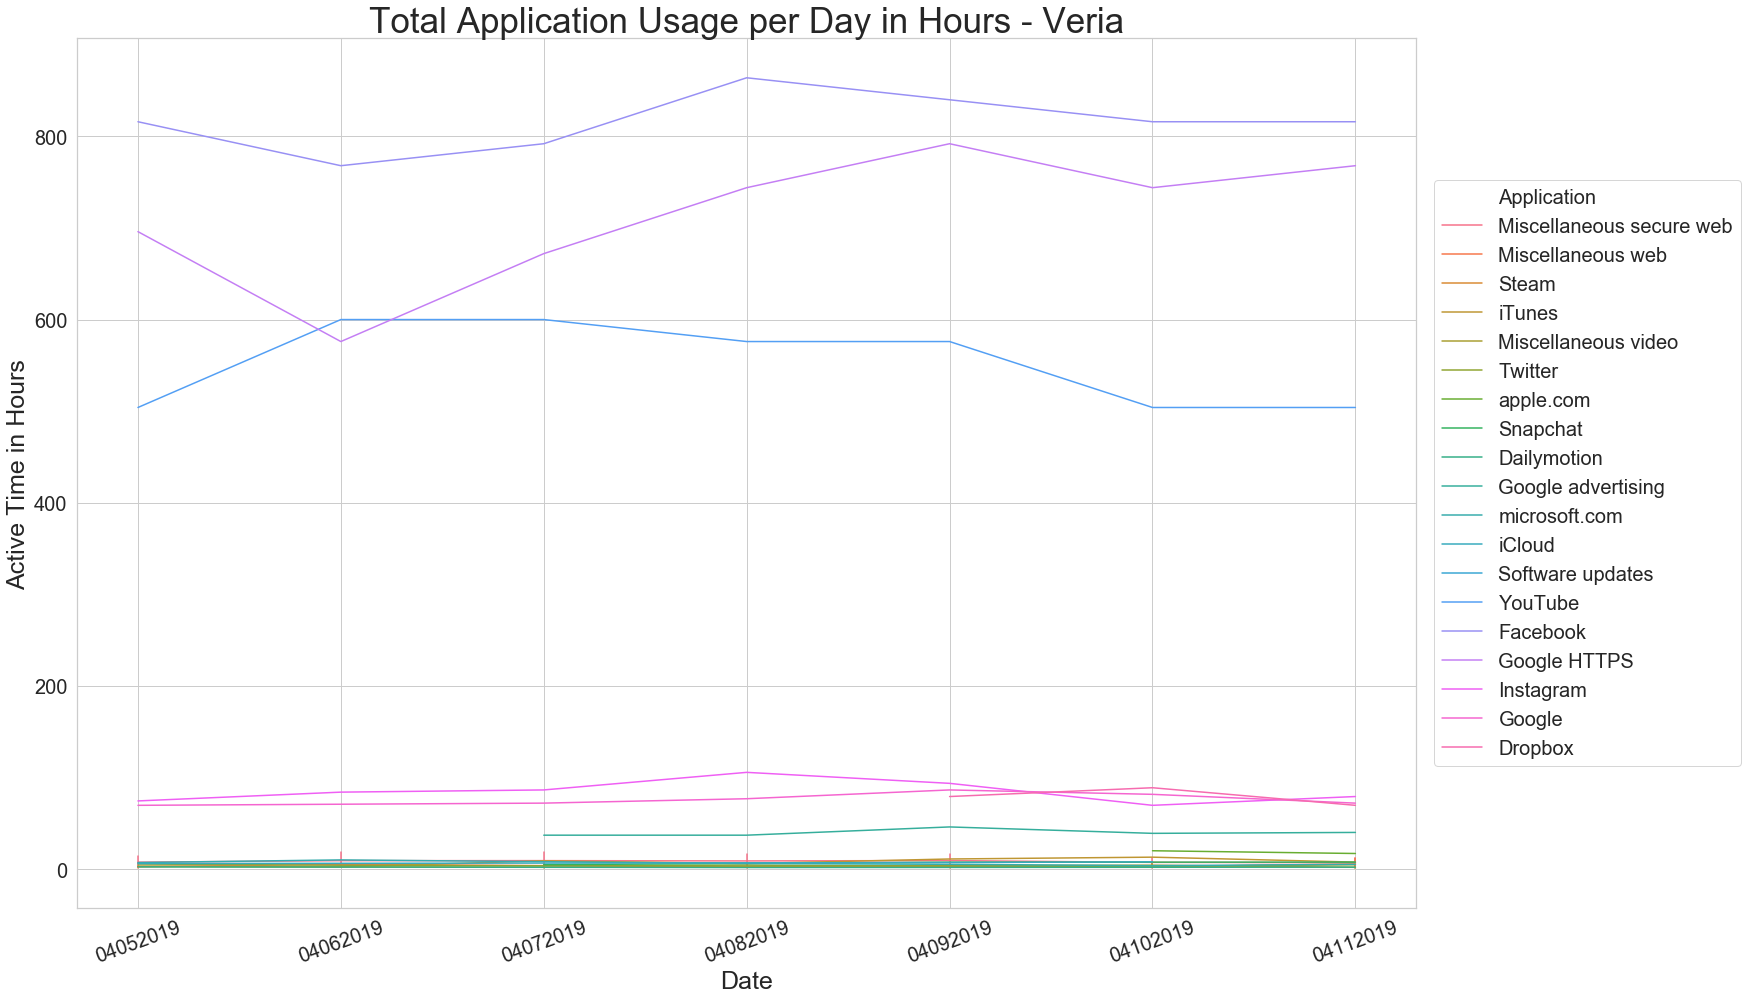

In [75]:
time_app_usage(veria_app)

# 1.d. Social Networking Sites Only

In [77]:
social_lst = ['Instagram', 'Facebook', 'Skype', 'Viber', 'Instagram', 'Snapchat', 'Line','mail', 'hat', 'Kik', 'QQ', 'Kakao Talk', 'whatsapp', 'Whatsapp']

#--Social dataframe--
pat1 = '|'.join(social_lst)
social1 = traffic[traffic['Application'].str.contains(pat1, na=False)]

#--Whatsapp dataframe--
# pat2 = '|'.join(social_lst)
# whatsapp = traffic[traffic['Destination'].str.contains('whatsapp', na=False)]
# #--Replace Misc Secure Web with Whatsapp
# whatsapp.Application = whatsapp.Application.replace(regex='Miscellaneous secure web', value='Whatsapp')

# snapchat = traffic[traffic['Destination'].str.contains('snapchat', na=False)]
#--Replace UDP with Snapchat
# snapchat.Application = snapchat.Application.replace(regex='UDP', value='Snapchat')



# social = pd.concat([social1, whatsapp, snapchat])
social = social1

In [78]:
# snapchat

In [79]:
# len(whatsapp)

In [80]:
# len(social)

In [29]:
# traffic[traffic.Application =='UDP']

In [30]:
# social.columns

In [81]:
#--Camps with Social Networking Web Application data only (like Google, Facebook, etc. --no protocols)--
moria_social = social[social['camp_name']=='Moria']
kos_social = social[social['camp_name']=='Kos']
nea_social = social[social['camp_name']=='Nea']
skaram_social = social[social['camp_name']=='Skaram']
vathi_social = social[social['camp_name']=='Vathi']
veria_social = social[social['camp_name']=='Veria']

In [83]:
# social.groupby('Application').value_counts()

In [84]:
m = social[social.Application =='Snapchat']
m['# clients'].sum()

67

In [85]:
# social_usage = social[['Application','# clients','ActiveTime_hours' ]]
social_usage = social[['Application','# clients','Hours_per_Client' ]]

social_usage.groupby('Application').describe()

# clients                                                       \
                count        mean         std    min    25%    50%     75%   
Application                                                                  
Facebook         42.0  592.261905  406.962218  146.0  322.5  495.0  660.75   
Instagram        35.0  224.257143  197.499120   50.0  100.0  160.0  250.00   
Snapchat          4.0   16.750000    6.946222    9.0   12.0   17.0   21.75   

                    Hours_per_Client                                           \
                max            count      mean       std   min     25%    50%   
Application                                                                     
Facebook     1749.0             42.0  1.472857  1.367018  0.26  0.5300  1.005   
Instagram     736.0             35.0  0.627714  0.467208  0.15  0.2400  0.400   
Snapchat       24.0              4.0  0.442500  0.268499  0.21  0.3225  0.365   

                          
               75%   max  
Application               
Facebook     1.685  5.26  
Instagram    0.955  1.68  
Snapchat     0.485  0.83

### All Camps

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Six Camps')

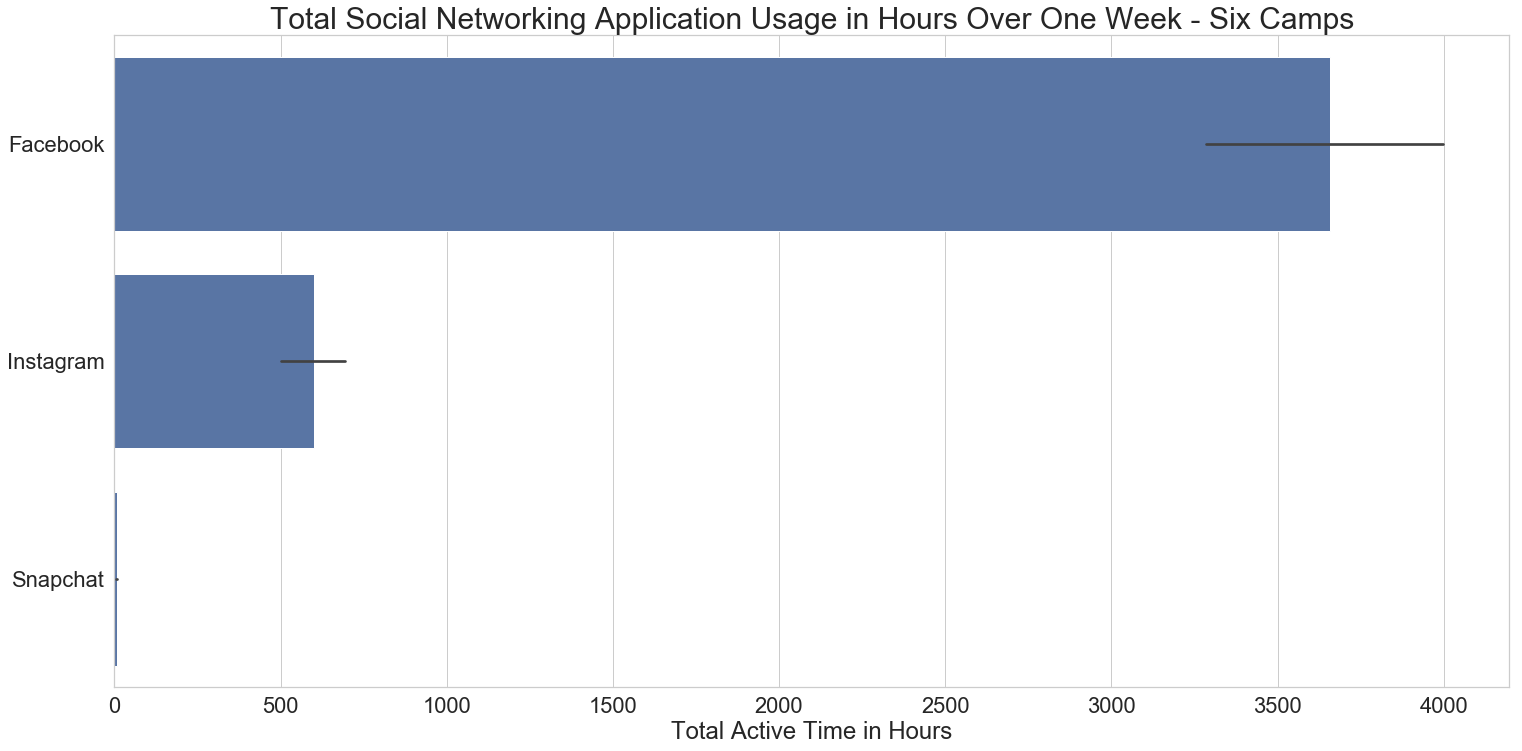

In [86]:
bar_top10(social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Six Camps')

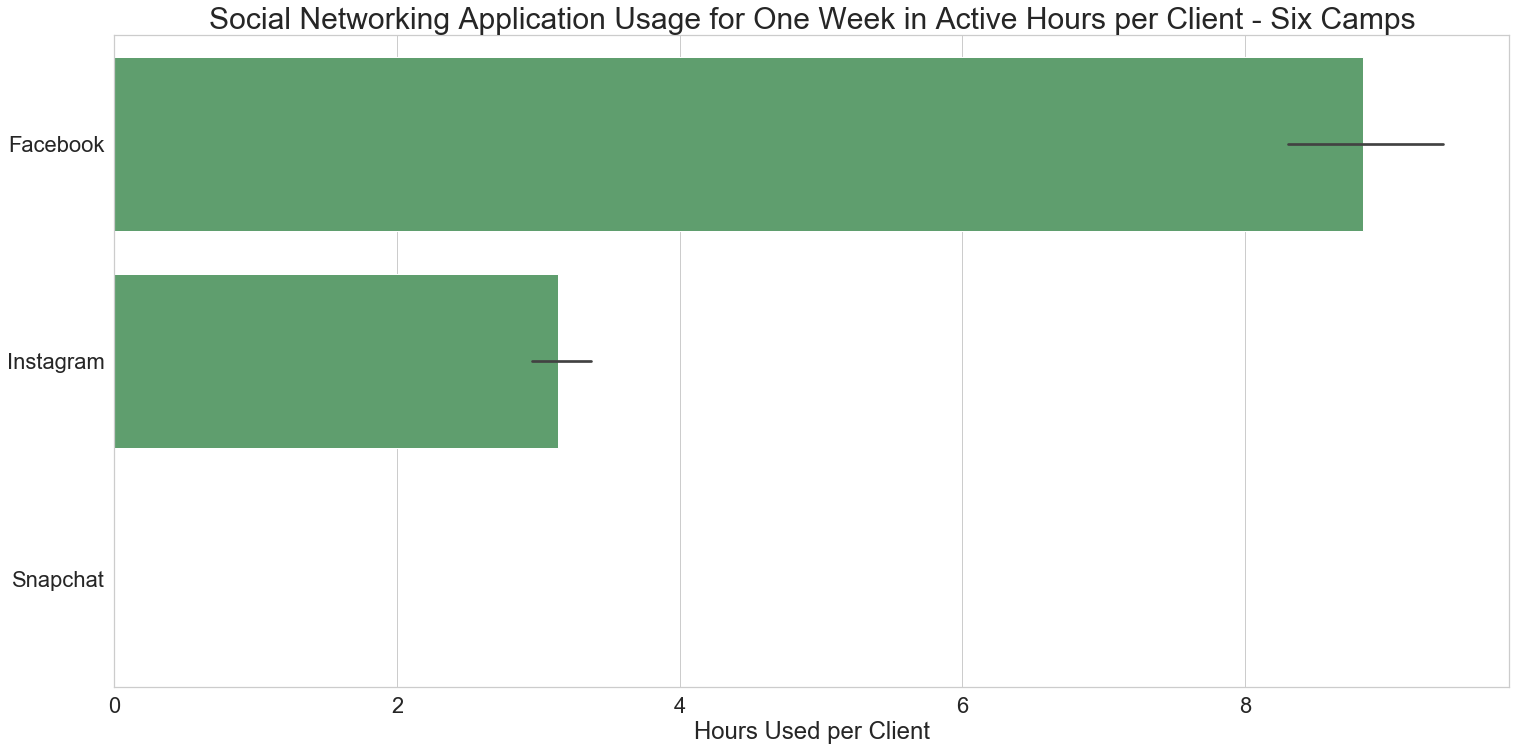

In [87]:
bar_top10_hrs_per_client(social)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Six Camps", fontsize=30)

Text(0.5,1,'Social Networking Application Usage Over One Week in Active Hours per Client - Six Camps')

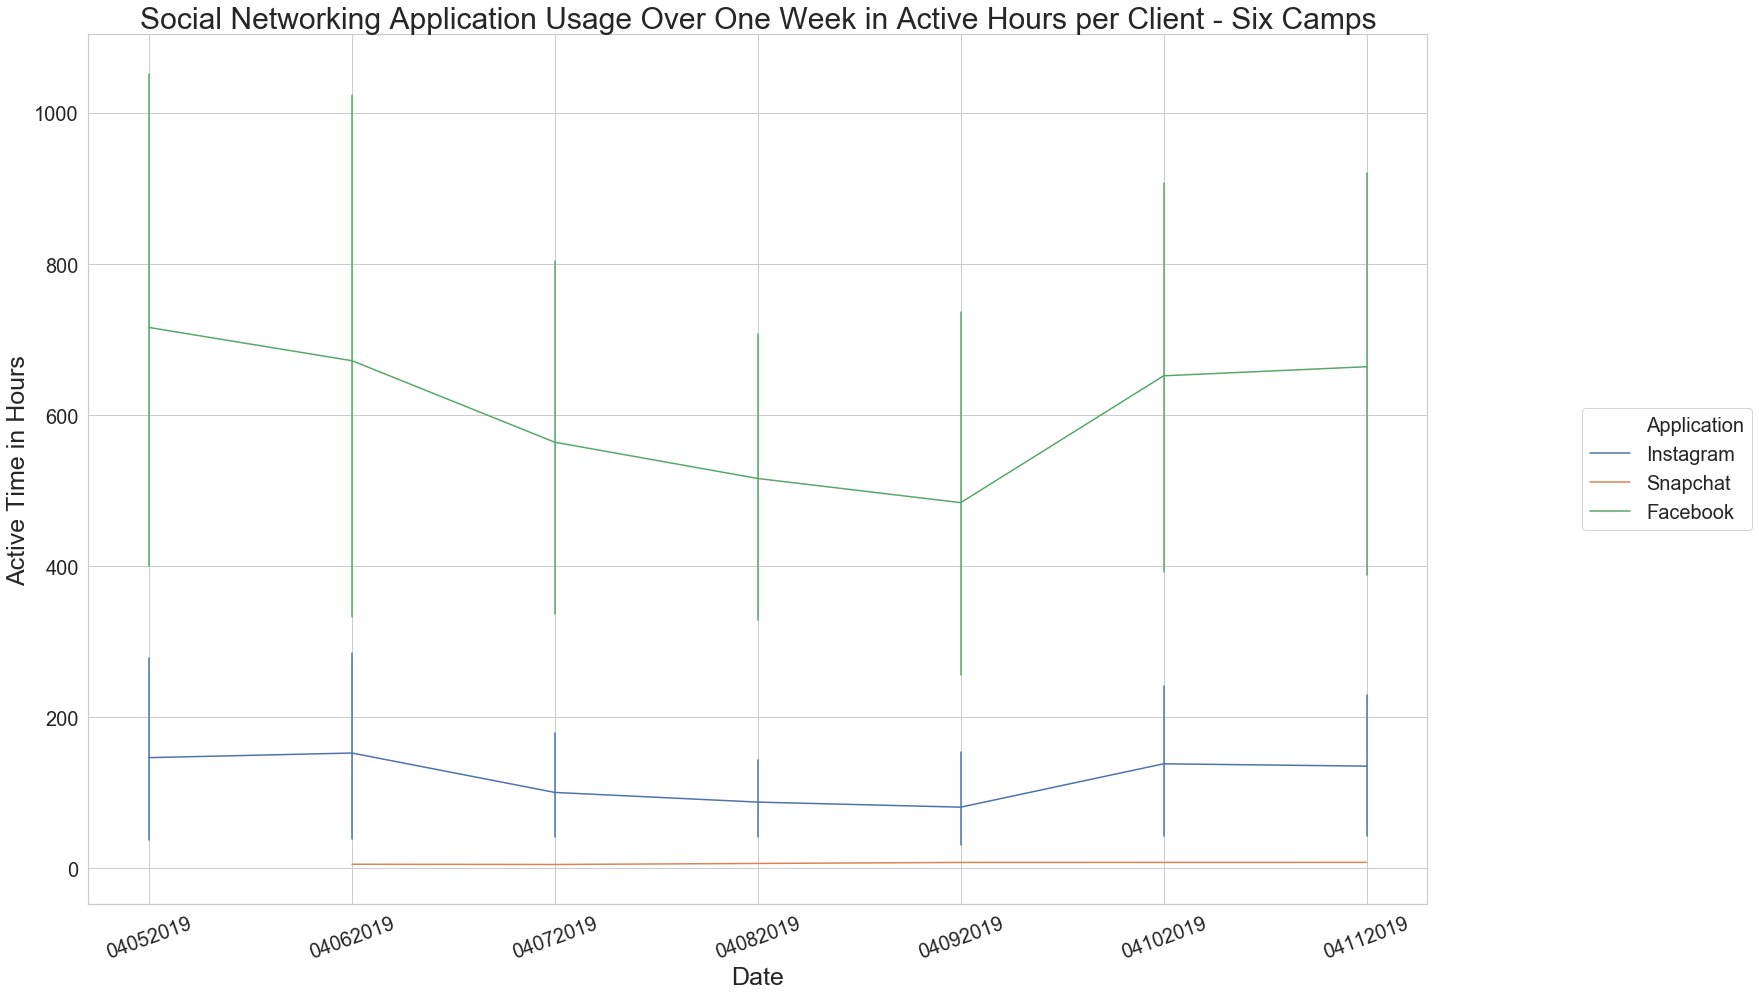

In [88]:
time_app_usage(social)
plt.title("Social Networking Application Usage Over One Week in Active Hours per Client - Six Camps", fontsize=30)

### Kos

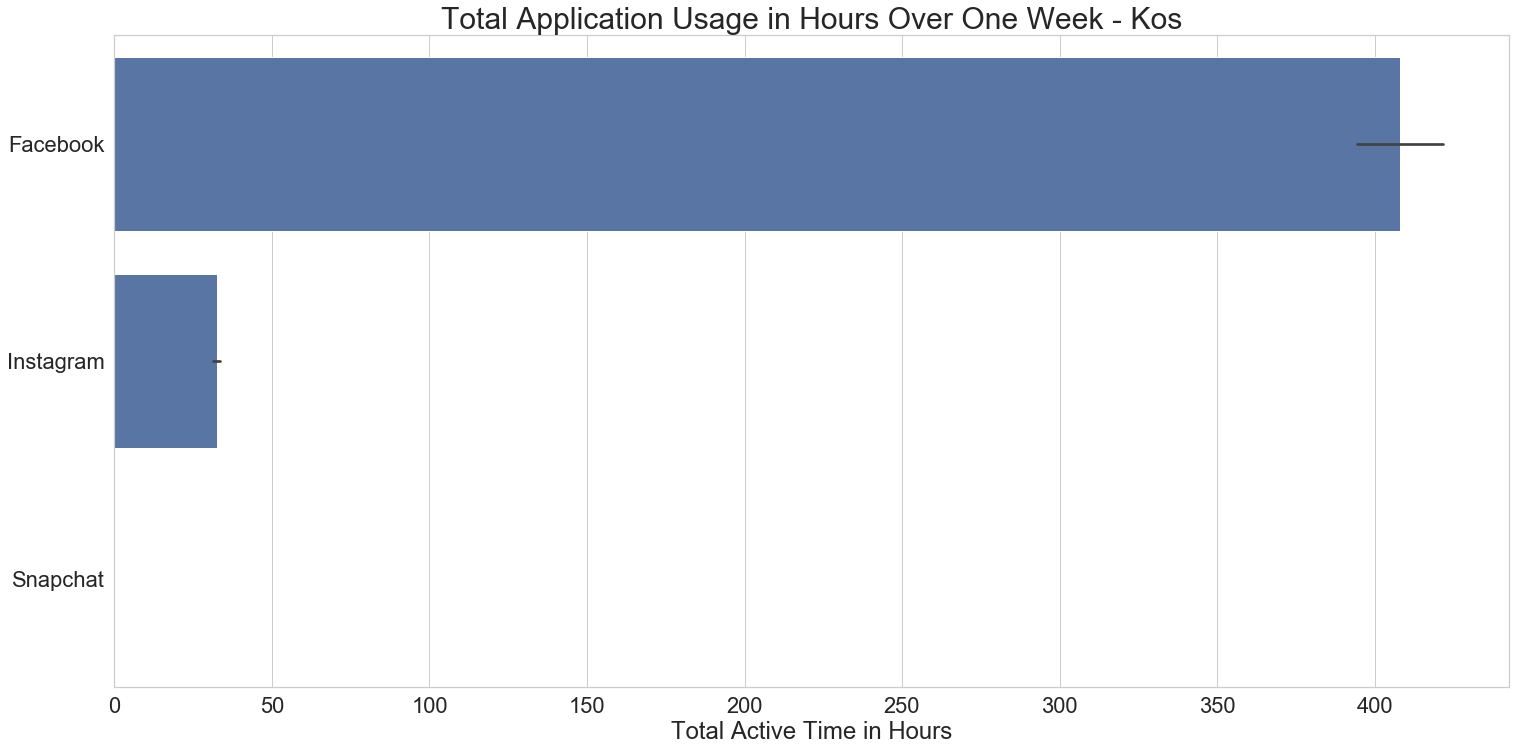

In [89]:
bar_top10(kos_social)

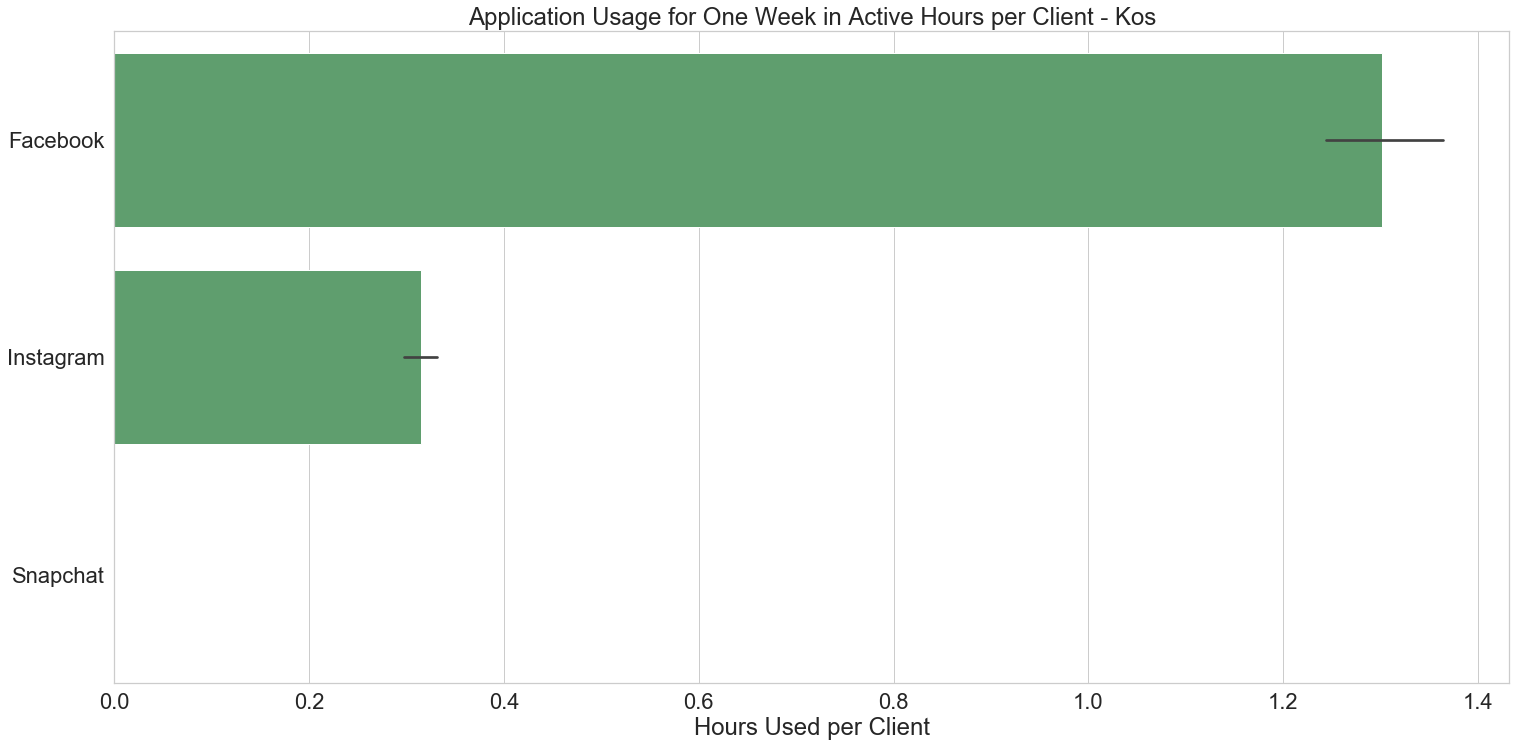

In [90]:
bar_top10_hrs_per_client(kos_social)

### Moria

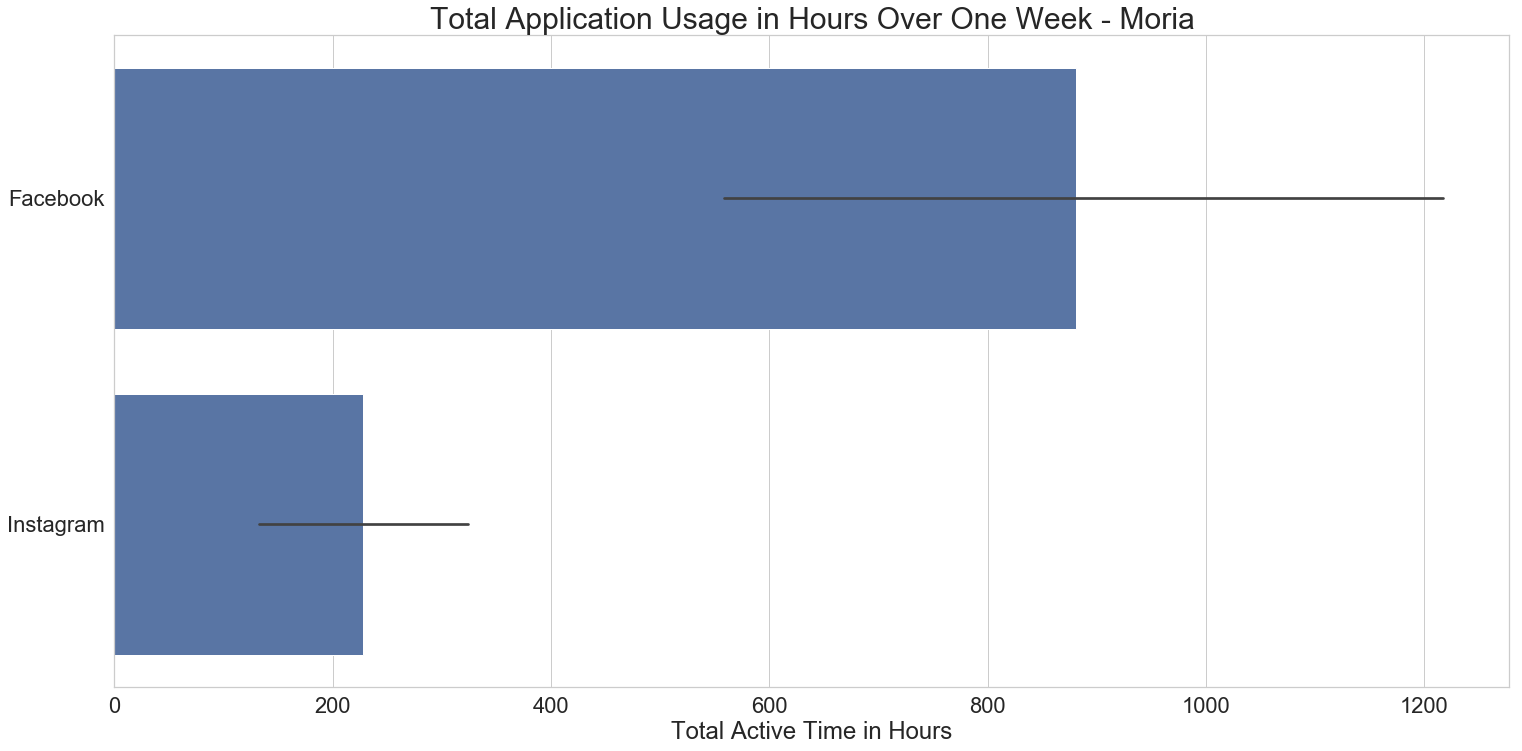

In [91]:
bar_top10(moria_social)

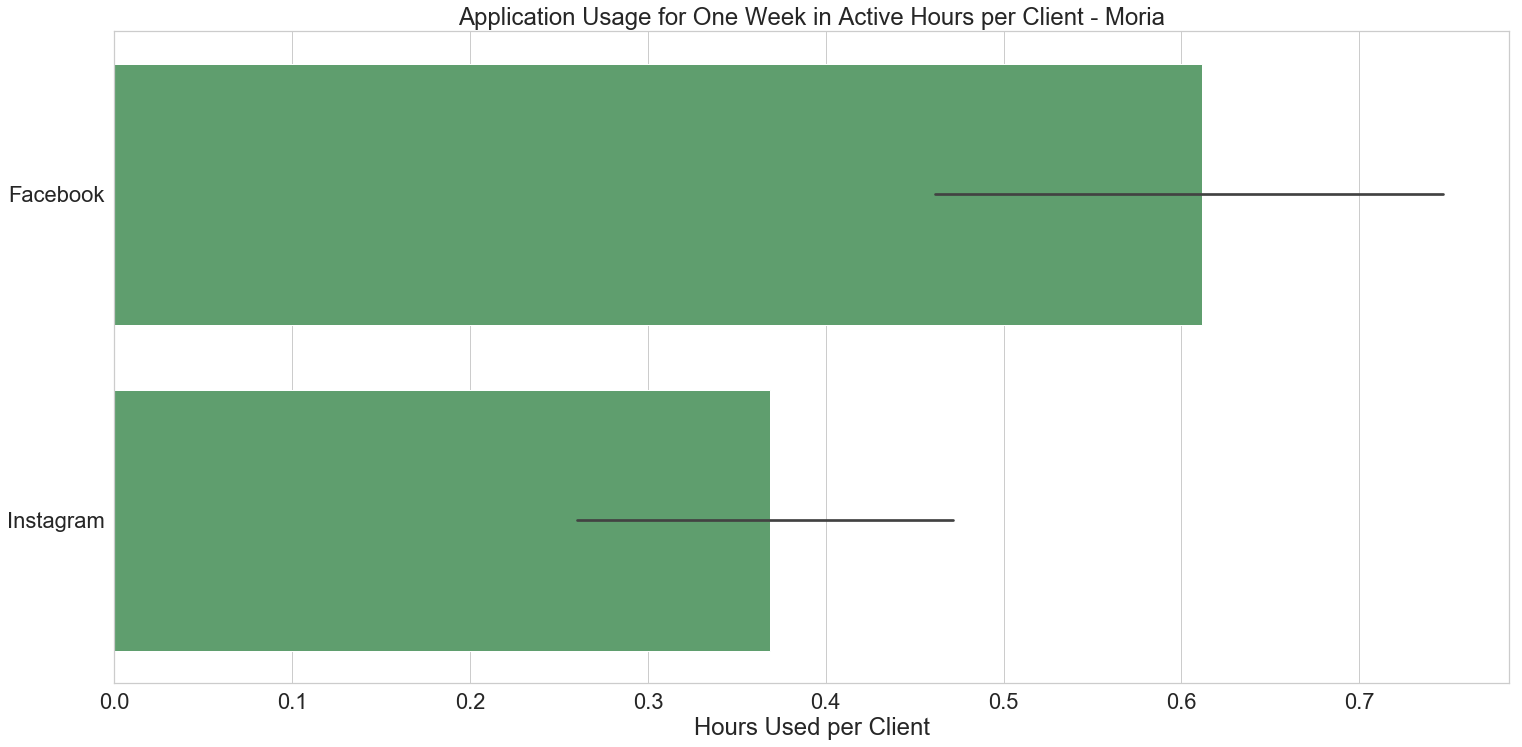

In [92]:
bar_top10_hrs_per_client(moria_social)

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Nea Kavala')

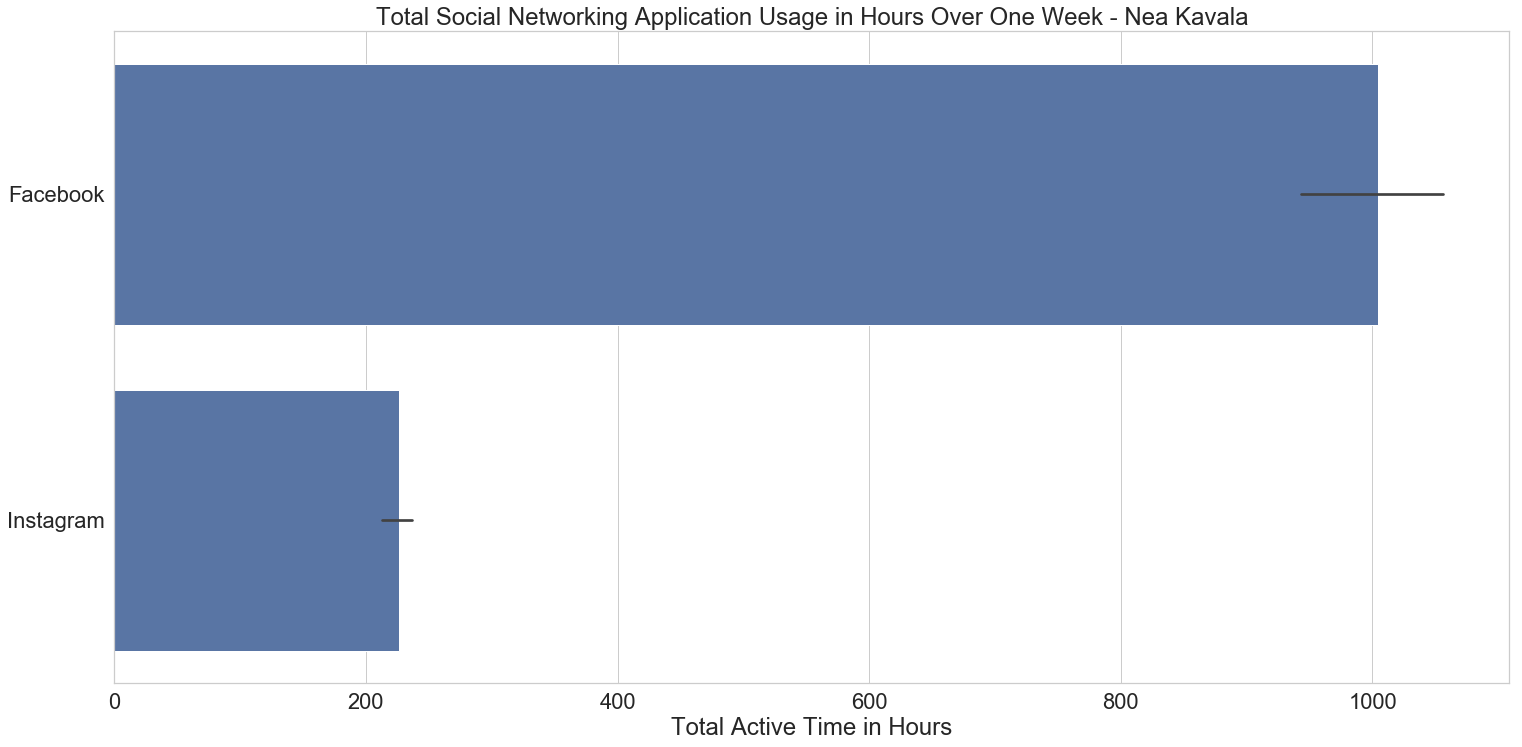

In [93]:
bar_top10(nea_social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Nea Kavala")
# plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Six Camps", fontsize=30)

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Nea Kavala')

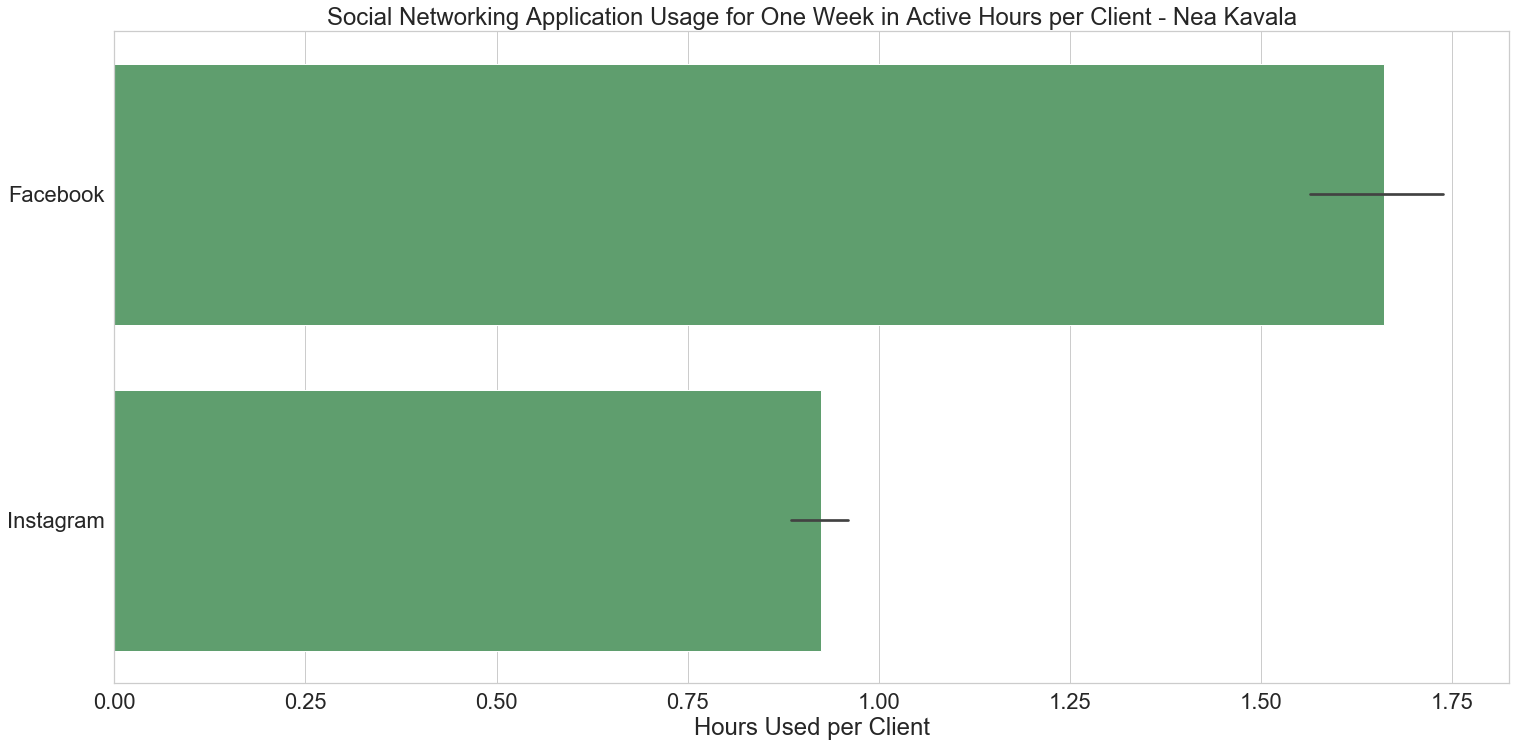

In [94]:
bar_top10_hrs_per_client(nea_social)
# plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Nea Kavala")

### Skaramangas

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Skaramangas')

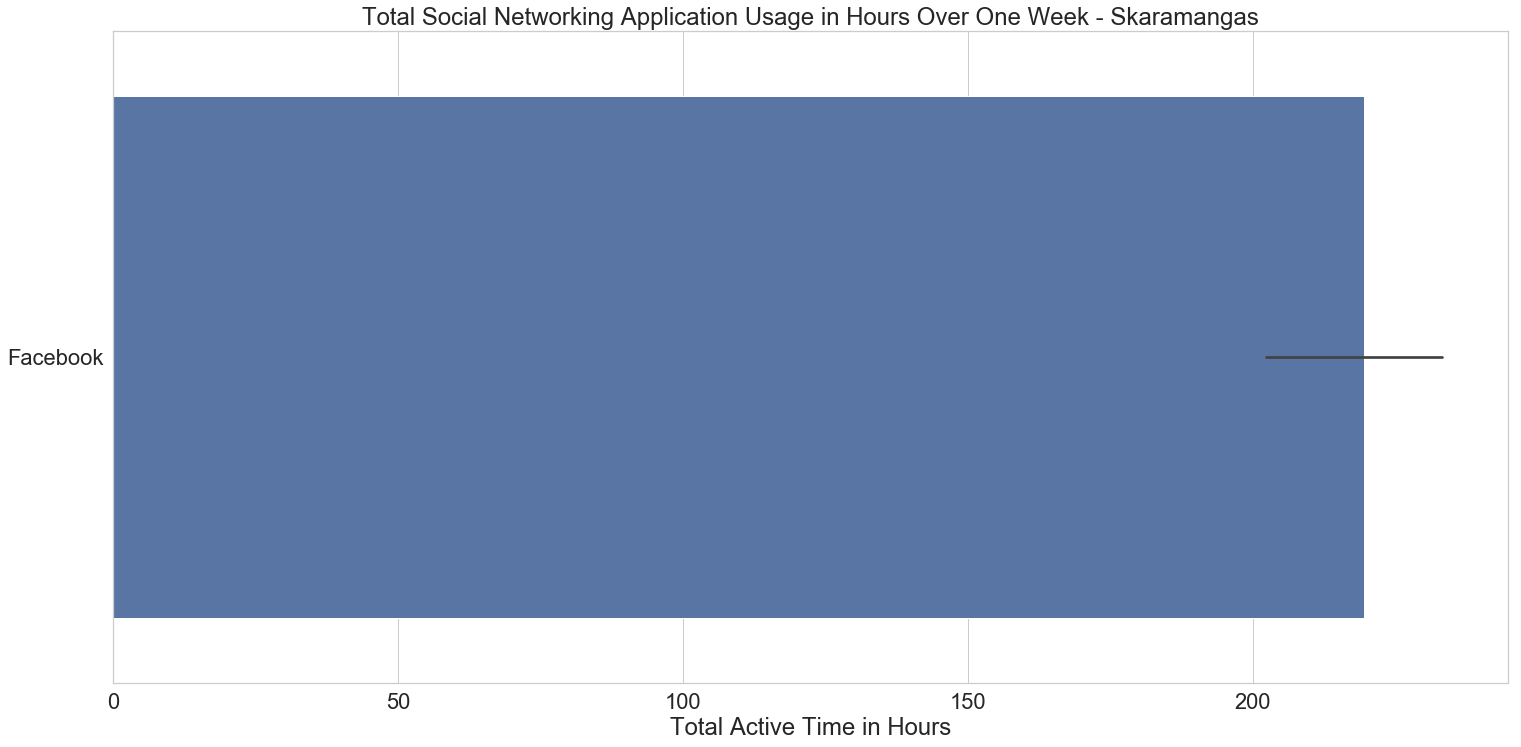

In [95]:
bar_top10(skaram_social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Skaramangas")
# plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Six Camps")

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Skaramangas')

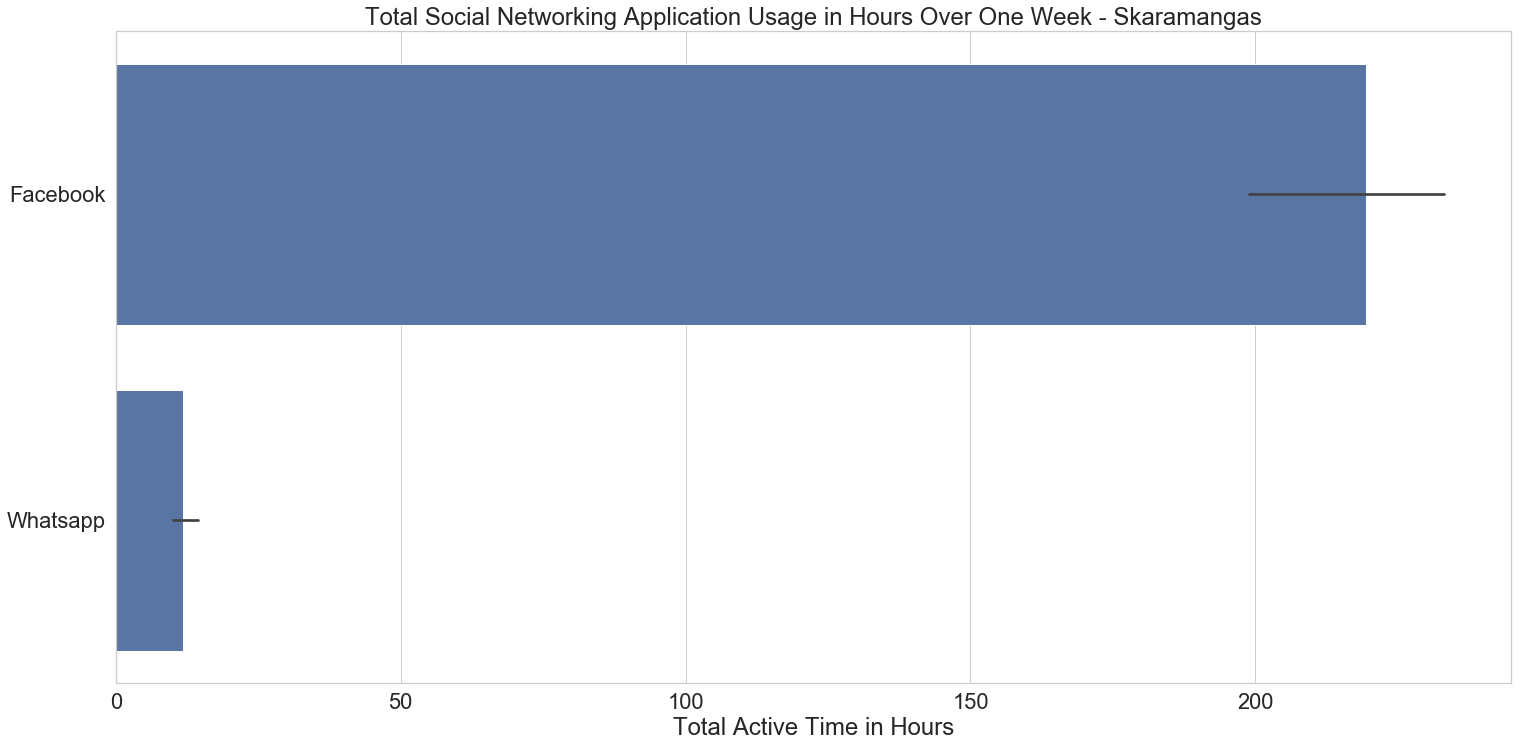

In [749]:
bar_top10(skaram_social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Skaramangas")
# plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Six Camps")

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas')

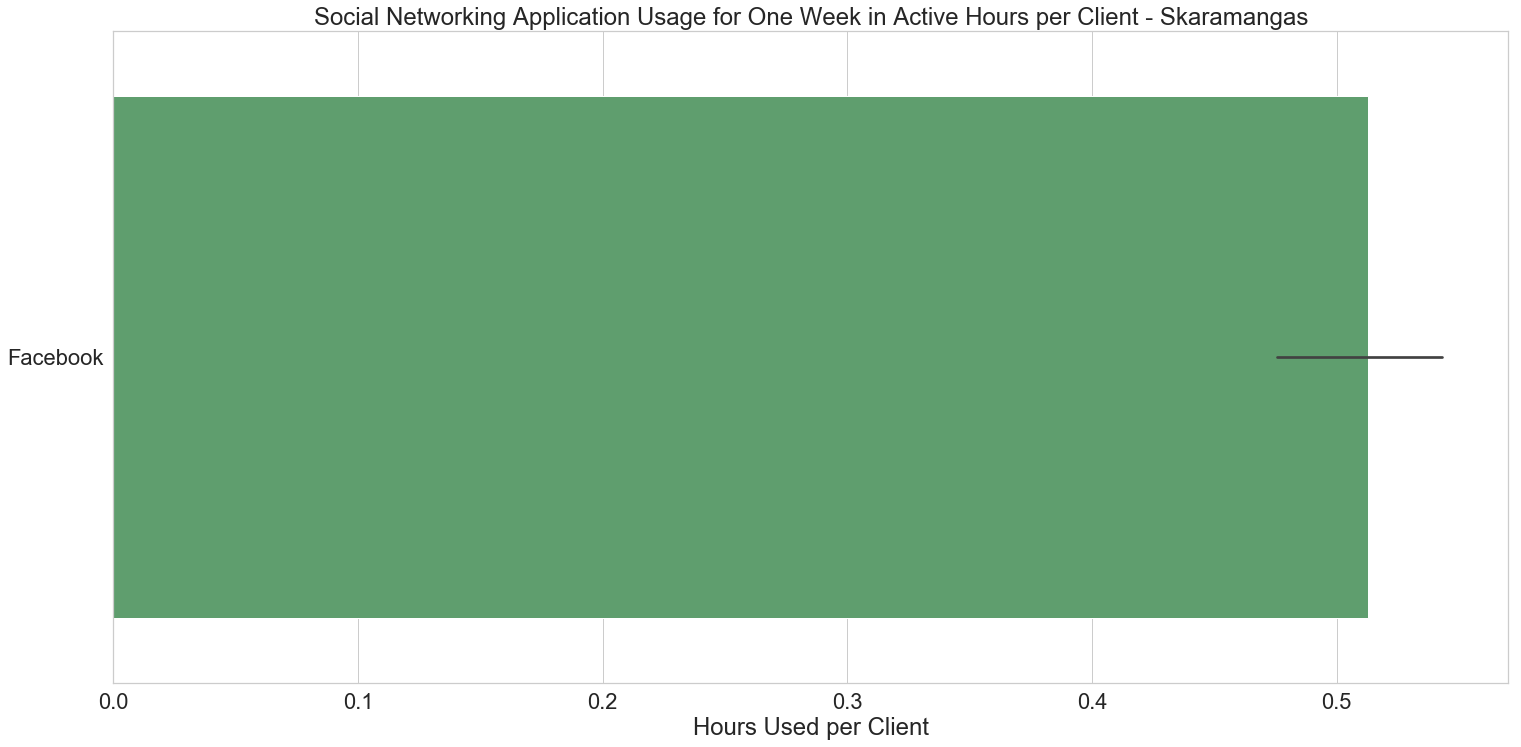

In [96]:
bar_top10_hrs_per_client(skaram_social)
# plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas")

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas')

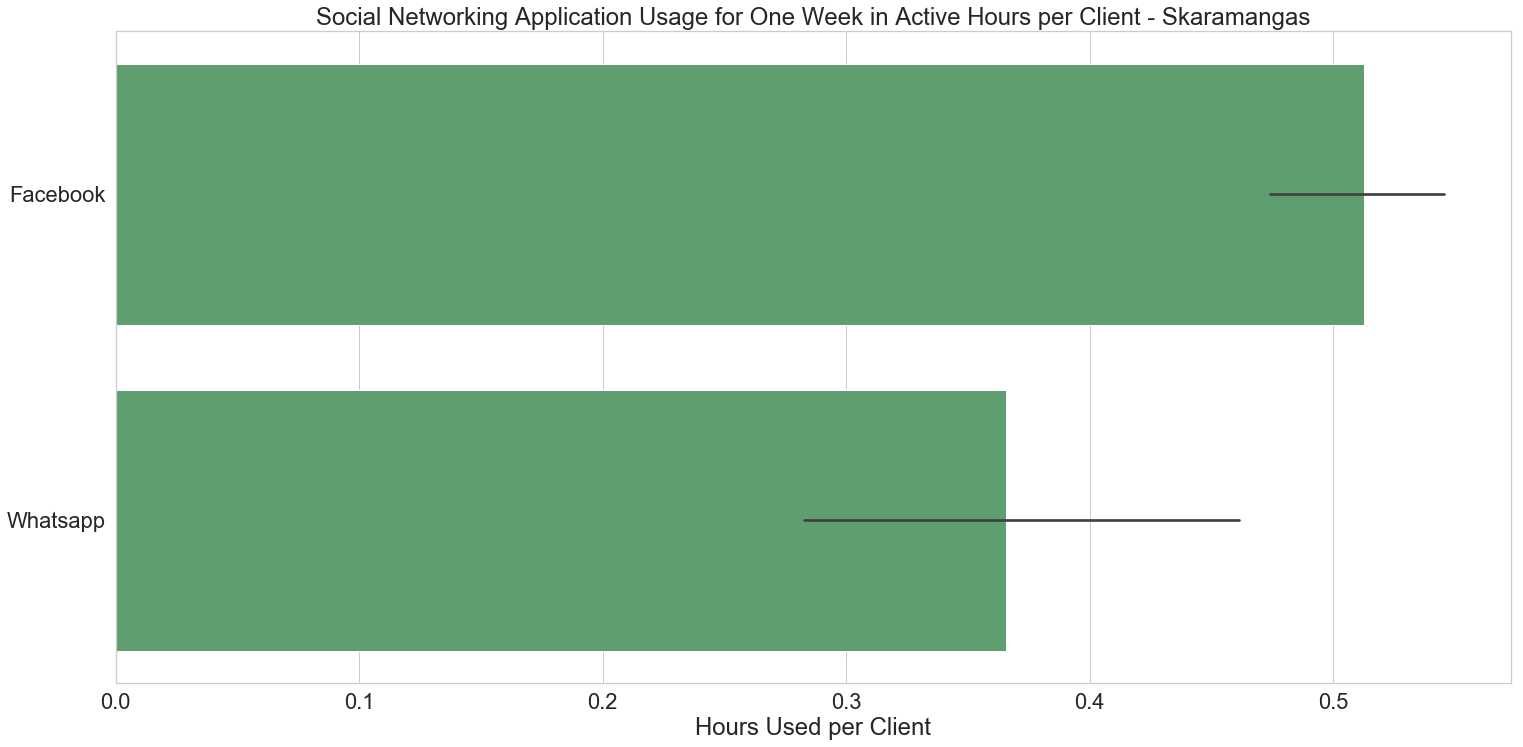

In [750]:
bar_top10_hrs_per_client(skaram_social)
# plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas")

### Vathi Samos

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Vathi Samos')

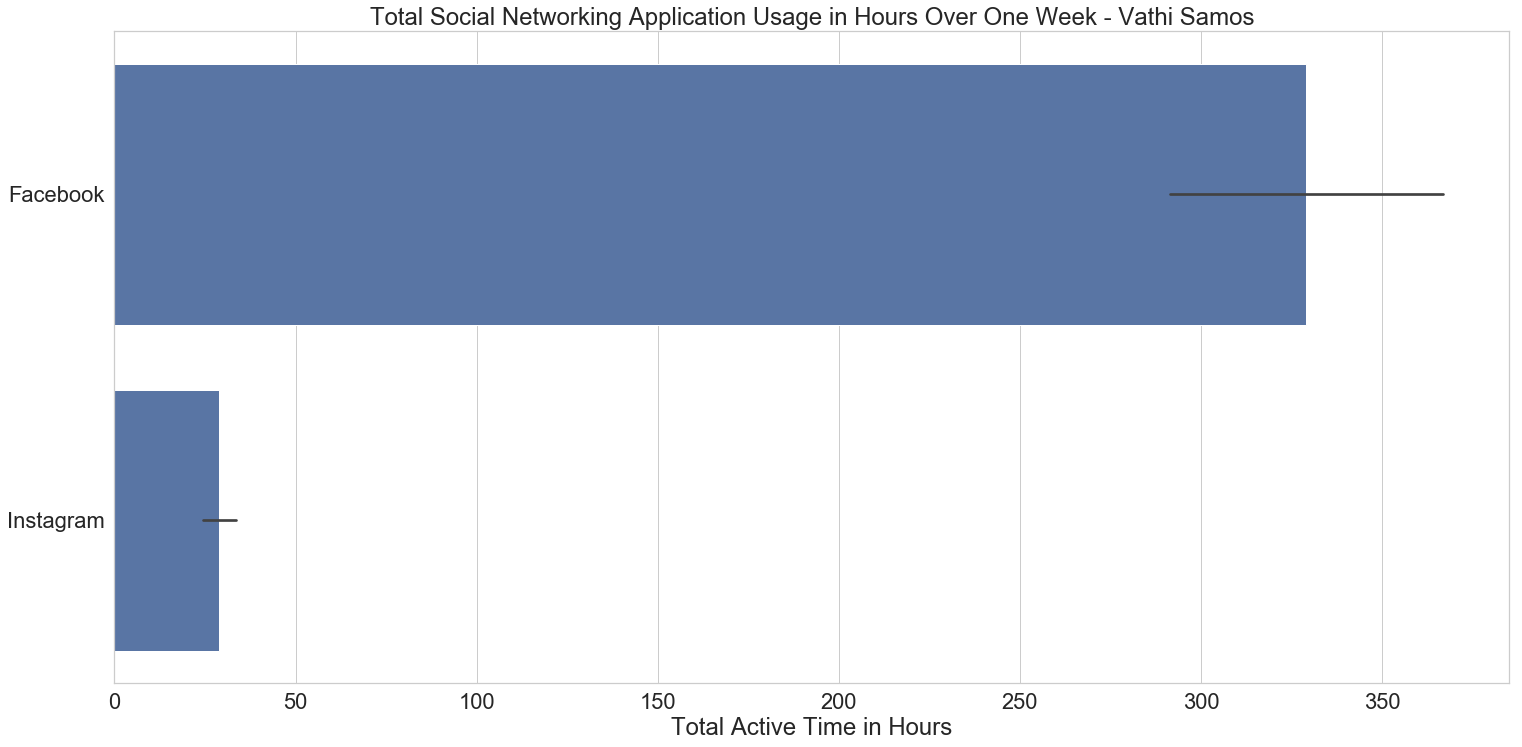

In [97]:
bar_top10(vathi_social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Vathi Samos")
# plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas")

Text(0.5,1,'Total Social Networking Application Usage in Hours Over One Week - Vathi Samos')

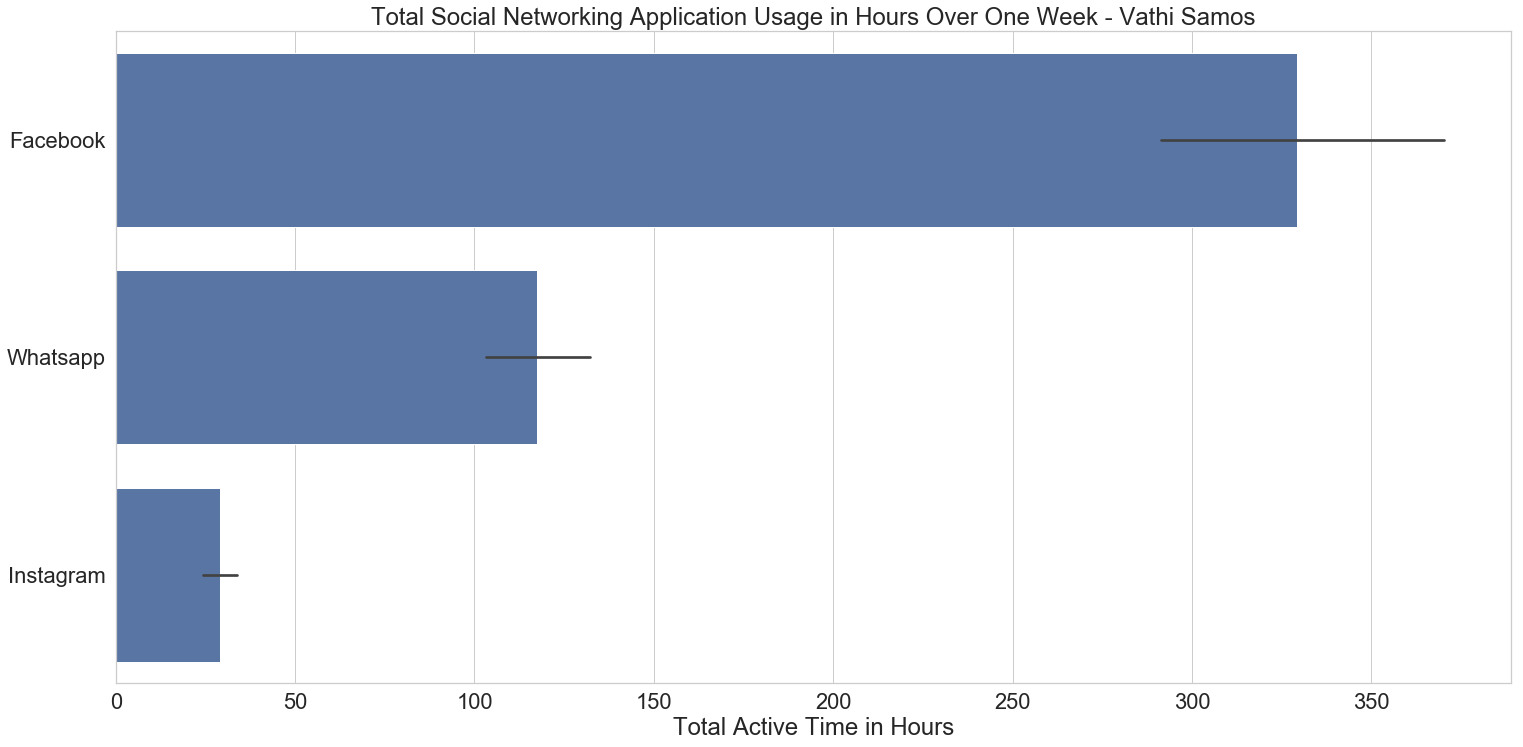

In [751]:
bar_top10(vathi_social)
plt.title("Total Social Networking Application Usage in Hours Over One Week - Vathi Samos")
# plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Skaramangas")

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Vathi Samos')

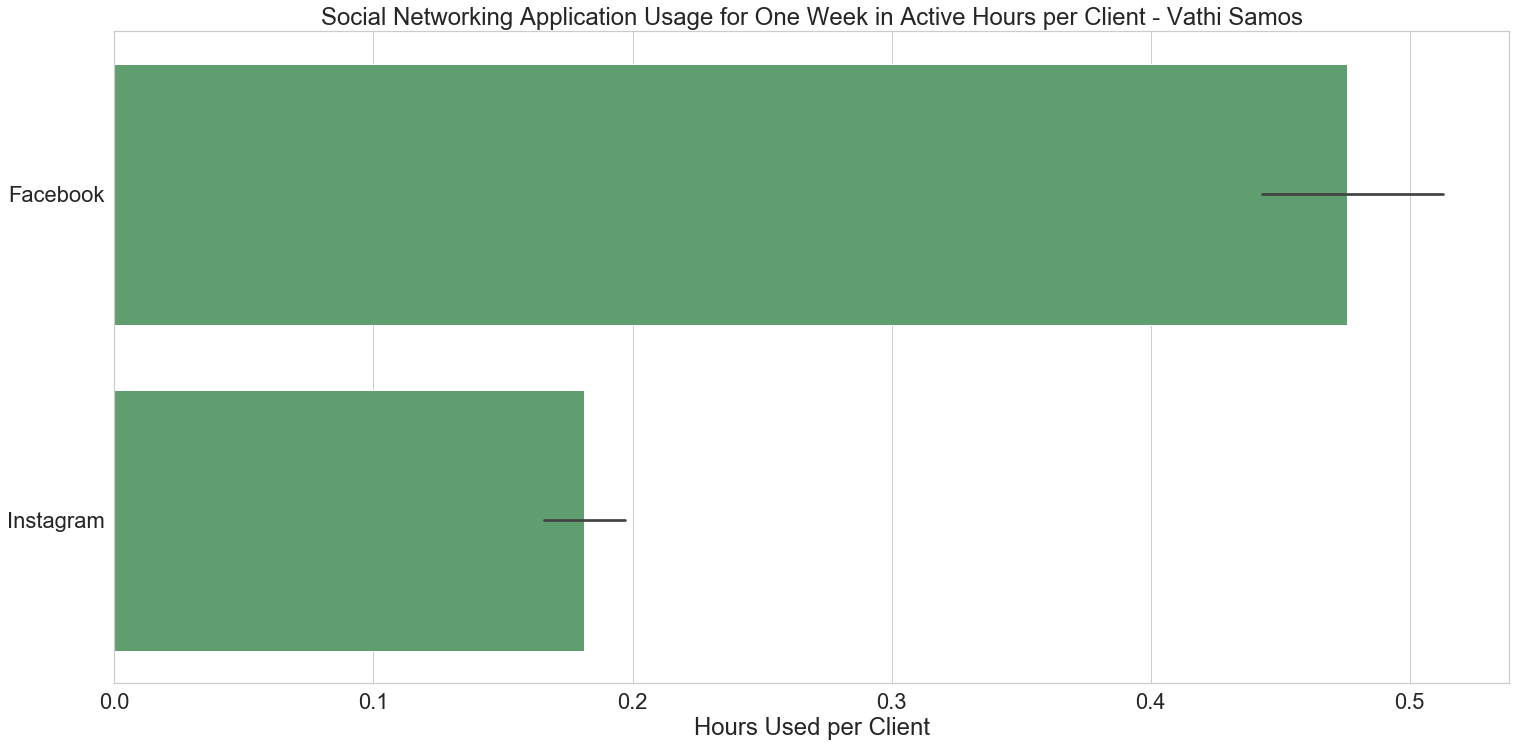

In [98]:
bar_top10_hrs_per_client(vathi_social)
# plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Vathi Samos")

Text(0.5,1,'Social Networking Application Usage for One Week in Active Hours per Client - Vathi Samos')

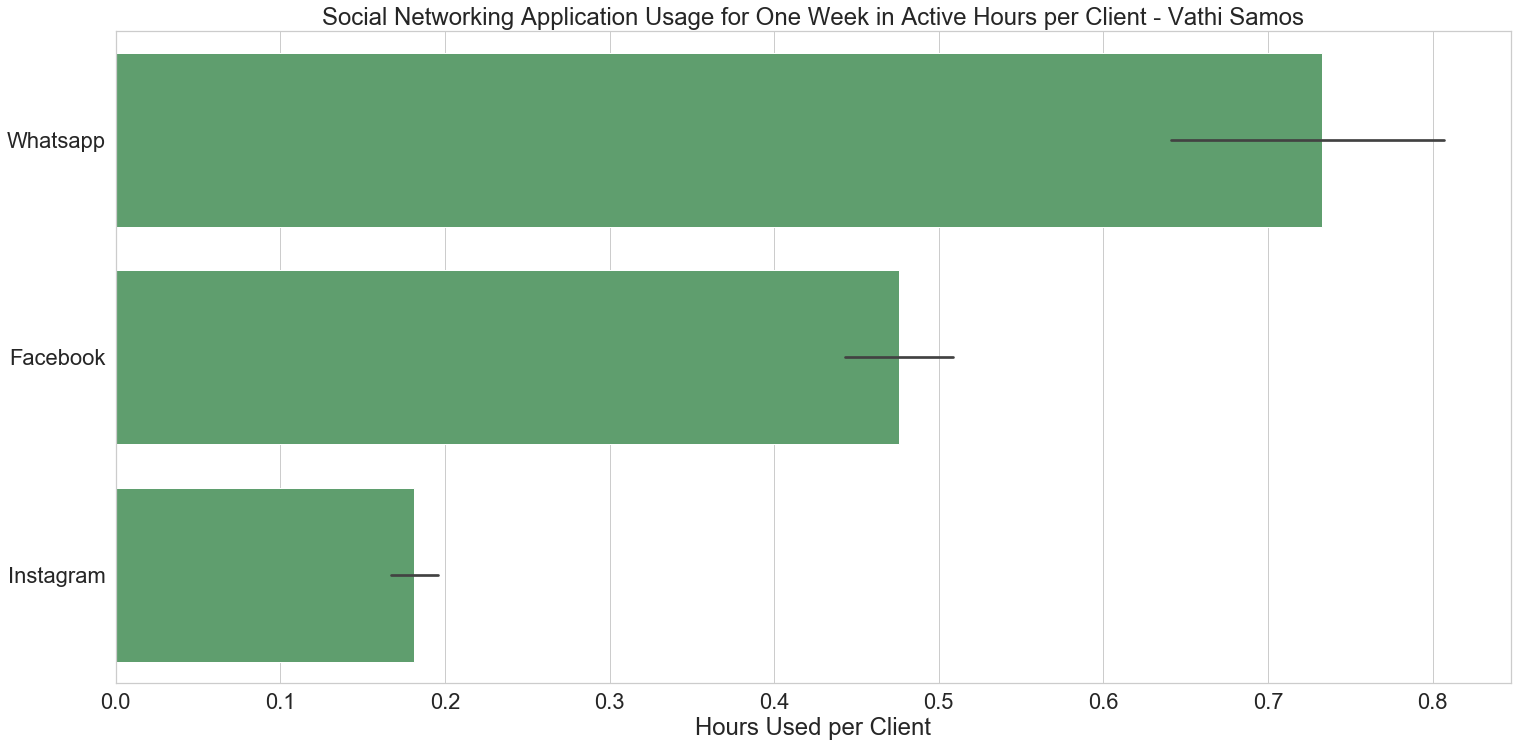

In [752]:
bar_top10_hrs_per_client(vathi_social)
# plt.title("Total Social Networking Application Usage in Hours Over One Week - Six Camps", fontsize=30)
plt.title("Social Networking Application Usage for One Week in Active Hours per Client - Vathi Samos")

### Veria

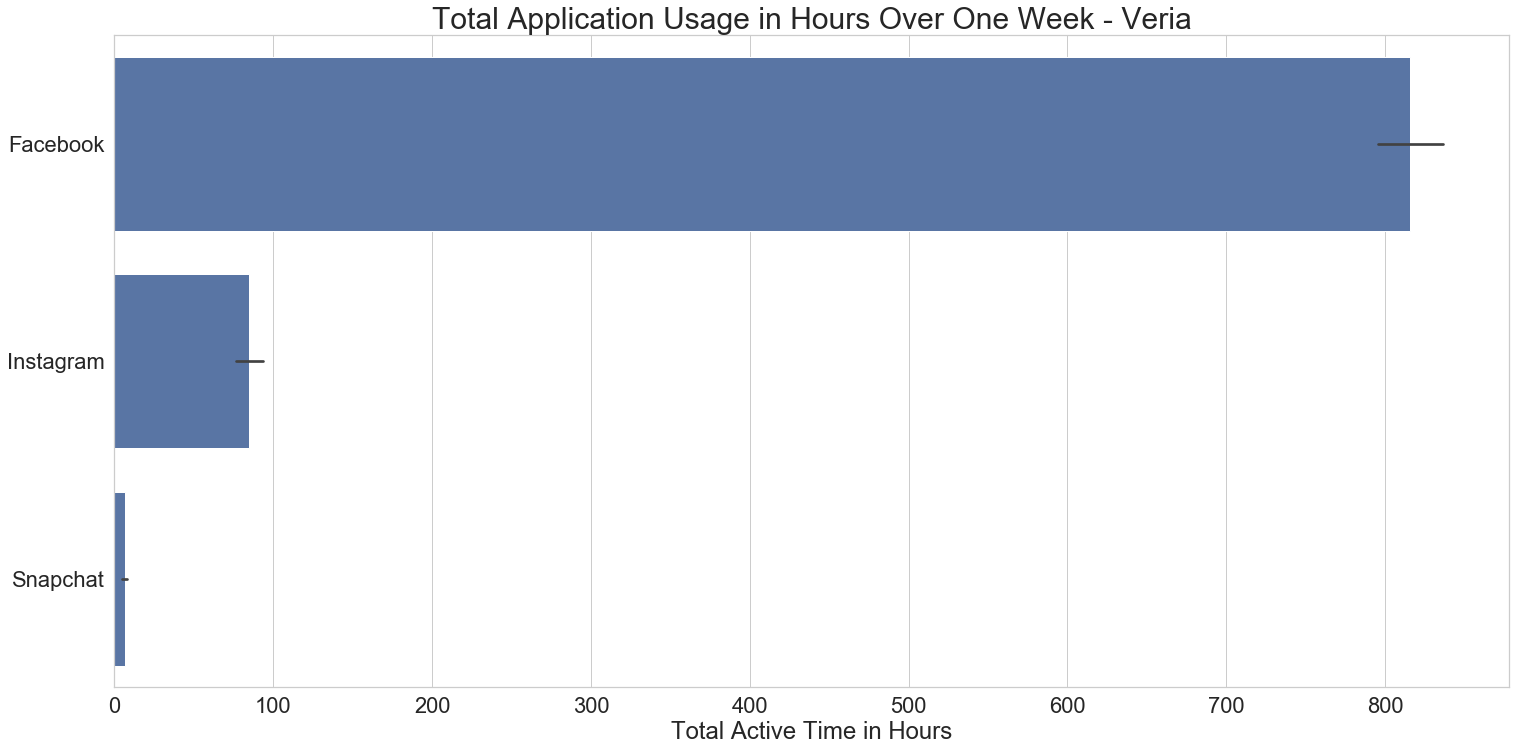

In [99]:
bar_top10(veria_social)

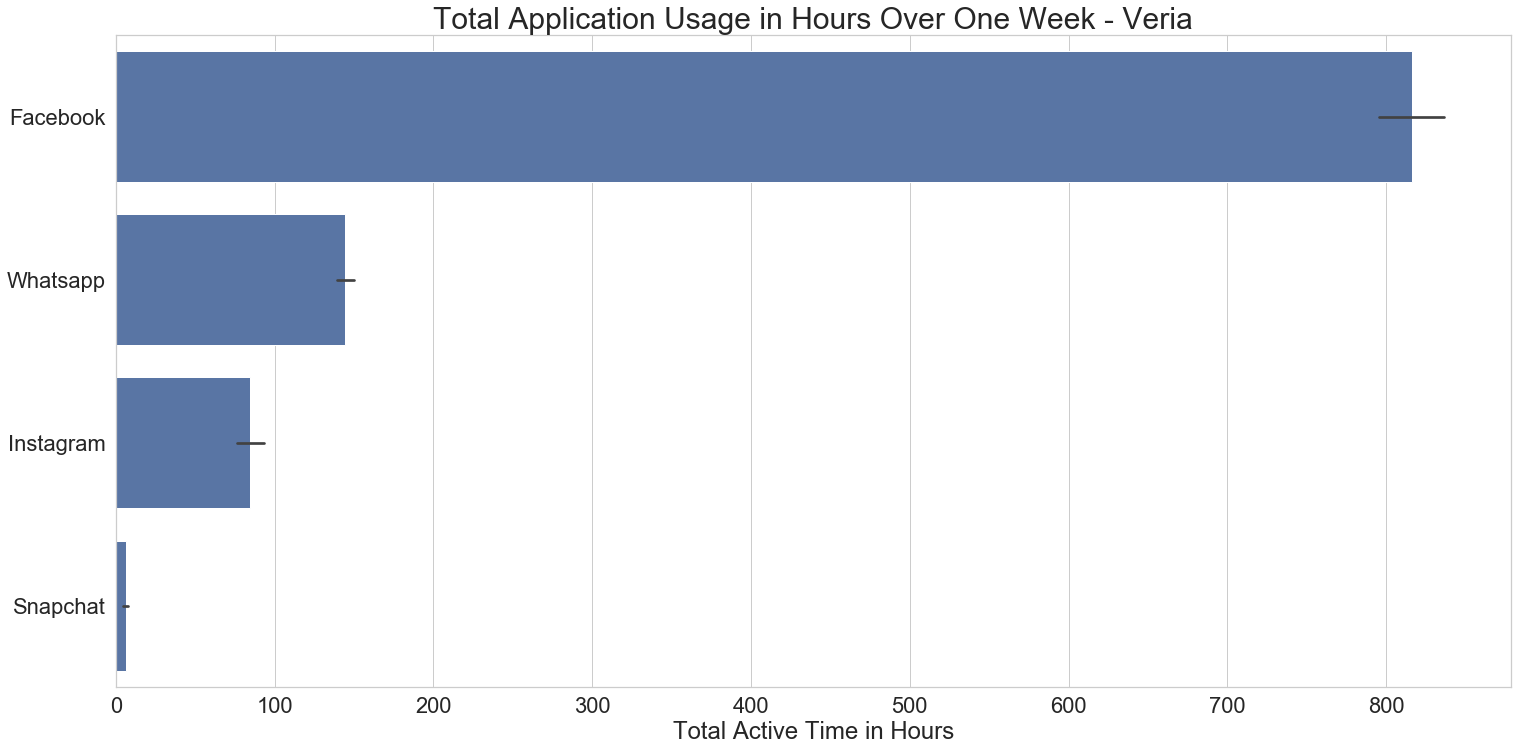

In [753]:
bar_top10(veria_social)

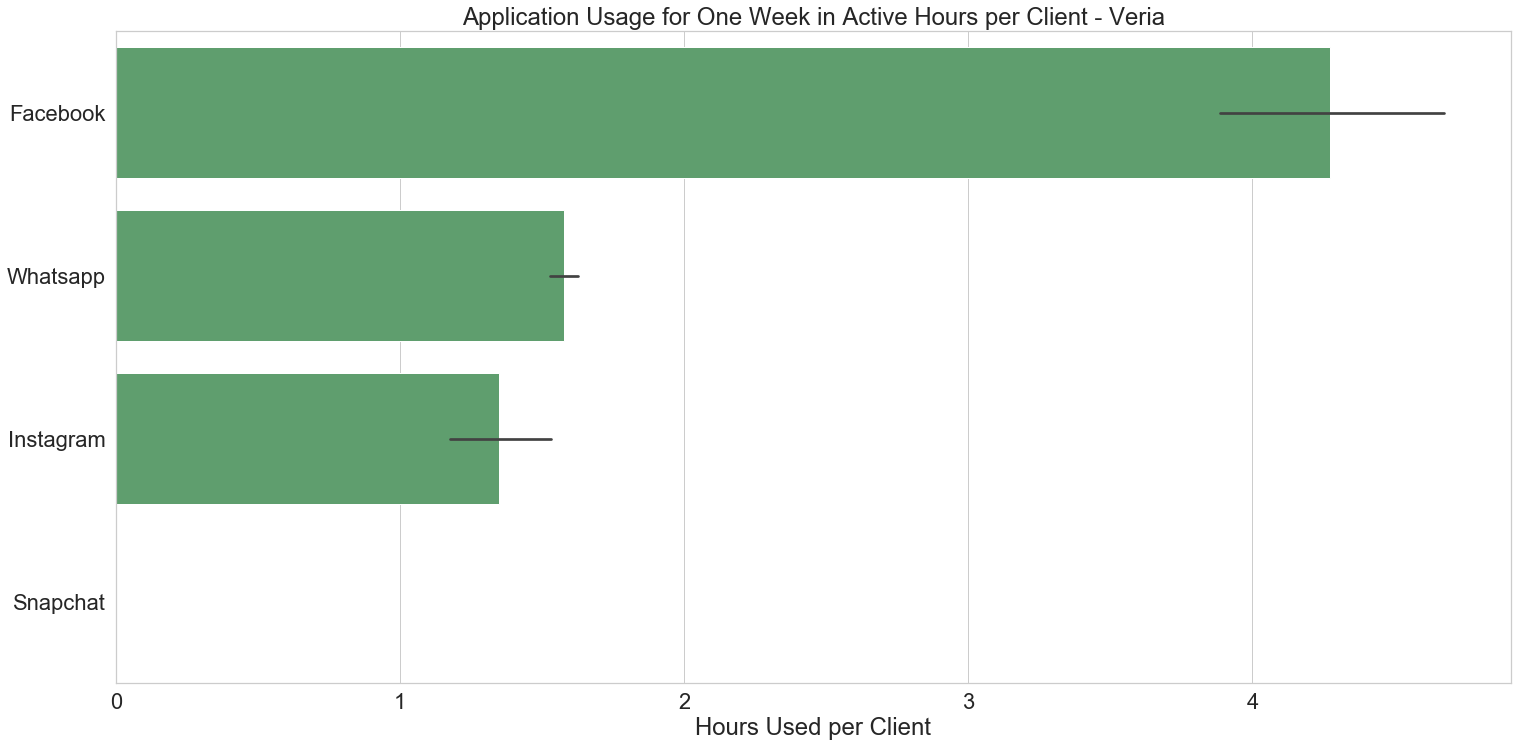

In [754]:
bar_top10_hrs_per_client(veria_social)

In [ ]:
# data['ActiveTime_Minutes'] = np.where(hr == True, data['active_time_num']*hour, data['active_time_num'])

In [359]:
# def minute_maker(increment, multiplier):
#     hour = 60
#     day = 24*60
#     week = 7*day
#     month = 30.3*week
#     year = 365*month
    
#     temp = data['active_time_increment'].str.contains(increment) 
#     np.where(temp == True)
# #     data['ActiveTime_Minutes'] = np.where(temp == True, data['active_time_num']*multiplier, data['active_time_num'] )
#     np.where(temp == True, data['active_time_num']*multiplier, data['active_time_num'] )
#     return data

In [390]:
# minute_maker('hour', hour)
# minute_maker('day', day)
# minute_maker('week', week)
# minute_maker('month', month)

# clean_data = pd.concat([h,d,w,m])

In [395]:
traffic['date'].unique()

array(['482019', '4112019', '452019', '462019', '492019', '472019',
       '4102019'], dtype=object)

In [6]:
traffic.isnull().sum()

In [7]:
traffic.Application.value_counts()

### Group by Camp

In [274]:
data.columns

Index(['Application', 'Destination', 'Protocol', 'Port', '% Usage', 'Usage',
       'Sent', 'Received', 'Flows', 'Active time', '# clients', 'filename',
       'camp_name', 'date'],
      dtype='object')

In [8]:
data[data['Active time'] == '3 months']

## 24-hour Daily Traffic Analytic Data (Device Usage Data for each Application)

In [278]:
#--File Names for traffic analytics (24-hour):
friday_file = 'Data/traffic_analytics/Device_usage_application_Apr4_to_Apr5_8-10am.xlsx'

In [279]:
camp_list = ['Moria', 'Nea', 'Vathi', 'Skaram', 'Kos', 'Veria']

In [280]:
#--Source: https://stackoverflow.com/questions/44286797/export-dataframe-with-sheetname-as-column
import pandas as pd
import numpy as np
import glob 
import openpyxl


def make_app_data24hr(file_name):
    file = file_name
    app_data = pd.DataFrame()
    sheets_dict = pd.read_excel(file, sheet_name=None)
    for camp, frame in sheets_dict.items():
        frame['Camp_Name'] = camp
        app_data = app_data.append(frame, ignore_index=True)
        app_data = app_data.drop(columns=['#', 'Description']) #--anonymizes dataframe, drops index numbers from original dataset
    return app_data

# all_data.to_csv('Workload.csv') #--saves to csv--

# #--Anonymize 24-hr dataframes
# def anon_data(df):
#     anon = df.drop(columns=['#', 'Description'])
#     return anon

In [281]:
friday = make_app_data24hr(friday_file)

In [9]:
friday

In [117]:
kos_app = pd.read_excel(file, sheet_name='Kos')
moria_app = pd.read_excel(file, sheet_name='Moria')
nea_app = pd.read_excel(file, sheet_name='Nea')
skaram_app = pd.read_excel(file, sheet_name='Skaram')
vathi_app = pd.read_excel(file, sheet_name='Vathi')
veria_app = pd.read_excel(file, sheet_name='Veria')

In [10]:
kos_app

In [11]:
kos_stats = kos_app.drop(columns=['#', 'Description', 'Date', 'week_date', 'Time', 'Category', 'Day_of_Week'])
kos_stats

In [12]:
kos_stats.groupby('Application').describe()

In [57]:
kos_app = kos_app[kos_app['Portion of rule'] != '<0.1%']
kos_app = kos_app[kos_app['Portion of rule'] != '<0.1']
kos_app['Portion of rule'].unique()

array([0.067, 0.065, 0.058, 0.041, 0.036, 0.033, 0.031, 0.028, 0.026,
       0.024, 0.02, 0.018, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01,
       0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001,
       0.025, 0.023, 0.017, 0.089, 0.087, 0.053, 0.044, 0.04, 0.039,
       0.037, 0.035, 0.034, 0.032, 0.03, 0.022, 0.019, 0.061, 0.055,
       0.048, 0.06, 0.029, 0.066, 0.05, 0.042, 0.027, 0.161, 0.062, 0.049,
       0.021, 0.205, 0.143, 0.084], dtype=object)

In [23]:
kos_app.columns

Index(['#', 'Description', 'Manufacturer', 'OS', 'Rule usage',
       'Portion of rule', 'Application', 'Category', 'Day_of_Week',
       'week_date', 'Time', 'Date'],
      dtype='object')

In [58]:
mini_kos = kos_app[['Application', 'Portion of rule']]

In [13]:
# app_lst = ['YouTube', 'Facebook', 'GoogleHTTPS', 'fath4-2.fna.whatsapp.net',
#        'fdcdn.net_Facebook_photos', 'Google', 'mmg.whatsapp.net',
#        'Instagram', 'iTunes']

insta = mini_kos[mini_kos['Application'] =='Instagram']
# mini_kos.hist(column='Portion of rule')

# for app in app_lst:
    
insta.hist()

In [40]:
mini_kos['Portion of rule'] = mini_kos['Portion of rule'].apply(str)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [62]:
mini_kos['Portion of rule'].unique()

array([0.067, 0.065, 0.058, 0.041, 0.036, 0.033, 0.031, 0.028, 0.026,
       0.024, 0.02, 0.018, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01,
       0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001,
       0.025, 0.023, 0.017, 0.089, 0.087, 0.053, 0.044, 0.04, 0.039,
       0.037, 0.035, 0.034, 0.032, 0.03, 0.022, 0.019, 0.061, 0.055,
       0.048, 0.06, 0.029, 0.066, 0.05, 0.042, 0.027, 0.161, 0.062, 0.049,
       0.021, 0.205, 0.143, 0.084], dtype=object)

In [ ]:
sns.set()
plt.figure(figsize=(25,12))
plt.title('Application Usage')
sns.barplot(x='Application', y='Usage (kB)', 
             data=app_usage)
plt.xticks(rotation=90)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c061e80>,
      dtype=object)

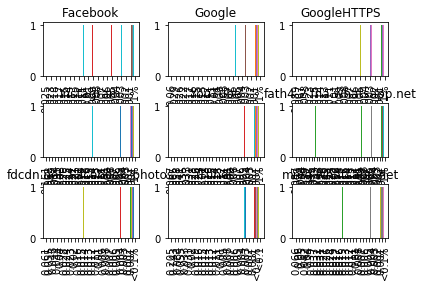

In [51]:
mini_kos['Portion of rule'].hist(by=mini_kos['Application'])

In [49]:
sns.distplot(x="Application", y="Portion of rule", data=mini_kos)

TypeError: distplot() got an unexpected keyword argument 'x'

In [14]:
kos_app.dtypes

In [15]:
# all_df[all_df['City'].isnull()]
kos_app.isnull().sum()